# **임대주택 단지 내 적정 주차수요 예측 대회**

처음부터 다시 시작하겠습니다.

In [1]:
PATH = r'C:\Users\Wyatt\wyatt37\data\parking'

In [2]:
import pandas as pd
pd.options.display.max_rows = 100
pd.options.display.max_columns = 100
from tabulate import tabulate

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.patches as mpatches

from matplotlib import font_manager, rc
font_path = "C:/Windows/Fonts/NGULIM.TTF"
font = font_manager.FontProperties(fname=font_path).get_name()
rc('font', family=font)

import warnings
warnings.filterwarnings("ignore")

In [3]:
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
from sklearn.linear_model import LassoLars, HuberRegressor

In [4]:
from pycaret.regression import *

In [175]:
age_gender = pd.read_csv(PATH + '\\new_age_gender_info.csv')
train = pd.read_csv(PATH + '\\new_train.csv')
test = pd.read_csv(PATH + '\\new_test.csv')
sub = pd.read_csv(PATH + '\\new_sample_submission.csv')

# PREPROCESSING

In [176]:
# 컬럼명이 너무 긴 지하철과 버스만 바꿔주겠습니다.
train.rename({'도보 10분거리 내 지하철역 수(환승노선 수 반영)': '지하철',
             '도보 10분거리 내 버스정류장 수': '버스'}, axis=1, inplace=True)
test.rename({'도보 10분거리 내 지하철역 수(환승노선 수 반영)': '지하철',
             '도보 10분거리 내 버스정류장 수': '버스'}, axis=1, inplace=True)

## FILLNA

### Subway

In [177]:
# train set에 지하철 정보가 없는 경남, 충남은 0으로 보간
train.loc[(train['지역'].isin(['경상남도', '충청남도'])) & (train['지하철'].isnull()), '지하철'] = 0

In [178]:
# LH청약센터에서 찾은 주소로 확인한 대전의 8개 단지는 지하철이 없음
# 0으로 채워줍시다.

(train.loc[(train['지역'] == '대전광역시') & (train['지하철'].isnull()) , '지하철']) = 0

In [179]:
# test set에 지하철 정보가 없는 충남은 0으로 보간
test.loc[(test['지역'].isin(['충청남도'])) & (test['지하철'].isnull()), '지하철'] = 0

In [180]:
# LH청약센터에서 찾은 주소로 확인한 대전의 2개 단지는 지하철이 없음
# 0으로 채워줍시다.

(test.loc[(test['지역'] == '대전광역시') & (test['지하철'].isnull()), '지하철']) = 0

### Bus

In [181]:
# 버스정류장 결측치는 train set에 1개 단지에 존재
# 해당 단지는 양산신도시LH아파트 5단지
# 지도를 확인한 결과 보수적으로 잡아도 7개 이상

train.loc[train['버스'].isnull(), '버스'] = 7

### Rent

In [182]:
# test set 에 임대보증금과 임대료가 결측치인 1개 단지 존재
# 해당 단지는 대전둔산1단지주공아파트
# 공고문에 의거, 임대보증금과 임대료 아래와 같이 보간

test.loc[(test['임대건물구분'] != '상가') & (test['임대보증금'].isnull()), '임대보증금'] = [5787000, 5787000, 11574000]
test.loc[(test['임대건물구분'] != '상가') & (test['임대료'].isnull()), '임대료'] = [79980, 79980, 159960]

### Qualification

In [183]:
# C2411 아파트의 자격유형은 전부 A로 되어 있음.
# 동일하게 A로 보간

test.loc[(test['단지코드'] == 'C2411') & (test['자격유형'].isnull()), '자격유형'] = 'A'

In [184]:
# C2253 아파트의 자격유형은 전부 C로 되어 있음.
# 동일하게 C로 보간

test.loc[(test['단지코드'] == 'C2253') & (test['자격유형'].isnull()), '자격유형'] = 'C'

## REPLACING

### Qualification

'D' 는 상가에서 보여지는 자격유형입니다. 그러나 train, test 셋에 각각 존재합니다.

train의 C1350의 D는 최빈값 A로 넣겠습니다.

In [186]:
train.loc[(train['자격유형'] == 'D') & (train['임대건물구분'] == '아파트'), '자격유형'] = train.loc[(train['단지코드'] == 'C1350') & (~train['임대료'].isnull()), '자격유형'].mode()[0]

test의 C1006의 D값은 최빈값인 C로 대체하겠습니다.

In [187]:
test.loc[(test['단지코드'] == 'C1006') & (test['임대건물구분'] == '아파트'), '자격유형'] = test.loc[(test['단지코드'] == 'C1006') & (test['임대건물구분'] == '아파트'), '자격유형'].mode()[0]

### UnitType

In [188]:
# 경북혁신도시천년나무3단지
test.loc[test['단지코드'] == 'C2497', '전용면적별세대수'] = [114, 60, 275, 39]
# 속초청초아파트
#train.loc[train['단지코드'] == 'C1206', '총세대수'] = 478
# 충무공동혁신도시LH아파트5단지
train.loc[train['단지코드'] == 'C2405', '전용면적별세대수'] = [100, 100, 400]
# 경북혁신LH천년나무2단지
train.loc[train['단지코드'] == 'C1740', '전용면적별세대수'] = [305, 126, 184, 168]
# LH강남아이파크
train.loc[train['단지코드'] == 'C1024', '전용면적별세대수'] = [195, 60, 15, 154, 99, 48, 42, 53, 29, 23]
# 서울서초A4BL
train.loc[train['단지코드'] == 'C1344', '전용면적별세대수'] = [106, 96, 41, 39, 42, 100]

# 진천군 연미로 131 천년나무7단지
train.loc[train['단지코드'] == 'C1490', '전용면적별세대수'] = [105, 84, 472, 88]
# 나주빛가람LH3단지
train.loc[train['단지코드'] == 'C2620', '전용면적별세대수'] = [60, 227, 316, 160, 266]
# 남양주별내A1-3블록
train.loc[train['단지코드'] == 'C1804', '전용면적별세대수'] = [76, 82, 279, 28]
train = train.append({'단지코드': 'C1804',
              '총세대수': 478,
              '임대건물구분': '아파트',
              '지역': '경기도',
              '공급유형': '공공임대(10년)',
              '전용면적': 75.78,
              '전용면적별세대수': 13,
              '공가수': 3.0,
              '자격유형': 'A',
              '임대보증금': 78957000,
              '임대료': 530130,
              '지하철': 0.0,
              '버스': 3.0,
              '단지내주차면수': 629.0,
              '등록차량수': 951.0}, ignore_index=True)
# 대전대신2구역2단지
train = train.append({'단지코드': 'C2470',
                      '총세대수': 636,
                      '임대건물구분': '아파트',
                      '지역': '대전광역시',
                      '공급유형': '공공분양',
                      '전용면적': 74.99,
                      '전용면적별세대수': 72,
                      '공가수': 1.0,
                      '자격유형': 'A',
                      '임대보증금': 225013300,
                      '임대료': '-',
                      '지하철': 1.0,
                      '버스': 2.0,
                      '단지내주차면수': 772.0,
                      '등록차량수': 887.0}, ignore_index=True)
train = train.append({'단지코드': 'C2470', '총세대수': 636, '임대건물구분': '아파트', '지역': '대전광역시', '공급유형': '공공분양',
              '전용면적': 74.95, '전용면적별세대수': 66, '공가수': 1.0, '자격유형': 'A', '임대보증금': 226278000, '임대료': '-',
              '지하철': 1.0, '버스': 2.0, '단지내주차면수': 772.0,
              '등록차량수': 887.0}, ignore_index=True)
train = train.append({'단지코드': 'C2470', '총세대수': 636, '임대건물구분': '아파트', '지역': '대전광역시', '공급유형': '공공분양',
              '전용면적': 74.99, '전용면적별세대수': 92, '공가수': 1.0, '자격유형': 'A', '임대보증금': 230417000, '임대료': '-',
              '지하철': 1.0, '버스': 2.0, '단지내주차면수': 772.0,
              '등록차량수': 887.0}, ignore_index=True)
#광주첨단H-2BL,H-3BL
#train.loc[train['단지코드'] == 'C1970', '총세대수'] = 200
# 평택고덕Ca1, Ca2
#train.loc[train['단지코드'] == 'C1894', '총세대수'] = 296

### Deposit / Rent Preprocessing

In [189]:
# '-' 값을 0으로 만들어줍니다.
train.loc[train['임대보증금'] == '-', '임대보증금'] = 0
test.loc[test['임대보증금'] == '-', '임대보증금'] = 0

train.loc[train['임대료'] == '-', '임대료'] = 0
test.loc[test['임대료'] == '-', '임대료'] = 0

In [190]:
# nan 값 때문에 object로 되어 있습니다. 일단 0으로 채워 줍니다.
train['임대보증금'] = train['임대보증금'].fillna(0)
test['임대보증금'] = test['임대보증금'].fillna(0)

train['임대료'] = train['임대료'].fillna(0)
test['임대료'] = test['임대료'].fillna(0)

In [191]:
# 계산을 위해서 int로 바꿔줍니다.
train['임대보증금'] = train['임대보증금'].astype(int)
test['임대보증금'] = test['임대보증금'].astype(int)

train['임대료'] = train['임대료'].astype(int)
test['임대료'] = test['임대료'].astype(int)

In [192]:
# 면적당으로 보증금과 임대료를 산출해서 역으로 채워넣겠습니다.
train['면적당보증금'] = train['임대보증금'] / train['전용면적']
train['면적당임대료'] = train['임대료'] / train['전용면적']

test['면적당보증금'] = test['임대보증금'] / test['전용면적']
test['면적당임대료'] = test['임대료'] / test['전용면적']

In [193]:
# 0 값을 다시 NULL 값으로 바꿉니다.
train.loc[(train['면적당보증금'] == 0), ['임대보증금', '면적당보증금']] = np.nan
train.loc[(train['면적당임대료'] == 0), ['임대료', '면적당임대료']] = np.nan

test.loc[(test['면적당보증금'] == 0), ['임대보증금', '면적당보증금']] = np.nan
test.loc[(test['면적당임대료'] == 0), ['임대료', '면적당임대료']] = np.nan

Train 의 보증금과 임대료가 비어있는 곳은 C1350, C1786, C2186, C1326 입니다.

In [205]:
# C1350은 공공분양이기 때문에 임대료가 없고 보증금이 매우 큽니다.
# 이 경우는 비슷한 공급유형의 면적당보증금을 가져오겠습니다.
# 임대료는 추후 작업하겠습니다.

# 같은 유형의 공공분양 단지의 면적당 보증금의 평균으로 채워줍니다.
train.loc[(train['단지코드'] == 'C1350') & (train['임대보증금'].isnull()), '면적당보증금'] = (
    train.loc[(train['공급유형'] == '공공분양') & (~train['임대보증금'].isnull()), '면적당보증금'].mean()
)

# 면적당보증금과 전용면적을 곱해서 임대보증금을 만들어줍니다.
train.loc[(train['단지코드'] == 'C1350') & (train['임대보증금'].isnull()), '임대보증금'] = (
    train.loc[(train['단지코드'] == 'C1350') & (train['임대보증금'].isnull()), '전용면적']
    * train.loc[(train['단지코드'] == 'C1350') & (train['임대보증금'].isnull()), '면적당보증금']
)

In [232]:
# C1786 은 행복주택, K 유형의 아파트입니다.
# 동일한 공급유형, 자격유형의 값을 가져오겠습니다.
train.loc[(train['단지코드'] == 'C1786') & (train['자격유형'] == 'K'), '면적당보증금'] = (
    train.loc[(train['공급유형'] == '행복주택') & (train['자격유형'] == 'K'), '면적당보증금'].mean()
)
train.loc[(train['단지코드'] == 'C1786') & (train['자격유형'] == 'K'), '면적당임대료'] = (
    train.loc[(train['공급유형'] == '행복주택') & (train['자격유형'] == 'K'), '면적당임대료'].mean()
)

# 면적당보증금과 전용면적을 곱해서 임대보증금을 만들어줍니다.
train.loc[(train['단지코드'] == 'C1786') & (train['자격유형'] == 'K'), '임대보증금'] = (
    train.loc[(train['단지코드'] == 'C1786') & (train['자격유형'] == 'K'), '전용면적']
    * train.loc[(train['단지코드'] == 'C1786') & (train['자격유형'] == 'K'), '면적당보증금']
)
train.loc[(train['단지코드'] == 'C1786') & (train['자격유형'] == 'K'), '임대료'] = (
    train.loc[(train['단지코드'] == 'C1786') & (train['자격유형'] == 'K'), '전용면적']
    * train.loc[(train['단지코드'] == 'C1786') & (train['자격유형'] == 'K'), '면적당임대료']
)

In [251]:
# C2186 단지는 같은 단지에 동일한 공급유형, 동일한 자격유형의 값이 있습니다.
# 해당 값으로 넣어주겠습니다.
train.loc[(train['단지코드'] == 'C2186') & (train['임대료'].isnull()), '면적당임대료'] = (
    train.loc[(train['단지코드'] == 'C2186') & (train['자격유형'] == 'H') & (~train['임대료'].isnull()), '면적당임대료'].mean()
)
train.loc[(train['단지코드'] == 'C2186') & (train['임대보증금'].isnull()), '면적당보증금'] = (
    train.loc[(train['단지코드'] == 'C2186') & (train['자격유형'] == 'H') & (~train['임대보증금'].isnull()), '면적당보증금'].mean()
)

# 면적당보증금과 전용면적을 곱해서 임대보증금을 만들어줍니다.

In [254]:
train.loc[(train['단지코드'] == 'C2186') & (train['임대료'].isnull())]

단지코드  총세대수 임대건물구분     지역  공급유형   전용면적  전용면적별세대수  공가수 자격유형  임대보증금  임대료  \
2906  C2186   924    아파트  대구광역시  국민임대  29.17       238  0.0    H    NaN  NaN   
2907  C2186   924    아파트  대구광역시  국민임대  29.34        38  0.0    H    NaN  NaN   
2908  C2186   924    아파트  대구광역시  국민임대  37.43       220  0.0    H    NaN  NaN   

      지하철   버스  단지내주차면수  등록차량수         면적당보증금       면적당임대료  
2906  0.0  8.0    664.0  744.0  558611.051387  5345.732101  
2907  0.0  8.0    664.0  744.0  558611.051387  5345.732101  
2908  0.0  8.0    664.0  744.0  558611.051387  5345.732101

In [80]:
train.loc[train['공급유형'] == '장기전세']

단지코드  총세대수 임대건물구분     지역  공급유형   전용면적  전용면적별세대수   공가수 자격유형  \
2043  C1397   370    아파트  서울특별시  장기전세  23.32        51   9.0    A   
2044  C1397   370    아파트  서울특별시  장기전세  46.79         4   9.0    A   
2045  C1397   370    아파트  서울특별시  장기전세  46.91        69   9.0    A   
2046  C1397   370    아파트  서울특별시  장기전세  51.96        24   9.0    A   
2047  C1397   370    아파트  서울특별시  장기전세  51.99        80   9.0    A   
2048  C1397   370    아파트  서울특별시  장기전세  59.93       142   9.0    A   
2100  C1039   790    아파트  서울특별시  장기전세  51.32       126  13.0    A   
2101  C1039   790    아파트  서울특별시  장기전세  59.88        49  13.0    A   
2102  C1039   790    아파트  서울특별시  장기전세  59.94        75  13.0    A   

            임대보증금  임대료  지하철   버스  단지내주차면수   등록차량수        면적당보증금  면적당임대료  
2043   87444000.0  NaN  0.0  3.0   1590.0  1595.0  3.749743e+06     NaN  
2044  174888000.0  NaN  0.0  3.0   1590.0  1595.0  3.737722e+06     NaN  
2045  174888000.0  NaN  0.0  3.0   1590.0  1595.0  3.728160e+06     NaN  
2046  194562000.0  NaN  0.0  3.0   1590.0  1595.0  3.744457e+06     NaN  
2047  194562000.0  NaN  0.0  3.0   1590.0  1595.0  3.742297e+06     NaN  
2048  216423000.0  NaN  0.0  3.0   1590.0  1595.0  3.611263e+06     NaN  
2100  187694000.0  NaN  0.0  3.0    673.0   645.0  3.657327e+06     NaN  
2101  213863000.0  NaN  0.0  3.0    673.0   645.0  3.571526e+06     NaN  
2102  213863000.0  NaN  0.0  3.0    673.0   645.0  3.567951e+06     NaN

In [77]:
# test의 보증금과 임대료가 비어 있는 곳은 C1267, C2152 입니다.
test.loc[test['단지코드'].isin(['C1267', 'C2152'])]

단지코드  총세대수 임대건물구분    지역  공급유형   전용면적  전용면적별세대수   공가수 자격유형       임대보증금  \
1005  C2152   120    아파트   강원도  영구임대  24.83        66   9.0    C         NaN   
1006  C2152   120    아파트   강원도  영구임대  33.84        54   9.0    C         NaN   
1007  C1267   675    아파트  경상남도  국민임대  24.87        28  38.0    H   6882000.0   
1008  C1267   675    아파트  경상남도  국민임대  24.99        90  38.0    H   6882000.0   
1009  C1267   675    아파트  경상남도  국민임대  24.99        12  38.0    H   6882000.0   
1010  C1267   675    아파트  경상남도  국민임대  46.72        68  38.0    H  24420000.0   
1011  C1267   675    아파트  경상남도  국민임대  46.72       112  38.0    H  24420000.0   
1012  C1267   675    아파트  경상남도  영구임대  22.86        96  38.0    C  10876000.0   
1013  C1267   675    아파트  경상남도  영구임대  22.86        14  38.0    C  10876000.0   
1014  C1267   675    아파트  경상남도  행복주택  16.94        50  38.0    L         NaN   
1015  C1267   675    아파트  경상남도  행복주택  26.85        66  38.0    L         NaN   
1016  C1267   675    아파트  경상남도  행복주택  26.85         8  38.0    L         NaN   
1017  C1267   675    아파트  경상남도  행복주택  36.77       126  38.0    L         NaN   

           임대료  지하철   버스  단지내주차면수         면적당보증금       면적당임대료  
1005       NaN  0.0  1.0     40.0            NaN          NaN  
1006       NaN  0.0  1.0     40.0            NaN          NaN  
1007  104370.0  0.0  1.0    467.0  276718.938480  4196.622437  
1008  104370.0  0.0  1.0    467.0  275390.156062  4176.470588  
1009  104370.0  0.0  1.0    467.0  275390.156062  4176.470588  
1010  219230.0  0.0  1.0    467.0  522688.356164  4692.422945  
1011  219230.0  0.0  1.0    467.0  522688.356164  4692.422945  
1012   89230.0  0.0  1.0    467.0  475765.529309  3903.324584  
1013   89230.0  0.0  1.0    467.0  475765.529309  3903.324584  
1014       NaN  0.0  1.0    467.0            NaN          NaN  
1015       NaN  0.0  1.0    467.0            NaN          NaN  
1016       NaN  0.0  1.0    467.0            NaN          NaN  
1017       NaN  0.0  1.0    467.0            NaN          NaN

# INVESTIGATION

- 전면 재수사에 돌입하겠습니다.
- 정황파악(BA&DA) -> 가설설정 -> 증거수집(EDA) -> 추가 증거수집(DEEP EDA) -> 증거 조합 -> 인사이트 체포

아파트 단지 내 필요한 주차대수는 **①법정주차대수 ②장래주차수요 중 큰 값에 따라 결정**하게되어 있어, **정확한 ②장래주차수요의 산정을 필요**로 합니다.
현재 ②장래주차수요는 **‘주차원단위’**와 **‘건축연면적’**을 기초로하여 산출되고 있으며, **‘주차원단위’는 신규 건축예정 부지 인근의 유사 단지를 피크 시간대 방문하여 주차된 차량대수를 세는 방법으로 조사**하고 있습니다.
이 경우 인력조사로 인한 오차발생, 현장조사 시점과 실제 건축시점과의 시간차 등의 문제로 과대 또는 과소 산정의 가능성을 배제할 수 없습니다.

위 정보에서 알 수 있는 것은 무조건 최소한 법정주차대수보다는 높게 선정해야 한다는 것이다.
- 장래주차수요가 적은 경우 -> 법정주차대수로 결정
- 장래주차수요가 큰 경우 -> 법정주차대수보다 큰 장래주차수요로 결정
- 어떤 경우에도 최소한 법정주차대수보다 큼

법정주차대수는 1995년 즈음에 만들어져서 최근에는 많이 변화했습니다. 그만큼 옛날 아파트와 최신 아파트의 편차가 클 수 밖에 없습니다.
- 대략 서울시의 85타입 100세대는 113대의 법정주차대수로 산정합니다.
- 도시에서 입지가 좋은 아파트의 경우는 오래된 경우에도 수요가 있을 것입니다.
- 그러나 인구가 적은 지역에서는 소득이 괜찮다면 좋은 집에 살 수 있습니다.

아파트의 건축연도를 알 수 있으면 좋겠습니다.

또한 아파트의 입지를 알 수 있으면 좋겠습니다.

In [651]:
train_apart = train[['단지코드', '임대건물구분', '공급유형', '전용면적',
                     '전용면적별세대수', '자격유형', '임대보증금', '임대료']].loc[train['임대건물구분'] == '아파트']

train_shop = train[['단지코드', '임대건물구분', '공급유형', '전용면적',
                    '전용면적별세대수', '자격유형']].loc[train['임대건물구분'] == '상가']

train_danji = train[['단지코드', '총세대수', '지역', '공가수', '지하철',
                     '버스', '단지내주차면수', '등록차량수']].drop_duplicates().reset_index(drop=True)

test_apart = test[['단지코드', '임대건물구분', '공급유형', '전용면적', '전용면적별세대수', '자격유형',
                   '임대보증금', '임대료']].loc[test['임대건물구분'] == '아파트']

test_shop = test[['단지코드', '임대건물구분', '공급유형', '전용면적', '전용면적별세대수',
                  '자격유형']].loc[test['임대건물구분'] == '상가']

test_danji = test[['단지코드', '총세대수', '지역', '공가수', '지하철',
                   '버스', '단지내주차면수']].drop_duplicates().reset_index(drop=True)

### 산점도(등록차량수, 주차면수)

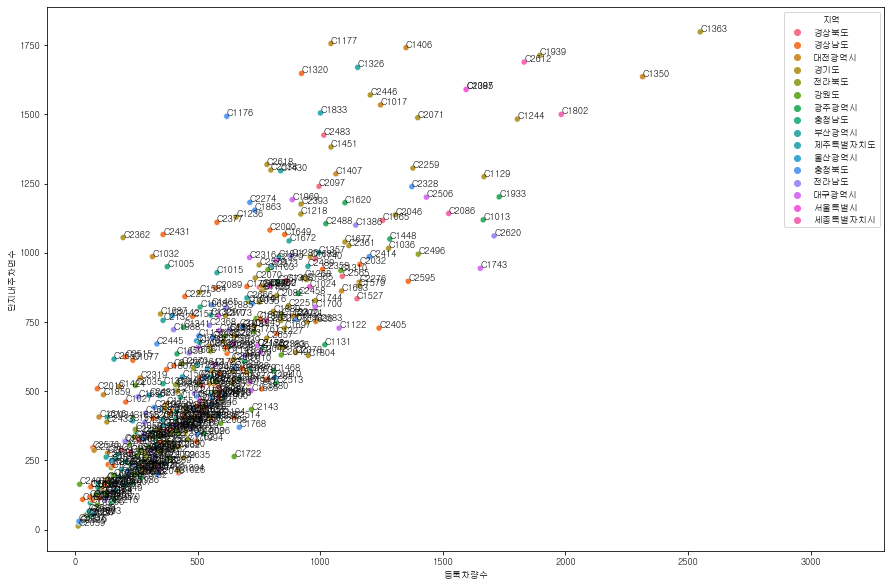

In [652]:
plt.figure(figsize=(15, 10))
plots = sns.scatterplot(data=train_danji, x='등록차량수', y='단지내주차면수', hue='지역')
for i, code in enumerate(train_danji['단지코드']):
    plots.annotate(code, (train_danji['등록차량수'][i], train_danji['단지내주차면수'][i]))
plt.xlim(right=3300)
plt.show()

In [653]:
train_danji.loc[train_danji['단지코드'] == 'C2362']

단지코드  총세대수   지역   공가수  지하철   버스  단지내주차면수  등록차량수
396  C2362  1509  경기도  46.0  0.0  2.0   1055.0  196.0

In [654]:
train.loc[train['단지코드'] == 'C2362']

단지코드  총세대수 임대건물구분   지역  공급유형   전용면적  전용면적별세대수   공가수 자격유형     임대보증금  \
2795  C2362  1509    아파트  경기도  행복주택  21.96       144  46.0    J  19760000   
2796  C2362  1509    아파트  경기도  행복주택  21.96       144  46.0    J  19760000   
2797  C2362  1509    아파트  경기도  행복주택  21.97       188  46.0    J  19760000   
2798  C2362  1509    아파트  경기도  행복주택  21.98        36  46.0    J  19360000   
2799  C2362  1509    아파트  경기도  행복주택  21.99        24  46.0    J  19360000   
2800  C2362  1509    아파트  경기도  행복주택  26.85        48  46.0    J  23520000   
2801  C2362  1509    아파트  경기도  행복주택  26.85        48  46.0    J  23520000   
2802  C2362  1509    아파트  경기도  행복주택  26.86       382  46.0    J  23520000   
2803  C2362  1509    아파트  경기도  행복주택  26.90         8  46.0    J  23520000   
2804  C2362  1509    아파트  경기도  행복주택  26.90        40  46.0    J  23520000   
2805  C2362  1509    아파트  경기도  행복주택  26.90        12  46.0    J  23520000   
2806  C2362  1509    아파트  경기도  행복주택  36.71        24  46.0    J  31880000   
2807  C2362  1509    아파트  경기도  행복주택  36.71        26  46.0    J  31880000   
2808  C2362  1509    아파트  경기도  행복주택  36.90       376  46.0    J  31880000   

         임대료  지하철   버스  단지내주차면수  등록차량수  
2795   83000  0.0  2.0   1055.0  196.0  
2796   83000  0.0  2.0   1055.0  196.0  
2797   83000  0.0  2.0   1055.0  196.0  
2798   82000  0.0  2.0   1055.0  196.0  
2799   82000  0.0  2.0   1055.0  196.0  
2800   99000  0.0  2.0   1055.0  196.0  
2801   99000  0.0  2.0   1055.0  196.0  
2802   99000  0.0  2.0   1055.0  196.0  
2803   99000  0.0  2.0   1055.0  196.0  
2804   99000  0.0  2.0   1055.0  196.0  
2805   99000  0.0  2.0   1055.0  196.0  
2806  135000  0.0  2.0   1055.0  196.0  
2807  135000  0.0  2.0   1055.0  196.0  
2808  135000  0.0  2.0   1055.0  196.0

### 산점도(총세대수, 주차면수)

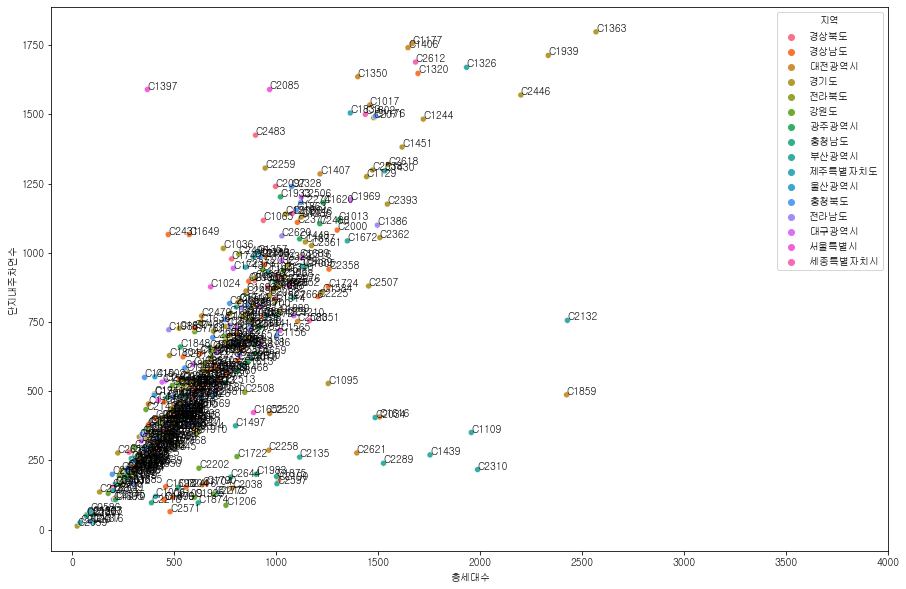

In [429]:
plt.figure(figsize=(15, 10))
plots = sns.scatterplot(data=train_danji, x='총세대수', y='단지내주차면수', hue='지역')
for i, code in enumerate(train_danji['단지코드']):
    plots.annotate(code, (train_danji['총세대수'][i], train_danji['단지내주차면수'][i]))
plt.xlim(right=4000)
plt.show()

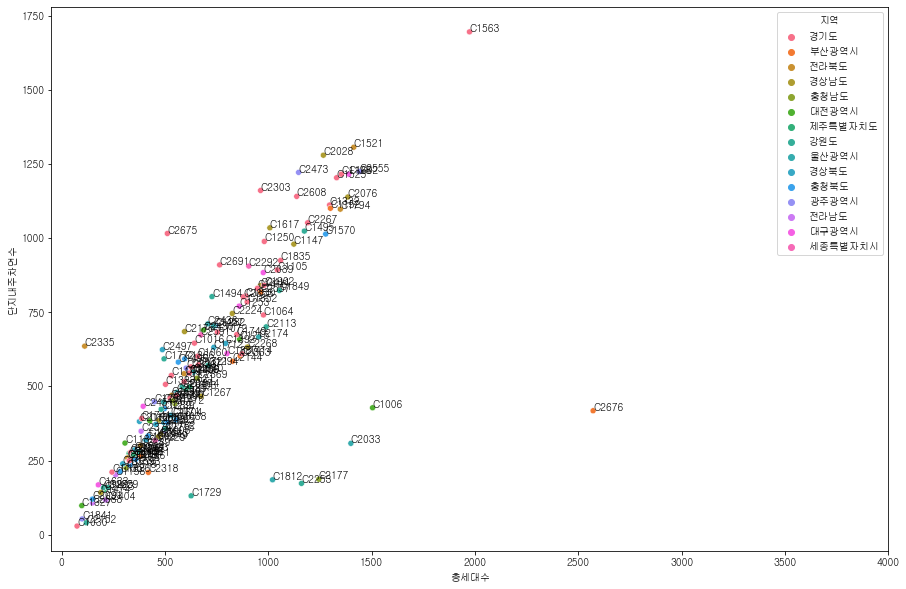

In [430]:
plt.figure(figsize=(15, 10))
plots = sns.scatterplot(data=test_danji, x='총세대수', y='단지내주차면수', hue='지역')
for i, code in enumerate(test_danji['단지코드']):
    plots.annotate(code, (test_danji['총세대수'][i], test_danji['단지내주차면수'][i]))
plt.xlim(right=4000)
plt.show()

- 이게 말이 되나? 세대수가 100개 남짓인데 주차면수가 600개인 곳이 있고
- 세대수가 2500호가 넘는데 주차면수가 400 남짓이다? 이게 상식적으로 말이 되나?
- 법정 주차대수가 존재하기 때문에 최소한의 미니멈 주차면수가 있어야 하는데, 이게 말이 되나?

건축연면적을 따져봅시다.

### 산점도(건축연면적, 주차면수)

In [568]:
train['건축연면적'] = train['전용면적'] * train['전용면적별세대수']
test['건축연면적'] = test['전용면적'] * test['전용면적별세대수']

In [569]:
temp = train.groupby(['단지코드']).sum().reset_index()
train_size = pd.merge(train_danji, temp[['단지코드', '건축연면적']], how='inner', on='단지코드')

In [570]:
temp = test.groupby(['단지코드']).sum().reset_index()
test_size = pd.merge(test_danji, temp[['단지코드', '건축연면적']], how='inner', on='단지코드')

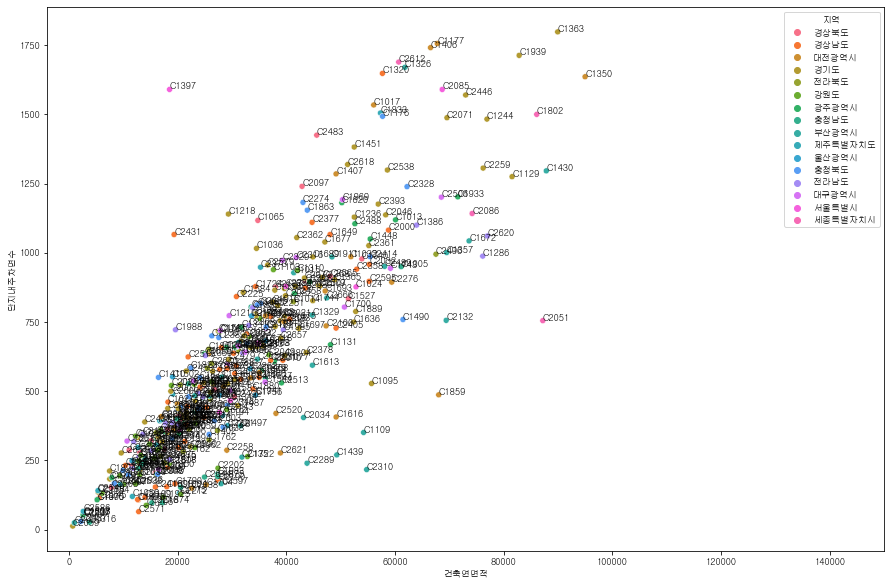

In [571]:
plt.figure(figsize=(15, 10))
plots = sns.scatterplot(data=train_size, x='건축연면적', y='단지내주차면수', hue='지역')
for i, code in enumerate(train_size['단지코드']):
    plots.annotate(code, (train_size['건축연면적'][i], train_size['단지내주차면수'][i]))
plt.xlim(right=150000)
plt.show()

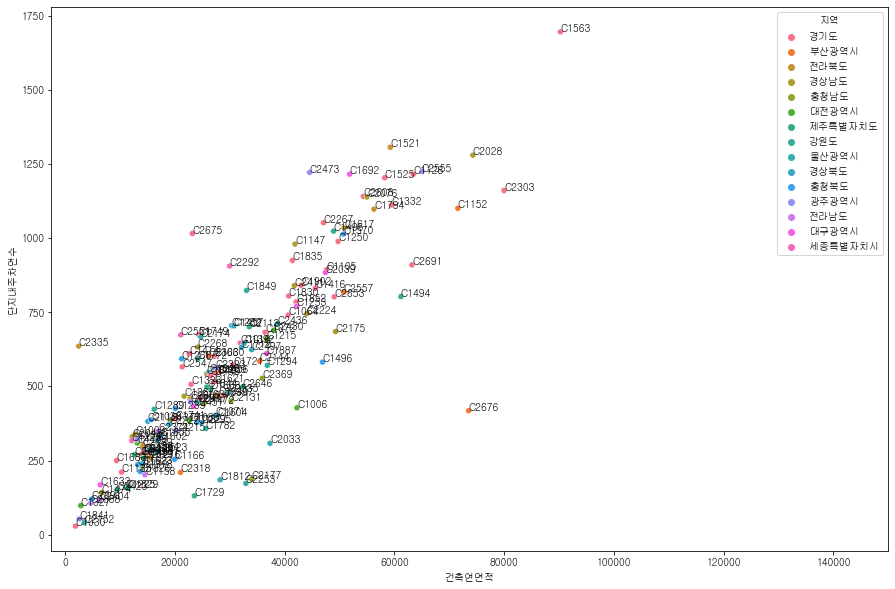

In [435]:
plt.figure(figsize=(15, 10))
plots = sns.scatterplot(data=test_size, x='건축연면적', y='단지내주차면수', hue='지역')
for i, code in enumerate(test_size['단지코드']):
    plots.annotate(code, (test_size['건축연면적'][i], test_size['단지내주차면수'][i]))
plt.xlim(right=150000)
plt.show()

건축연면적으로 따져도 추세선을 벗어나는 단지가 몇 개 있습니다.

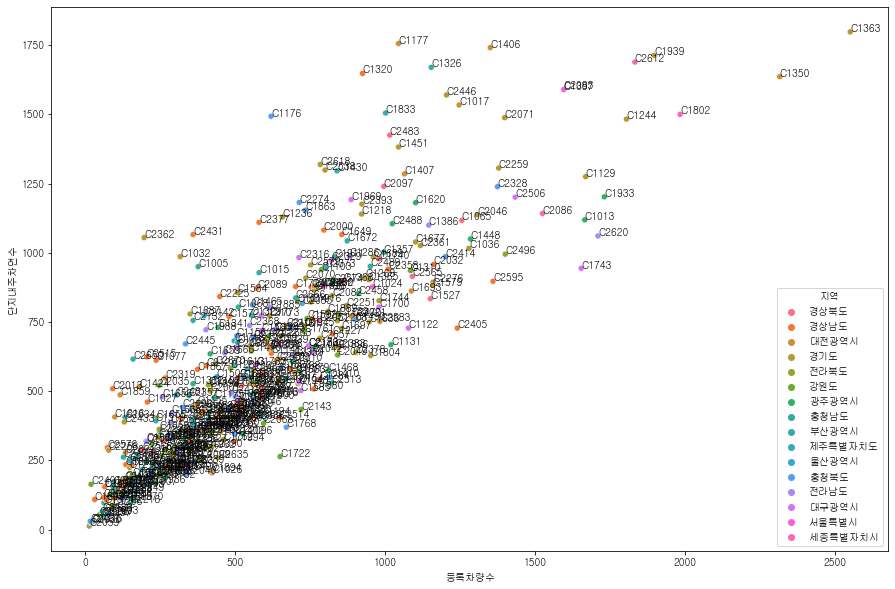

In [436]:
plt.figure(figsize=(15, 10))
plots = sns.scatterplot(data=train_danji, x='등록차량수', y='단지내주차면수', hue='지역')
for i, code in enumerate(train_danji['단지코드']):
    plots.annotate(code, (train_danji['등록차량수'][i], train_danji['단지내주차면수'][i]))
plt.show()

### 레그플롯-지역별(총세대수, 주차면수)

지역별로 살펴봐야겠습니다. 지역별로 법정주차대수가 다르기 때문에 그래프가 다르게 나타날 수 있습니다.

In [437]:
train_danji.head()

단지코드  총세대수     지역   공가수  지하철   버스  단지내주차면수   등록차량수
0  C2483   900   경상북도  38.0  0.0  3.0   1425.0  1015.0
1  C2515   545   경상남도  17.0  0.0  3.0    624.0   205.0
2  C1407  1216  대전광역시  13.0  1.0  1.0   1285.0  1064.0
3  C1945   755    경기도   6.0  1.0  3.0    734.0   730.0
4  C1470   696   전라북도  14.0  0.0  2.0    645.0   553.0

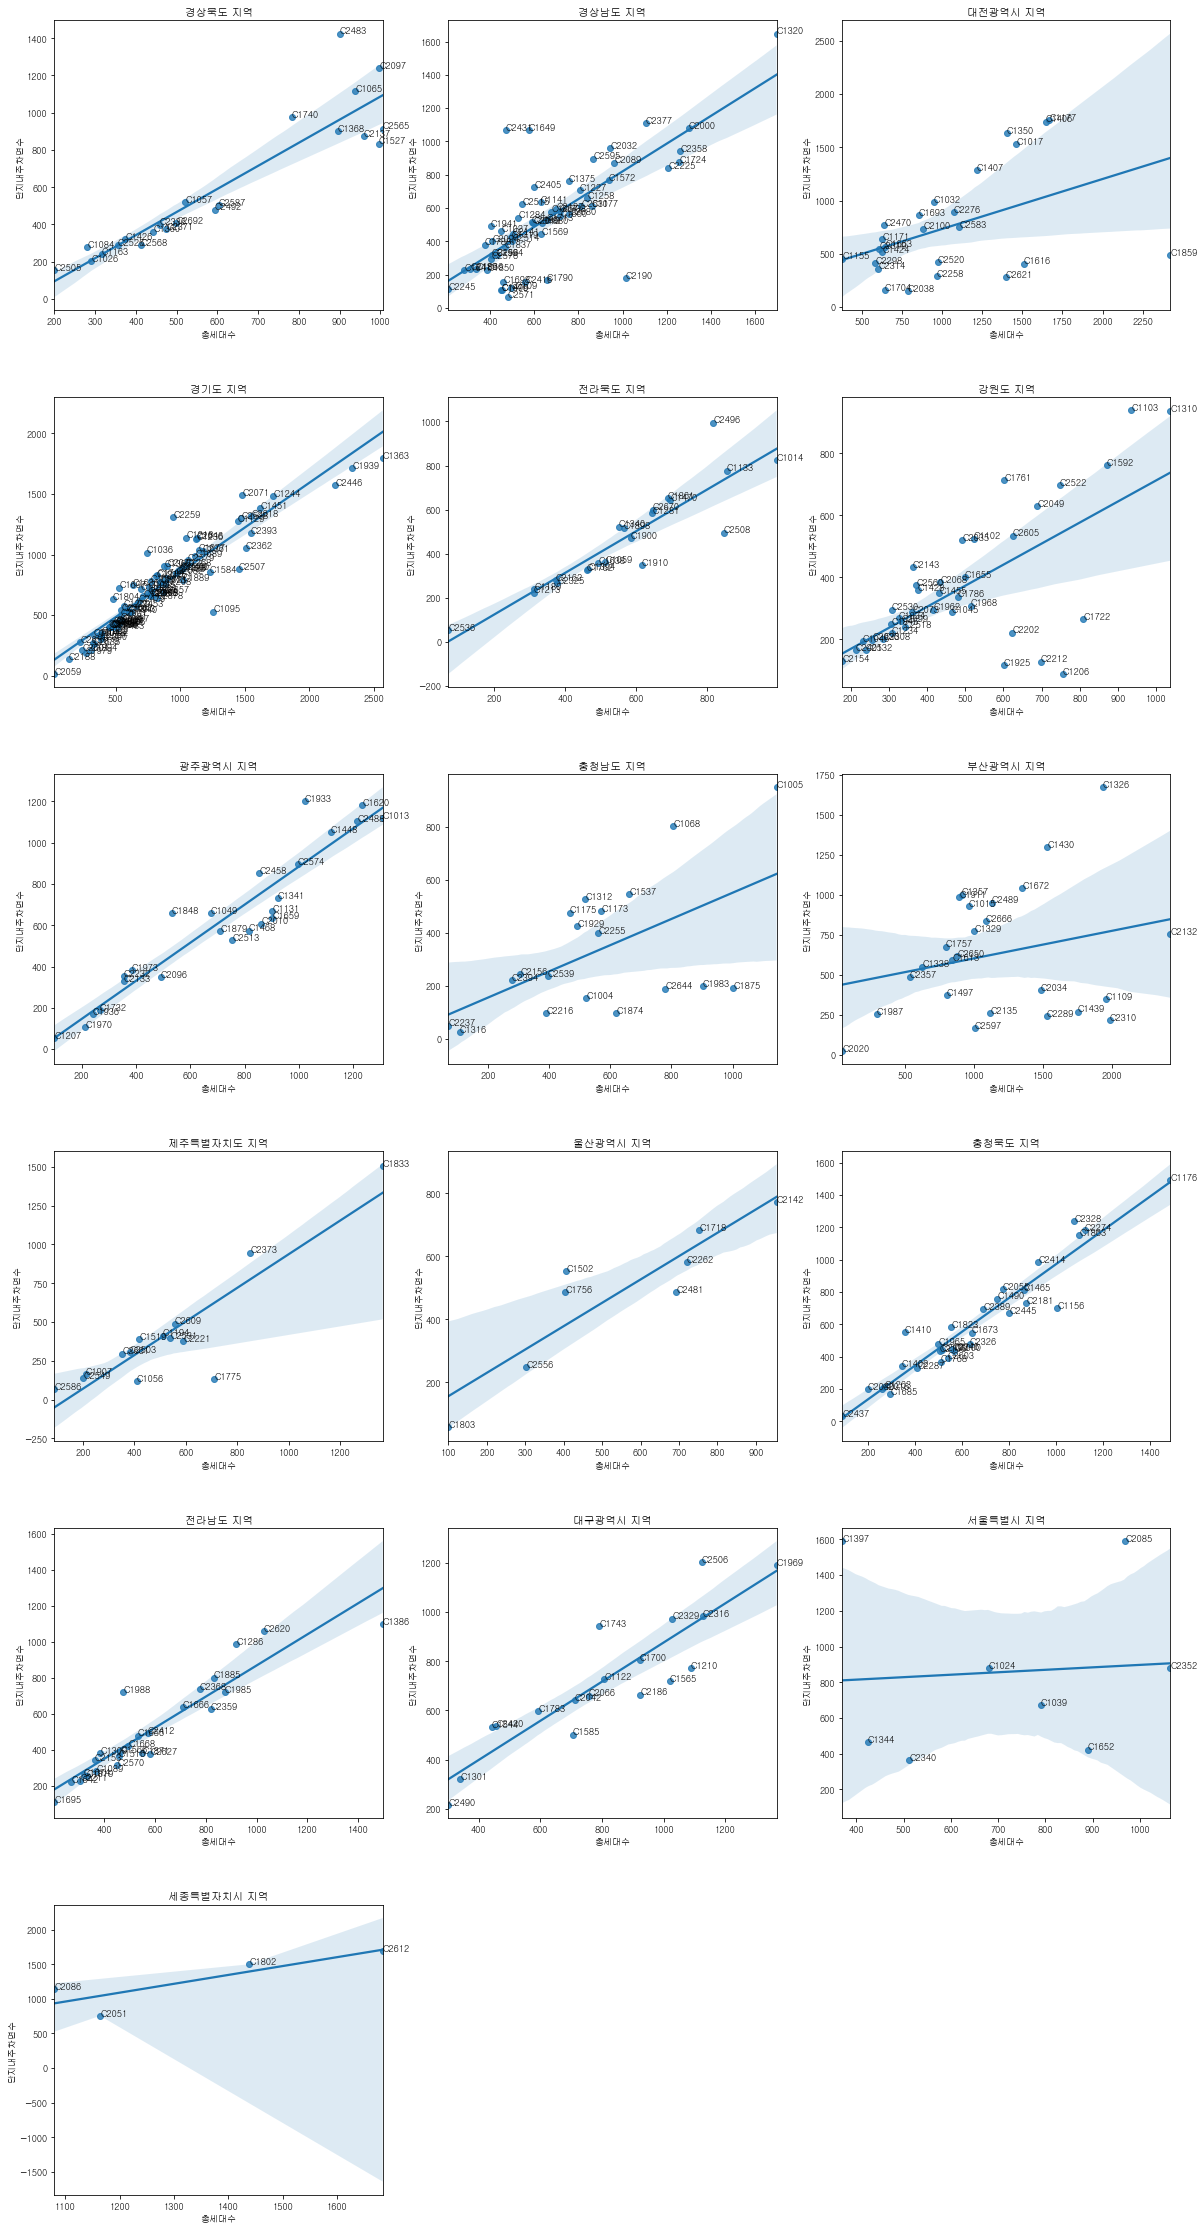

In [720]:
fig = plt.figure(figsize=(20, 40))
for i, n in enumerate(list(train_danji['지역'].unique())):
    plt.subplot(6, 3, i+1)
    plt.subplots_adjust(hspace=0.3)
    plots = sns.regplot(data=train_danji.loc[train_danji['지역'] == n], x='총세대수', y='단지내주차면수')
    for i, code in enumerate(train_danji.loc[train_danji['지역'] == n].reset_index(drop=True)['단지코드']):
        plots.annotate(code, (train_danji.loc[train_danji['지역'] == n].reset_index(drop=True)['총세대수'][i],
                              train_danji.loc[train_danji['지역'] == n].reset_index(drop=True)['단지내주차면수'][i]))
    plt.title('{} 지역'.format(n))

- 보통은 법정주차대수 때문에 총세대수와 주차면수는 곧은 선형관계를 띄게 되어 있습니다.
- 그런데 우측 하단에 그 관계를 벗어나는 군집이 나타납니다. 대전, 강원도, 충남, 부산이 특히 그렇습니다.
- 가설은 아주 오래된 아파트이거나, 자차를 소유하지 않은 주민들이 많이 사는 지역일 가능성입니다.
- 또 특이한 지역은 서울과 세종인데, 세종은 데이터가 많지 않아서 그렇다 쳐도 서울은 그냥 중구난방입니다.
- 서울은 아마도 구별로 패턴이 많이 달라서 그런 것 같습니다.

In [439]:
train_danji.loc[train_danji['지역'] == '서울특별시']

단지코드  총세대수     지역   공가수  지하철   버스  단지내주차면수   등록차량수
145  C2340   512  서울특별시  15.0  0.0  3.0    362.0   382.0
260  C1344   424  서울특별시   0.0  0.0  3.0    467.0   509.0
274  C1397   370  서울특별시   9.0  0.0  3.0   1590.0  1595.0
279  C2352  1065  서울특별시   7.0  0.0  4.0    879.0   793.0
282  C1039   790  서울특별시  13.0  0.0  3.0    673.0   645.0
292  C1024   680  서울특별시   2.0  0.0  3.0    877.0   957.0
297  C2085   969  서울특별시   0.0  0.0  3.0   1590.0  1595.0
380  C1652   890  서울특별시  20.0  1.0  8.0    423.0   509.0

In [440]:
train.loc[train['단지코드'] == 'C1397']

단지코드  총세대수 임대건물구분     지역  공급유형   전용면적  전용면적별세대수  공가수 자격유형      임대보증금  \
2043  C1397   370    아파트  서울특별시  장기전세  23.32        51  9.0    A   87444000   
2044  C1397   370    아파트  서울특별시  장기전세  46.79         4  9.0    A  174888000   
2045  C1397   370    아파트  서울특별시  장기전세  46.91        69  9.0    A  174888000   
2046  C1397   370    아파트  서울특별시  장기전세  51.96        24  9.0    A  194562000   
2047  C1397   370    아파트  서울특별시  장기전세  51.99        80  9.0    A  194562000   
2048  C1397   370    아파트  서울특별시  장기전세  59.93       142  9.0    A  216423000   

     임대료  지하철   버스  단지내주차면수   등록차량수    건축연면적  
2043   -  0.0  3.0   1590.0  1595.0  1189.32  
2044   -  0.0  3.0   1590.0  1595.0   187.16  
2045   -  0.0  3.0   1590.0  1595.0  3236.79  
2046   -  0.0  3.0   1590.0  1595.0  1247.04  
2047   -  0.0  3.0   1590.0  1595.0  4159.20  
2048   -  0.0  3.0   1590.0  1595.0  8510.06

- 아무리 서울이라도 370세대에 단지내주차면수가 1590대는 심합니다. 심지어 전용면적도 85가 안됩니다. 법정주차대수로는 400대도 안됩니다.

- LH강남힐스테이트아파트. 총 1339세대가 살고 있는 대단지입니다. 이렇게 따지면 총세대수, 전용면적별세대수, 건축연면적 전부 소음입니다.
- 아니 그렇다고 저 컬럼을 버릴 수는 없어요. 그럼 버려야 할 것은 선형관계에서 벗어나는 세대들입니다.

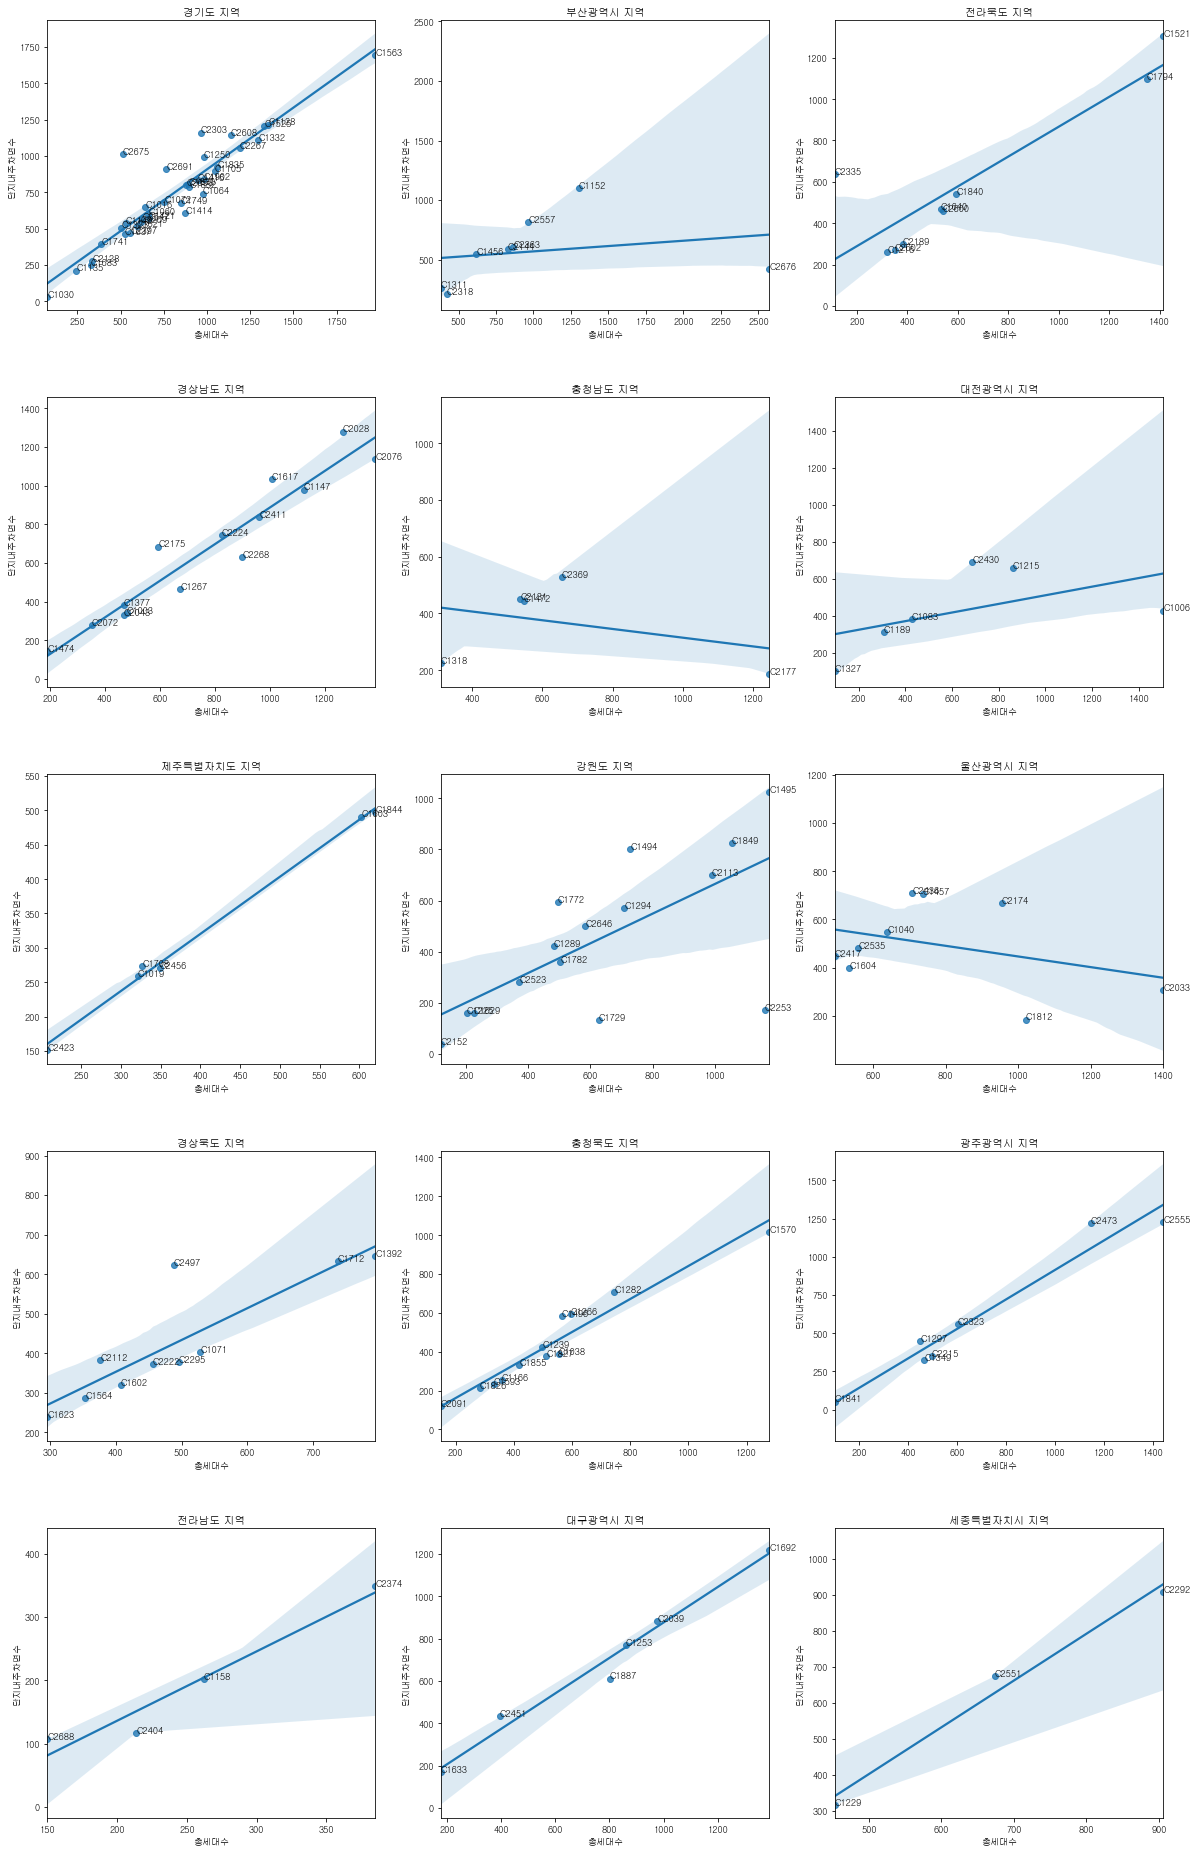

In [721]:
fig = plt.figure(figsize=(20, 40))
for i, n in enumerate(list(test_danji['지역'].unique())):
    plt.subplot(6, 3, i+1)
    plt.subplots_adjust(hspace=0.3)
    plots = sns.regplot(data=test_danji.loc[test_danji['지역'] == n], x='총세대수', y='단지내주차면수')
    for i, code in enumerate(test_danji.loc[test_danji['지역'] == n].reset_index(drop=True)['단지코드']):
        plots.annotate(code, (test_danji.loc[test_danji['지역'] == n].reset_index(drop=True)['총세대수'][i],
                              test_danji.loc[test_danji['지역'] == n].reset_index(drop=True)['단지내주차면수'][i]))
    plt.title('{} 지역'.format(n))

### 산점도-지역별(건축연면적, 주차면수)

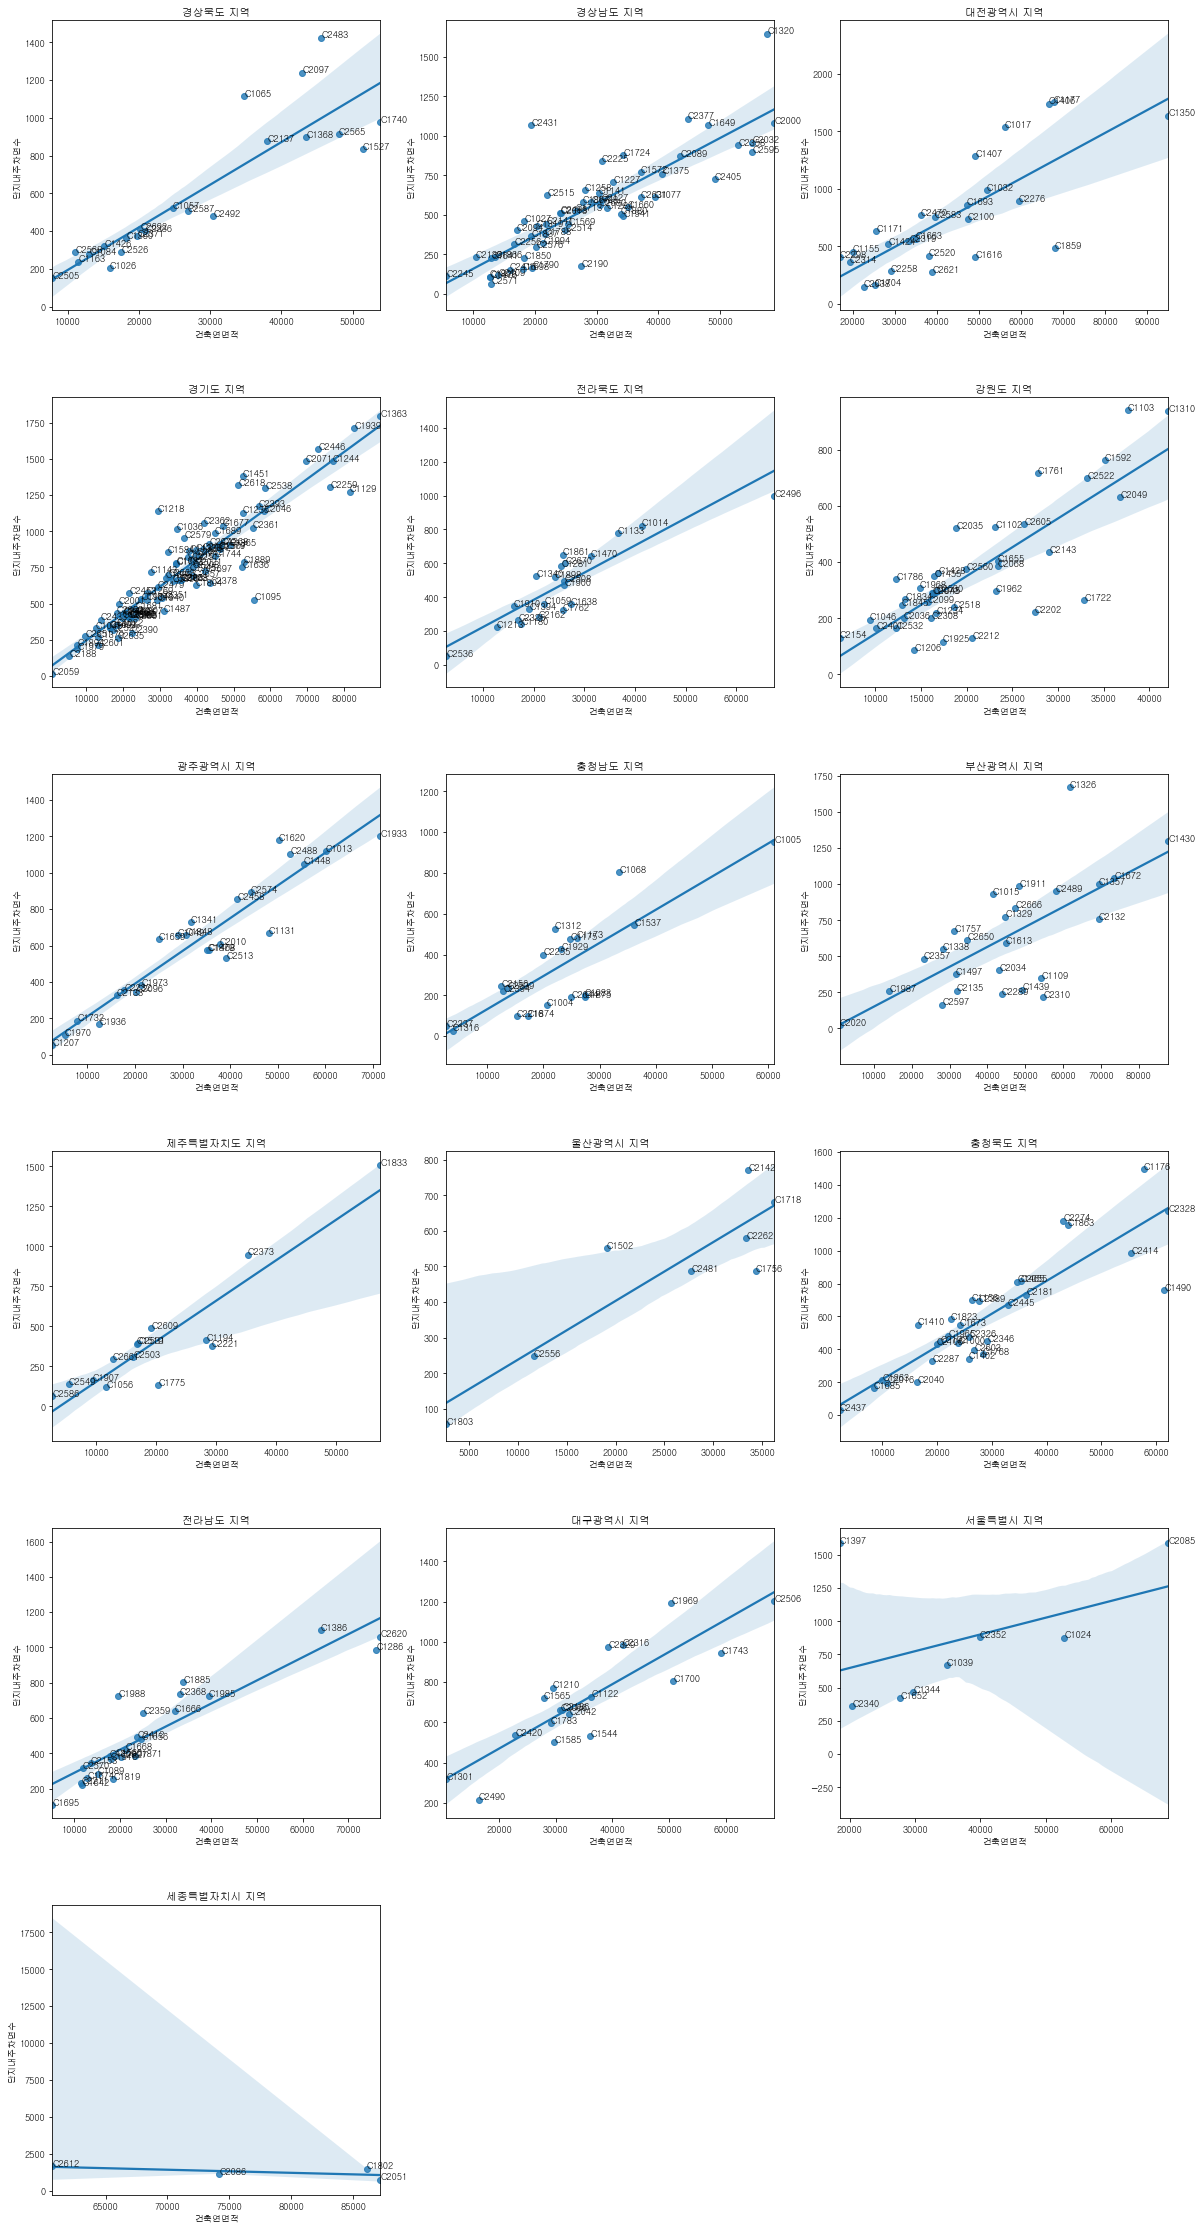

In [722]:
fig = plt.figure(figsize=(20, 40))
for i, n in enumerate(list(train_size['지역'].unique())):
    plt.subplot(6, 3, i+1)
    plt.subplots_adjust(hspace=0.3)
    plots = sns.regplot(data=train_size.loc[train_size['지역'] == n], x='건축연면적', y='단지내주차면수')
    for i, code in enumerate(train_size.loc[train_size['지역'] == n].reset_index(drop=True)['단지코드']):
        plots.annotate(code, (train_size.loc[train_size['지역'] == n].reset_index(drop=True)['건축연면적'][i],
                              train_size.loc[train_size['지역'] == n].reset_index(drop=True)['단지내주차면수'][i]))
    plt.title('{} 지역'.format(n))

- 건축연면적으로 따지면 또 서울은 아웃라이어는 1397단지 뿐이기도 합니다.

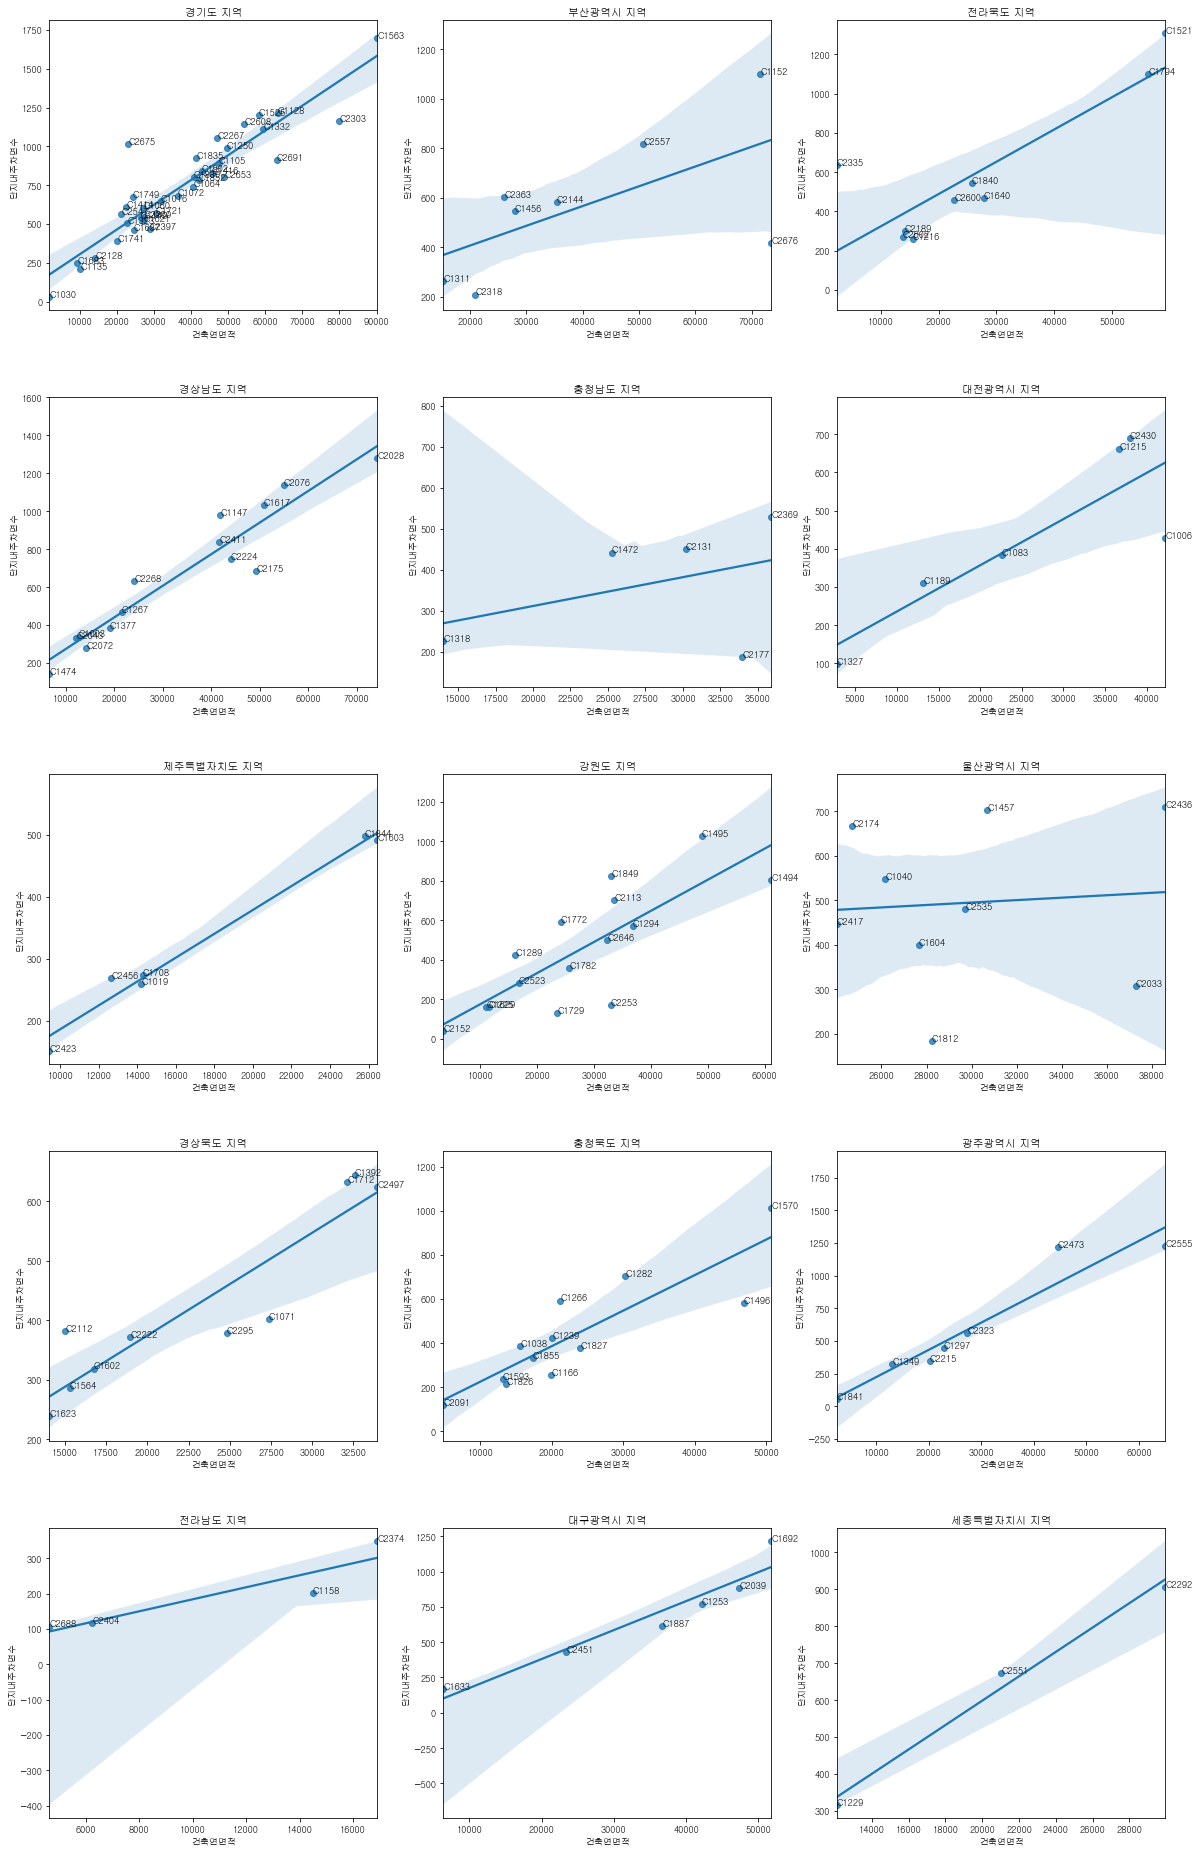

In [723]:
fig = plt.figure(figsize=(20, 40))
for i, n in enumerate(list(test_size['지역'].unique())):
    plt.subplot(6, 3, i+1)
    plt.subplots_adjust(hspace=0.3)
    plots = sns.regplot(data=test_size.loc[test_size['지역'] == n], x='건축연면적', y='단지내주차면수')
    for i, code in enumerate(test_size.loc[test_size['지역'] == n].reset_index(drop=True)['단지코드']):
        plots.annotate(code, (test_size.loc[test_size['지역'] == n].reset_index(drop=True)['건축연면적'][i],
                              test_size.loc[test_size['지역'] == n].reset_index(drop=True)['단지내주차면수'][i]))
    plt.title('{} 지역'.format(n))

근데 또 예측해야 하는 단지에 비율이 맞지 않는 단지들이 존재한다는 것이죠

### 막대차트 (총세대수주차면수비 & 건축연면적주차면수비)

In [444]:
train_size['주차면수/총세대수'] = train_size['단지내주차면수'] / train_size['총세대수']
train_size['주차면수/건축연면적'] = (train_size['단지내주차면수'] / train_size['건축연면적']) * 100

test_size['주차면수/총세대수'] = test_size['단지내주차면수'] / test_size['총세대수']
test_size['주차면수/건축연면적'] = (test_size['단지내주차면수'] / test_size['건축연면적']) * 100

In [445]:
train_size.nlargest(5, '주차면수/총세대수')

단지코드  총세대수     지역   공가수  지하철   버스  단지내주차면수   등록차량수     건축연면적  주차면수/총세대수  \
274  C1397   370  서울특별시   9.0  0.0  3.0   1590.0  1595.0  18529.57   4.297297   
327  C2431   472   경상남도  16.0  0.0  2.0   1066.0   359.0  19357.44   2.258475   
318  C1649   575   경상남도  15.0  0.0  7.0   1066.0   855.0  48053.20   1.853913   
297  C2085   969  서울특별시   0.0  0.0  3.0   1590.0  1595.0  68694.64   1.640867   
0    C2483   900   경상북도  38.0  0.0  3.0   1425.0  1015.0  45605.89   1.583333   

     주차면수/건축연면적  
274    8.580879  
327    5.506927  
318    2.218375  
297    2.314591  
0      3.124596

In [446]:
train_size.nsmallest(5, '주차면수/총세대수')

단지코드  총세대수     지역   공가수  지하철   버스  단지내주차면수  등록차량수     건축연면적  주차면수/총세대수  \
44  C2310  1988  부산광역시   1.0  0.0  2.0    217.0  189.0  54798.29   0.109155   
53  C1206   755    강원도   1.0  0.0  4.0     88.0   90.0  14243.80   0.116556   
71  C2571   481   경상남도   5.0  0.0  1.0     65.0   62.0  12849.89   0.135135   
47  C1439  1755  부산광역시  29.0  1.0  3.0    270.0  172.0  49294.74   0.153846   
16  C1874   619   충청남도   2.0  0.0  2.0     97.0   62.0  17191.41   0.156704   

    주차면수/건축연면적  
44    0.395998  
53    0.617813  
71    0.505841  
47    0.547726  
16    0.564235

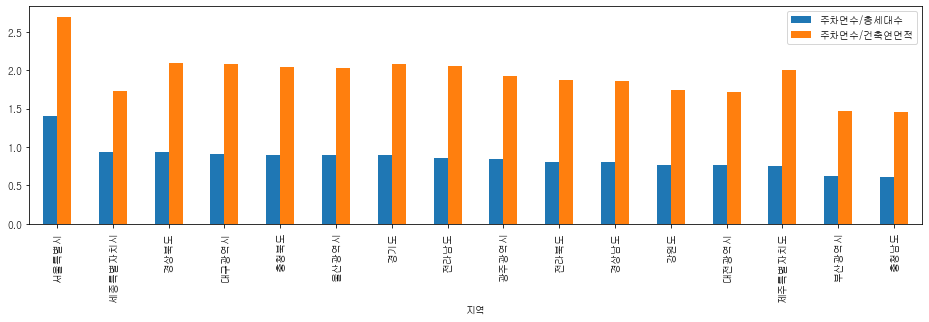

In [447]:
(train_size
 .groupby(['지역'])[['주차면수/총세대수', '주차면수/건축연면적']]
 .mean()
 .sort_values(by='주차면수/총세대수', ascending=False)
 .plot(kind='bar', figsize=(16, 4)))
plt.show()

- 두 비가 다 높은 서울시는 주어진 총세대수와 건축연면적에 비해 주차면수가 높게 형성되어 있다는 뜻입니다.
- 세종은 총세대수에 대한 주차면수는 높지만, 건축연면적에 비해서는 낮습니다.
- 보통 총세대수가 많으면 건축연면적도 높습니다. 그래서 비율이 비슷하게 가는 것이 보통입니다.
- 세종같은 경우는 총세대수에 비해 건축연면적이 높은 편이라는 뜻이고, 이는 대형평형수가 많다는 의미입니다.
- 총세대수주차면수비에 비해 건축연면적주차면수비가 높은 경기도 같은 경우는 반대라는 것입니다.

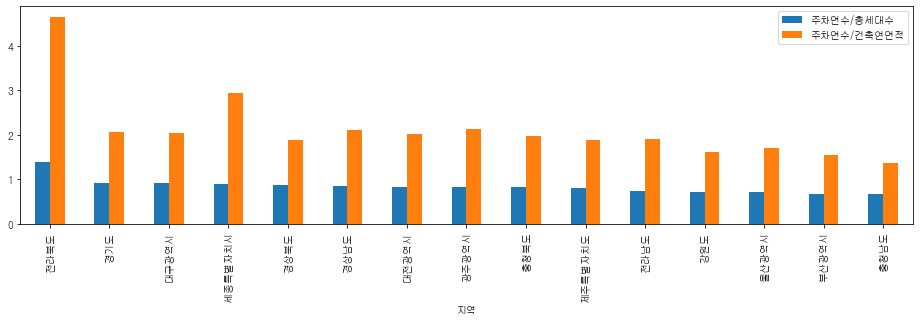

In [448]:
(test_size
 .groupby(['지역'])[['주차면수/총세대수', '주차면수/건축연면적']]
 .mean()
 .sort_values(by='주차면수/총세대수', ascending=False)
 .plot(kind='bar', figsize=(16, 4)))
plt.show()

- 근데 또 테스트 데이터에서는 반대로 나타납니다. 세종의 건축연면적주차면수비가 높게 형성됩니다. 그리고 경기도는 오히려 낮게 나타나죠.
- 정말 뒤죽박죽 데이터입니다.

In [449]:
train_size['등록차량수/총세대수'] = train_size['등록차량수'] / train_size['총세대수']
train_size['등록차량수/건축연면적'] = (train_size['등록차량수'] / train_size['건축연면적']) * 50
train_size['등록차량수/주차면수'] = train_size['등록차량수'] / train_size['단지내주차면수']

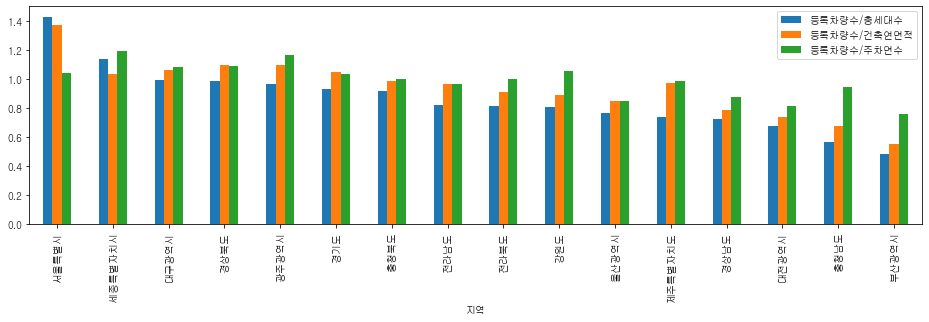

In [450]:
(train_size
 .groupby(['지역'])[['등록차량수/총세대수', '등록차량수/건축연면적', '등록차량수/주차면수']]
 .mean()
 .sort_values(by='등록차량수/총세대수', ascending=False)
 .plot(kind='bar', figsize=(16, 4)))
plt.show()

### 공급유형 바차트

공급유형을 살펴봐야겠습니다.

In [451]:
train_reqruit = pd.pivot_table(train, index='단지코드', columns='공급유형', values='전용면적별세대수', aggfunc=np.sum, fill_value=0)
train_reqruit.head()

공급유형   공공분양  공공임대(10년)  공공임대(50년)  공공임대(5년)  공공임대(분납)  국민임대  영구임대  임대상가  장기전세  \
단지코드                                                                            
C1000     0          0          0         0         0   566     0     0     0   
C1004     0          0          0         0         0     0   504    17     0   
C1005     0          0          0         0         0  1144     0     0     0   
C1013     0          0          0         0         0  1308     0     0     0   
C1014     0          0          0         0         0   996     0     0     0   

공급유형   행복주택  
단지코드         
C1000     0  
C1004     0  
C1005     0  
C1013     0  
C1014     0

In [452]:
train_reqruit2 = pd.merge(train_reqruit.reset_index(), train[['단지코드', '지역', '단지내주차면수']],
                          how='inner', on='단지코드').drop_duplicates().set_index('단지코드')

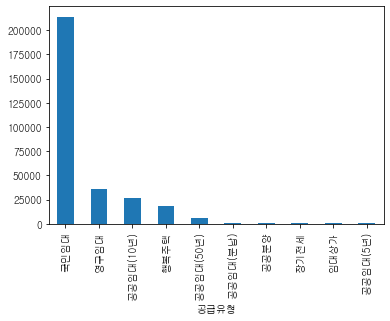

In [453]:
train_reqruit.sum(axis=0).sort_values(ascending=False).plot(kind='bar')
plt.show()

- 국민임대가 20만호가 넘으며 압도적인 비중입니다. 그 뒤로 영구임대, 공공임대, 행복주택 등이 있습니다.

In [454]:
train_reqruit2.nlargest(5, '공공분양')

공공분양  공공임대(10년)  공공임대(50년)  공공임대(5년)  공공임대(분납)  국민임대  영구임대  임대상가  장기전세  \
단지코드                                                                            
C1350   711        342          0         0       348     0     0     0     0   
C2470   230          0          0       406         0     0     0     0     0   
C1000     0          0          0         0         0   566     0     0     0   
C1004     0          0          0         0         0     0   504    17     0   
C1005     0          0          0         0         0  1144     0     0     0   

       행복주택     지역  단지내주차면수  
단지코드                         
C1350     0  대전광역시   1636.0  
C2470     0  대전광역시    772.0  
C1000     0   충청북도    438.0  
C1004     0   충청남도    153.0  
C1005     0   충청남도    950.0

In [455]:
train_reqruit2.nlargest(10, '공공임대(10년)')

공공분양  공공임대(10년)  공공임대(50년)  공공임대(5년)  공공임대(분납)  국민임대  영구임대  임대상가  장기전세  \
단지코드                                                                            
C1129     0       1444          0         0         0     0     0     0     0   
C1802     0       1438          0         0         0     0     0     0     0   
C2051     0       1164          0         0         0     0     0     0     0   
C2506     0       1124          0         0         0     0     0     0     0   
C2086     0       1080          0         0         0     0     0     0     0   
C2328     0       1077          0         0         0     0     0     0     0   
C2620     0       1029          0         0         0     0     0     0     0   
C1933     0       1022          0         0         0     0     0     0     0   
C2259     0        947          0         0         0     0     0     0     0   
C2414     0        924          0         0         0     0     0     0     0   

       행복주택       지역  단지내주차면수  
단지코드                           
C1129     0      경기도   1275.0  
C1802     0  세종특별자치시   1500.0  
C2051     0  세종특별자치시    755.0  
C2506     0    대구광역시   1201.0  
C2086     0  세종특별자치시   1142.0  
C2328     0     충청북도   1239.0  
C2620     0     전라남도   1061.0  
C1933     0    광주광역시   1202.0  
C2259     0      경기도   1306.0  
C2414     0     충청북도    986.0

In [456]:
train_reqruit2.nlargest(10, '공공임대(5년)')

공공분양  공공임대(10년)  공공임대(50년)  공공임대(5년)  공공임대(분납)  국민임대  영구임대  임대상가  장기전세  \
단지코드                                                                            
C2470   230          0          0       406         0     0     0     0     0   
C1000     0          0          0         0         0   566     0     0     0   
C1004     0          0          0         0         0     0   504    17     0   
C1005     0          0          0         0         0  1144     0     0     0   
C1013     0          0          0         0         0  1308     0     0     0   
C1014     0          0          0         0         0   996     0     0     0   
C1015     0          0          0         0         0   961     0     0     0   
C1017     0          0          0         0         0  1460     0     0     0   
C1022     0          0          0         0         0   389     0     0     0   
C1024     0        718          0         0         0     0     0     0     0   

       행복주택     지역  단지내주차면수  
단지코드                         
C2470     0  대전광역시    772.0  
C1000     0   충청북도    438.0  
C1004     0   충청남도    153.0  
C1005     0   충청남도    950.0  
C1013     0  광주광역시   1119.0  
C1014     0   전라북도    823.0  
C1015     0  부산광역시    928.0  
C1017     0  대전광역시   1534.0  
C1022     0    경기도    352.0  
C1024     0  서울특별시    877.0

In [457]:
train_reqruit2.nlargest(10, '공공임대(50년)')

공공분양  공공임대(10년)  공공임대(50년)  공공임대(5년)  공공임대(분납)  국민임대  영구임대  임대상가  장기전세  \
단지코드                                                                            
C2520     0          0        960         0         0     0     0     0     0   
C1497     0          0        802         0         0     0     0     0     0   
C1424     0          0        624         0         0     0     0     0     0   
C2202     0          0        623         0         0     0     0     0     0   
C2221     0          0        590         0         0     0     0     0     0   
C2340     0          0        512         0         0     0     0     0     0   
C1722     0          0        505         0         0     0   298     6     0   
C2216     0          0        390         0         0     0     0     0     0   
C2644     0          0        387         0         0     0   388     3     0   
C1850     0          0        385         0         0     0     0     0     0   

       행복주택       지역  단지내주차면수  
단지코드                           
C2520     0    대전광역시    420.0  
C1497     0    부산광역시    375.0  
C1424     0    대전광역시    517.0  
C2202     0      강원도    222.0  
C2221     0  제주특별자치도    376.0  
C2340     0    서울특별시    362.0  
C1722     0      강원도    264.0  
C2216     0     충청남도     97.0  
C2644     0     충청남도    190.0  
C1850     0     경상남도    226.0

In [458]:
req_cols = ['공공분양', '공공임대(10년)', '공공임대(50년)', '공공임대(5년)', '공공임대(분납)',
       '영구임대', '임대상가', '장기전세', '행복주택']

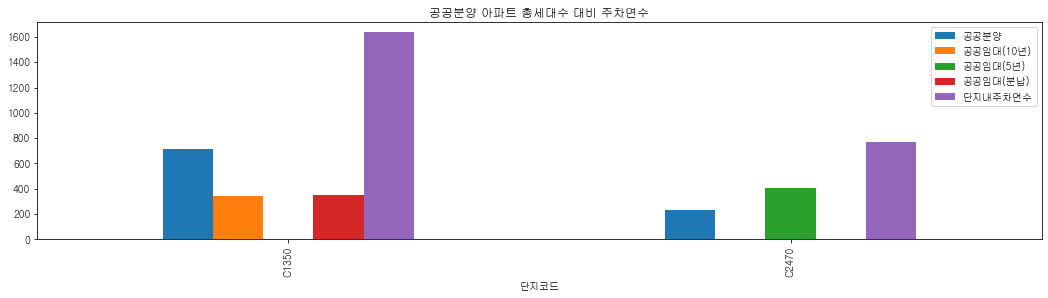

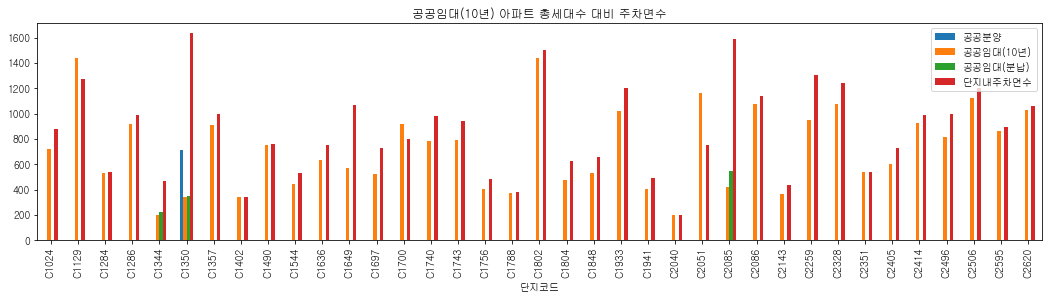

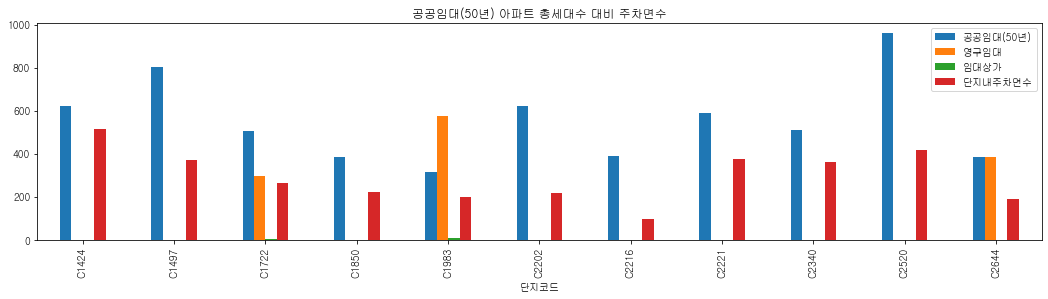

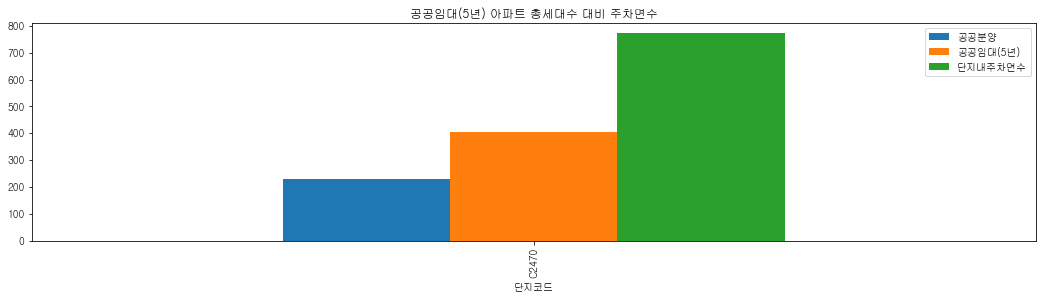

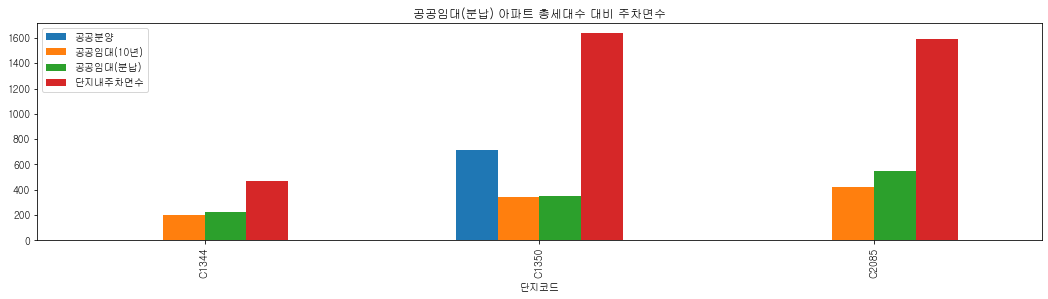

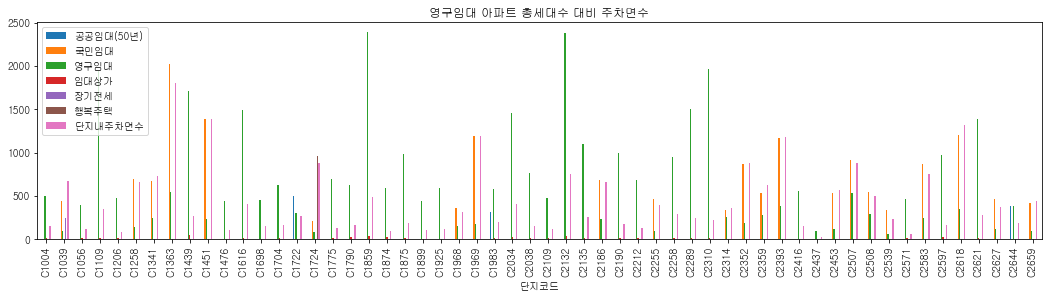

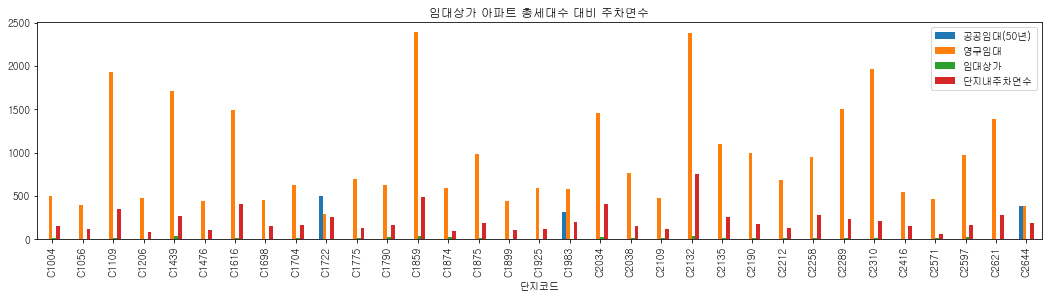

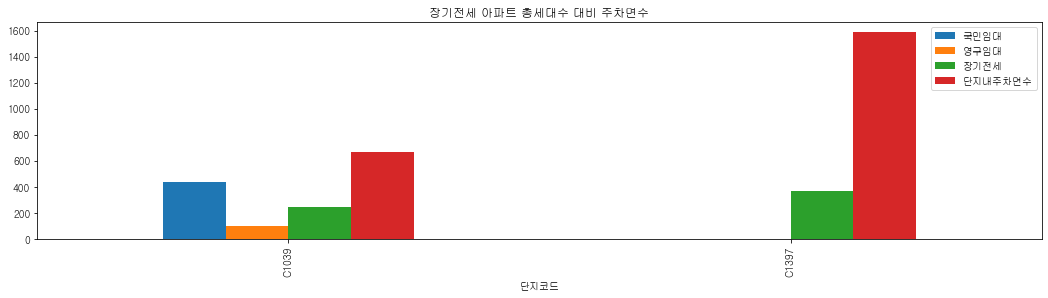

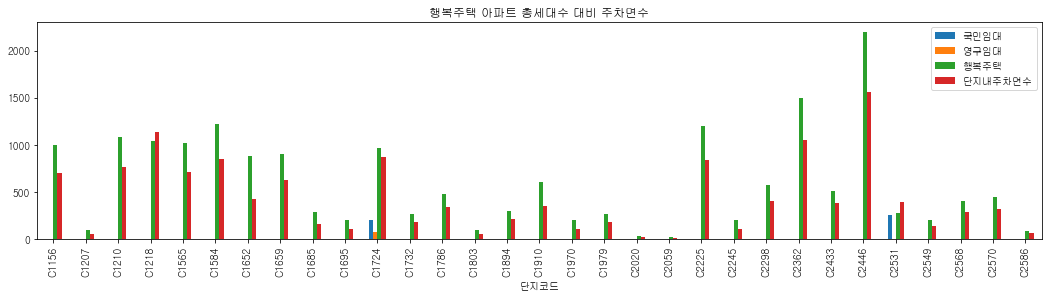

In [459]:
for col in req_cols:
    train_reqruit2.loc[train_reqruit2[col] != 0,
                      [x for x in train_reqruit2.columns if train_reqruit2.loc[train_reqruit2[col] != 0][x].sum() != 0]].plot(kind='bar', figsize=(18, 4))
    plt.title('{} 아파트 총세대수 대비 주차면수'.format(col))
    plt.show()

- 특이한 점이 많습니다.
1. 임대상가가 있는 아파트는 무조건 영구임대단지다. 총세대수에 비해 주차면수도 굉장히 적다.
2. 공공임대(50년)이 있는 단지는 주차면수가 총세대수에 비해 굉장히 적다.
3. 행복주택은 보통 행복주택만 있습니다.
4. 공공분양, 공공임대(5년), 장기전세는 단지가 너무 없습니다.

In [460]:
train_reqruit2.nlargest(10, '임대상가')

공공분양  공공임대(10년)  공공임대(50년)  공공임대(5년)  공공임대(분납)  국민임대  영구임대  임대상가  장기전세  \
단지코드                                                                            
C1439     0          0          0         0         0     0  1710    45     0   
C2132     0          0          0         0         0     0  2385    43     0   
C1859     0          0          0         0         0     0  2389    35     0   
C1790     0          0          0         0         0     0   627    30     0   
C2597     0          0          0         0         0     0   976    29     0   
C1874     0          0          0         0         0     0   592    27     0   
C2034     0          0          0         0         0     0  1460    26     0   
C1109     0          0          0         0         0     0  1937    20     0   
C2289     0          0          0         0         0     0  1507    20     0   
C2310     0          0          0         0         0     0  1968    20     0   

       행복주택     지역  단지내주차면수  
단지코드                         
C1439     0  부산광역시    270.0  
C2132     0  부산광역시    756.0  
C1859     0  대전광역시    487.0  
C1790     0   경상남도    166.0  
C2597     0  부산광역시    166.0  
C1874     0   충청남도     97.0  
C2034     0  부산광역시    405.0  
C1109     0  부산광역시    351.0  
C2289     0  부산광역시    240.0  
C2310     0  부산광역시    217.0

### 자격유형 바차트

In [461]:
train_qual = pd.pivot_table(train, index='단지코드', columns='자격유형', values='전용면적별세대수', aggfunc=np.sum, fill_value=0)
train_qual.head()

자격유형      A  B    C   D  E  F  G  H  I  J  K  L  M  N  O
단지코드                                                    
C1000   566  0    0   0  0  0  0  0  0  0  0  0  0  0  0
C1004     0  0  504  17  0  0  0  0  0  0  0  0  0  0  0
C1005  1144  0    0   0  0  0  0  0  0  0  0  0  0  0  0
C1013  1308  0    0   0  0  0  0  0  0  0  0  0  0  0  0
C1014   996  0    0   0  0  0  0  0  0  0  0  0  0  0  0

In [462]:
train_qual2 = pd.merge(train_qual.reset_index(),
                       train[['단지코드', '지역', '단지내주차면수']],
                       how='inner', on='단지코드').drop_duplicates().set_index('단지코드')

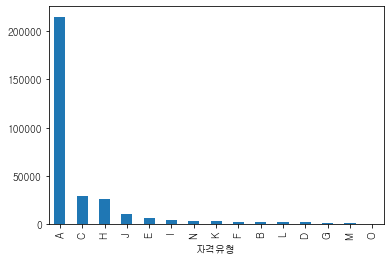

In [463]:
train_qual.sum(axis=0).sort_values(ascending=False).plot(kind='bar')
plt.show()

- A가 압도적으로 많습니다. C, H가 뒤를 잇습니다.

In [464]:
qual_cols = ['C', 'D', 'E', 'H', 'I', 'J', 'K', 'L']
qual_cols2 = ['M', 'N', 'O', 'F', 'B', 'G']

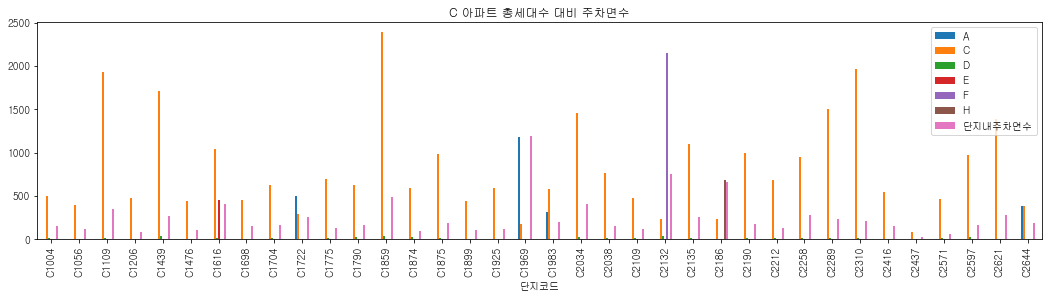

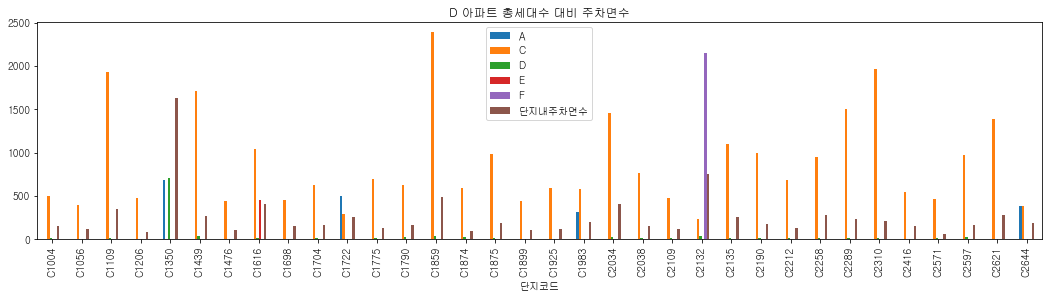

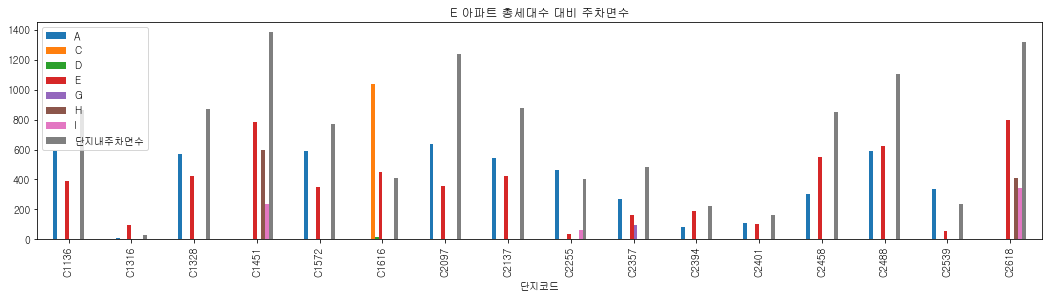

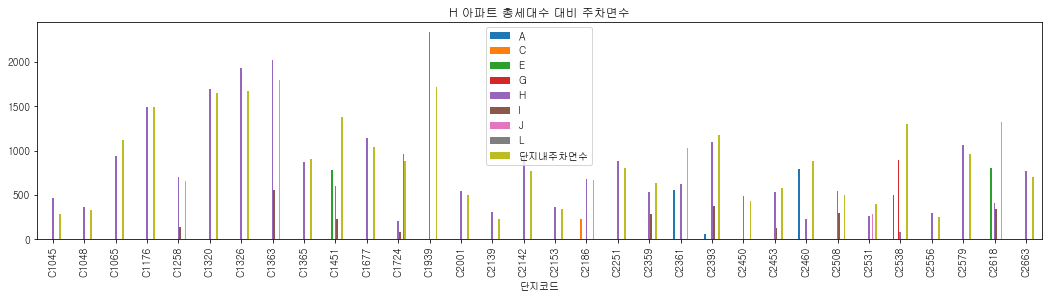

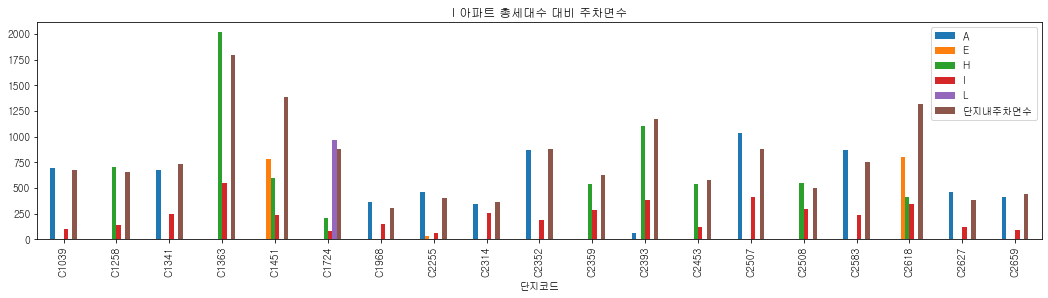

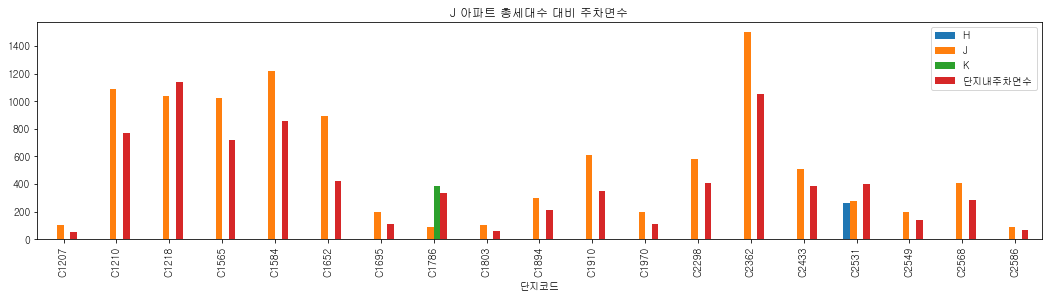

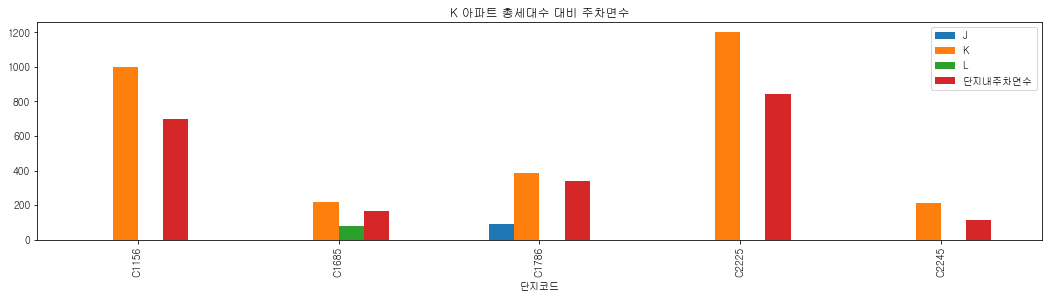

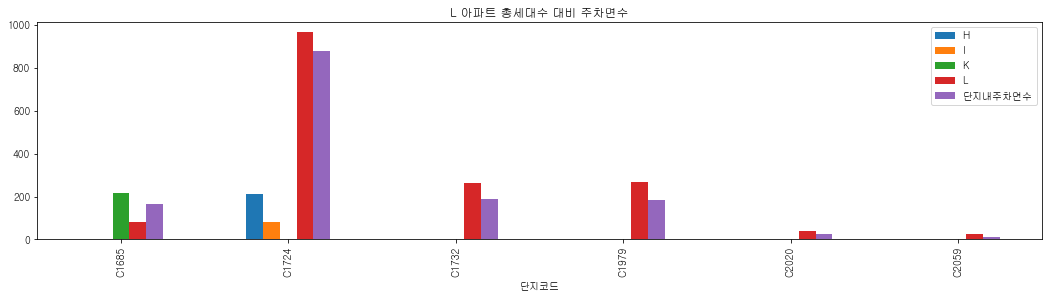

In [465]:
for col in qual_cols:
    train_qual2.loc[train_qual2[col] != 0,
                      [x for x in train_qual2.columns if train_qual2.loc[train_qual2[col] != 0][x].sum() != 0]].plot(kind='bar', figsize=(18, 4))
    plt.title('{} 아파트 총세대수 대비 주차면수'.format(col))
    plt.show()

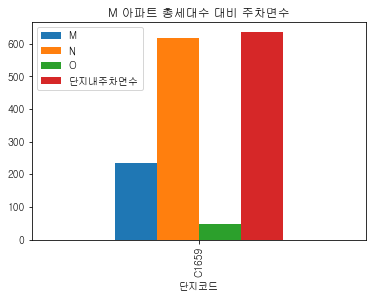

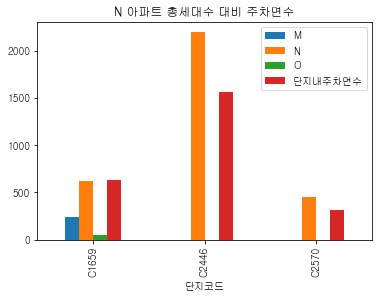

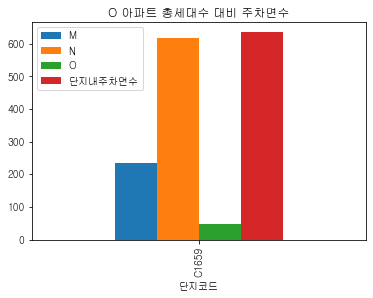

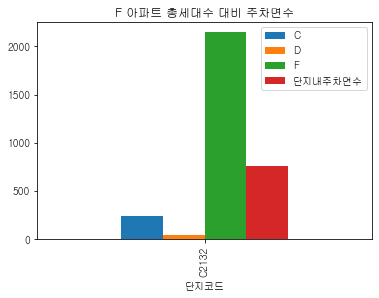

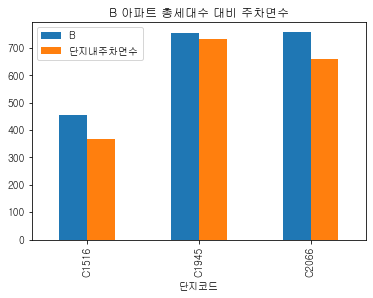

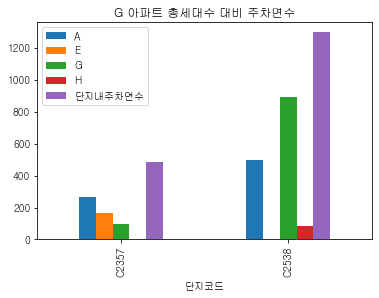

In [466]:
for col in qual_cols2:
    train_qual2.loc[train_qual2[col] != 0,
                      [x for x in train_qual2.columns if train_qual2.loc[train_qual2[col] != 0][x].sum() != 0]].plot(kind='bar', figsize=(6, 4))
    plt.title('{} 아파트 총세대수 대비 주차면수'.format(col))
    plt.show()

In [467]:
train_req_qual = pd.merge(train_qual, train_reqruit2.reset_index(), how='inner', on='단지코드').drop_duplicates().set_index('단지코드')
train_req_qual.head()

A  B    C   D  E  F  G  H  I  J  K  L  M  N  O  공공분양  공공임대(10년)  \
단지코드                                                                        
C1000   566  0    0   0  0  0  0  0  0  0  0  0  0  0  0     0          0   
C1004     0  0  504  17  0  0  0  0  0  0  0  0  0  0  0     0          0   
C1005  1144  0    0   0  0  0  0  0  0  0  0  0  0  0  0     0          0   
C1013  1308  0    0   0  0  0  0  0  0  0  0  0  0  0  0     0          0   
C1014   996  0    0   0  0  0  0  0  0  0  0  0  0  0  0     0          0   

       공공임대(50년)  공공임대(5년)  공공임대(분납)  국민임대  영구임대  임대상가  장기전세  행복주택     지역  \
단지코드                                                                        
C1000          0         0         0   566     0     0     0     0   충청북도   
C1004          0         0         0     0   504    17     0     0   충청남도   
C1005          0         0         0  1144     0     0     0     0   충청남도   
C1013          0         0         0  1308     0     0     0     0  광주광역시   
C1014          0         0         0   996     0     0     0     0   전라북도   

       단지내주차면수  
단지코드            
C1000    438.0  
C1004    153.0  
C1005    950.0  
C1013   1119.0  
C1014    823.0

In [468]:
for col in req_cols:
    print(col)
    print(tabulate(train_req_qual.loc[train_req_qual[col] != 0,
                                      [x for x in train_req_qual.columns if train_req_qual.loc[train_req_qual[col] != 0][x].sum() != 0]],
                  headers='keys', tablefmt='psql'))
    print("")

공공분양
+------------+-----+-----+------------+------------------+-----------------+------------------+------------+------------------+
| 단지코드   |   A |   D |   공공분양 |   공공임대(10년) |   공공임대(5년) |   공공임대(분납) | 지역       |   단지내주차면수 |
|------------+-----+-----+------------+------------------+-----------------+------------------+------------+------------------|
| C1350      | 690 | 711 |        711 |              342 |               0 |              348 | 대전광역시 |             1636 |
| C2470      | 636 |   0 |        230 |                0 |             406 |                0 | 대전광역시 |              772 |
+------------+-----+-----+------------+------------------+-----------------+------------------+------------+------------------+

공공임대(10년)
+------------+------+-----+------------+------------------+------------------+----------------+------------------+
| 단지코드   |    A |   D |   공공분양 |   공공임대(10년) |   공공임대(분납) | 지역           |   단지내주차면수 |
|------------+------+-----+------------+-----------------

In [469]:
for col in ['B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O']:
    print(col)
    print(tabulate(train_req_qual.loc[train_req_qual[col] != 0,
                                      [x for x in train_req_qual.columns if train_req_qual.loc[train_req_qual[col] != 0][x].sum() != 0]],
                  headers='keys', tablefmt='psql'))
    print("")

B
+------------+-----+------------+------------+------------------+
| 단지코드   |   B |   국민임대 | 지역       |   단지내주차면수 |
|------------+-----+------------+------------+------------------|
| C1516      | 456 |        456 | 전라남도   |              367 |
| C1945      | 755 |        755 | 경기도     |              734 |
| C2066      | 757 |        757 | 대구광역시 |              660 |
+------------+-----+------------+------------+------------------+

C
+------------+------+------+-----+-----+------+-----+------------------+------------+------------+------------+----------------+------------------+
| 단지코드   |    A |    C |   D |   E |    F |   H |   공공임대(50년) |   국민임대 |   영구임대 |   임대상가 | 지역           |   단지내주차면수 |
|------------+------+------+-----+-----+------+-----+------------------+------------+------------+------------+----------------+------------------|
| C1004      |    0 |  504 |  17 |   0 |    0 |   0 |                0 |          0 |        504 |         17 | 충청남도       |              153 |
| C1

In [470]:
train

단지코드  총세대수 임대건물구분     지역       공급유형   전용면적  전용면적별세대수   공가수 자격유형  \
0     C2483   900    아파트   경상북도       국민임대  39.72       134  38.0    A   
1     C2483   900    아파트   경상북도       국민임대  39.72        15  38.0    A   
2     C2483   900    아파트   경상북도       국민임대  51.93       385  38.0    A   
3     C2483   900    아파트   경상북도       국민임대  51.93        15  38.0    A   
4     C2483   900    아파트   경상북도       국민임대  51.93        41  38.0    A   
...     ...   ...    ...    ...        ...    ...       ...   ...  ...   
2951  C2532   239    아파트    강원도       국민임대  54.95        19   7.0    A   
2952  C1804   478    아파트    경기도  공공임대(10년)  75.78        13   3.0    A   
2953  C2470   636    아파트  대전광역시       공공분양  74.99        72   1.0    A   
2954  C2470   636    아파트  대전광역시       공공분양  74.95        66   1.0    A   
2955  C2470   636    아파트  대전광역시       공공분양  74.99        92   1.0    A   

          임대보증금     임대료  지하철   버스  단지내주차면수   등록차량수     건축연면적  
0      15667000  103680  0.0  3.0   1425.0  1015.0   5322.48  
1      15667000  103680  0.0  3.0   1425.0  1015.0    595.80  
2      27304000  184330  0.0  3.0   1425.0  1015.0  19993.05  
3      27304000  184330  0.0  3.0   1425.0  1015.0    778.95  
4      27304000  184330  0.0  3.0   1425.0  1015.0   2129.13  
...         ...     ...  ...  ...      ...     ...       ...  
2951   14830000  151030  0.0  1.0    166.0   146.0   1044.05  
2952   78957000  530130  0.0  3.0    629.0   951.0    985.14  
2953  225013300       -  1.0  2.0    772.0   887.0   5399.28  
2954  226278000       -  1.0  2.0    772.0   887.0   4946.70  
2955  230417000       -  1.0  2.0    772.0   887.0   6899.08  

[2956 rows x 16 columns]

### 지역별로, 자격유형별 평균 임대료를 살펴봐야겠습니다.

In [902]:
# 일단 조금이라도 정확한 비교를 위해서 임대료를 면적으로 나눠주겠습니다.
train['면적당임대료'] = train['임대료'] / train['전용면적']

In [925]:
mean_rent = train.groupby(['지역', '자격유형'])[['면적당임대료']].mean().reset_index()

In [852]:
mean_rent = mean_rent.loc[mean_rent['면적당임대료'] != 0]

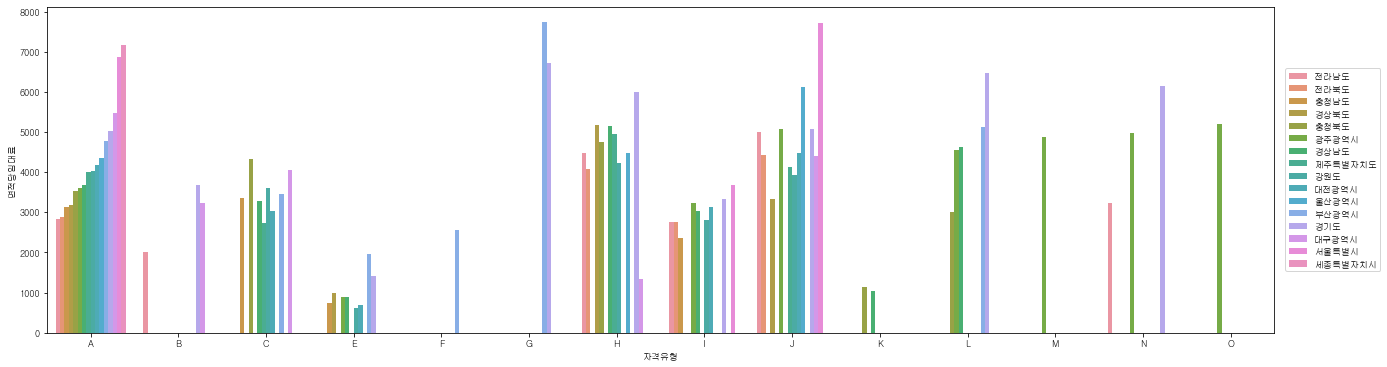

In [876]:
plt.figure(figsize=(22, 6))
sns.barplot(data=mean_rent.sort_values(by=['자격유형', '면적당임대료']),
            x='자격유형', y='면적당임대료', hue='지역')
plt.legend(loc='right', bbox_to_anchor=(1.09, 0.5))
plt.show()

- A, J, G 는 꽤나 높게 형성됩니다.
- 그러나 E, K 는 꽤나 낮게 형성됩니다.

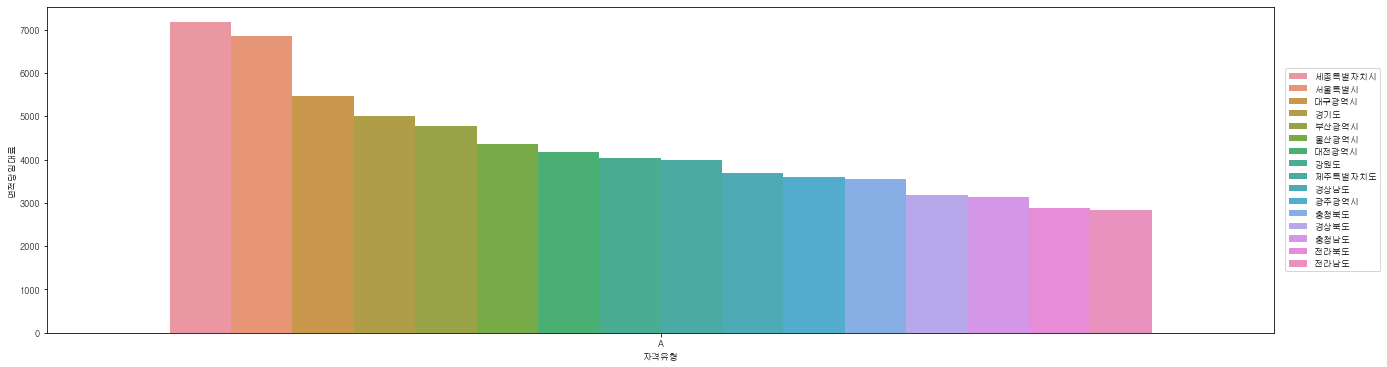

In [937]:
plt.figure(figsize=(22, 6))
sns.barplot(data=mean_rent.loc[mean_rent['자격유형'] == 'A'].sort_values(by=['면적당임대료'], ascending=False),
            x='자격유형', y='면적당임대료', hue='지역')
plt.legend(loc='right', bbox_to_anchor=(1.09, 0.5))
plt.show()

In [938]:
mean_rent.loc[mean_rent['자격유형'] == 'A'].sort_values(by=['면적당임대료'], ascending=False)

지역 자격유형       면적당임대료
59  세종특별자치시    A  7176.083039
56    서울특별시    A  6862.508603
37    대구광역시    A  5477.636320
8       경기도    A  5017.440685
48    부산광역시    A  4778.818934
60    울산광역시    A  4357.657710
42    대전광역시    A  4178.580848
0       강원도    A  4034.902476
73  제주특별자치도    A  3994.872112
17     경상남도    A  3680.957199
29    광주광역시    A  3600.982558
83     충청북도    A  3542.382144
25     경상북도    A  3175.917645
78     충청남도    A  3138.650295
69     전라북도    A  2875.538254
63     전라남도    A  2836.846983

In [949]:
kookmin_A = (
    train
    .loc[(train['공급유형'] == '국민임대') & (train['자격유형'] == 'A')]
    .groupby(['지역'])['면적당임대료']
    .mean()
    .sort_values(ascending=False)
    .to_frame()
)
kookmin_A

면적당임대료
지역                  
서울특별시    7487.593573
세종특별자치시  5321.380731
경기도      4858.148493
부산광역시    4641.213217
대구광역시    4272.213051
대전광역시    4084.761630
강원도      3940.679162
제주특별자치도  3787.516145
울산광역시    3574.029464
경상남도     3354.302561
충청북도     3103.855208
광주광역시    3058.832986
충청남도     3032.201320
경상북도     3028.435011
전라북도     2688.863480
전라남도     2534.966167

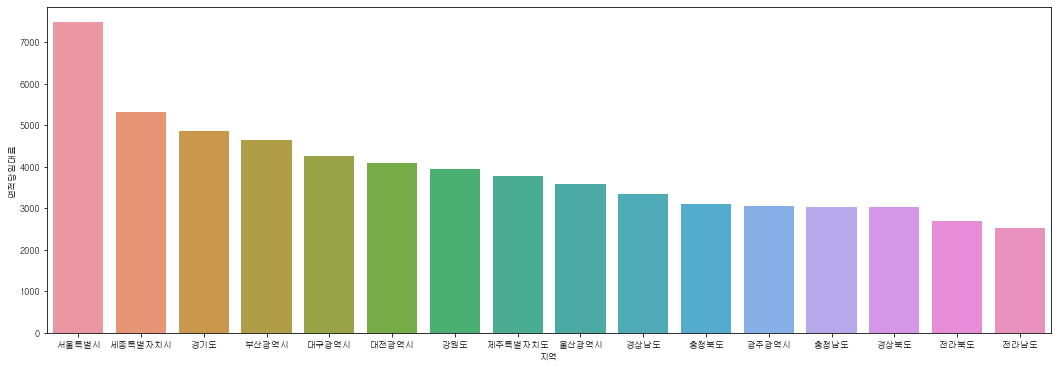

In [958]:
plt.figure(figsize=(18, 6))
sns.barplot(data=kookmin_A, x=kookmin_A.index, y='면적당임대료')
plt.show()

- 국민임대일반지수를 만들어줄 수도 있을 것 같습니다. 표준화를 통해서..
- 지역별 국민임대, A 의 평균 면적당 임대료를 수치로 넣어주면, 해당 지역의 보통의 지가의 수치를 대변할 수 있을 것도 같습니다.
- 문제는 강원도가 상당히 높은 게 이상합니다.

In [1007]:
mean_ = kookmin_A['면적당임대료'].mean()
std_ = kookmin_A['면적당임대료'].std()
kookmin_A['국민임대일반지수'] = (kookmin_A['면적당임대료'] - mean_) / std_

In [1008]:
kookmin_A

면적당임대료  국민임대일반지수
지역                            
서울특별시    7487.593573  2.870804
세종특별자치시  5321.380731  1.126179
경기도      4858.148493  0.753100
부산광역시    4641.213217  0.578385
대구광역시    4272.213051  0.281199
대전광역시    4084.761630  0.130230
강원도      3940.679162  0.014189
제주특별자치도  3787.516145 -0.109166
울산광역시    3574.029464 -0.281104
경상남도     3354.302561 -0.458068
충청북도     3103.855208 -0.659773
광주광역시    3058.832986 -0.696033
충청남도     3032.201320 -0.717482
경상북도     3028.435011 -0.720515
전라북도     2688.863480 -0.993999
전라남도     2534.966167 -1.117945

In [925]:
mean_rent = train.groupby(['지역', '자격유형'])[['면적당임대료']].mean().reset_index()

In [926]:
# 자격유형이 존재하지 않는 지역이 있는데, 0 으로 동일하게 넣어주겠습니다. 원활한 시각화를 위해.
for region in list(mean_rent['지역'].unique()):
    for qual in list(mean_rent['자격유형'].unique()):
        if len(mean_rent.loc[(mean_rent['지역'] == region) & (mean_rent['자격유형'] == qual)]) == 0:
            mean_rent = mean_rent.append({'지역': region, '자격유형': qual, '면적당임대료': 0}, ignore_index=True)
        else:
            pass

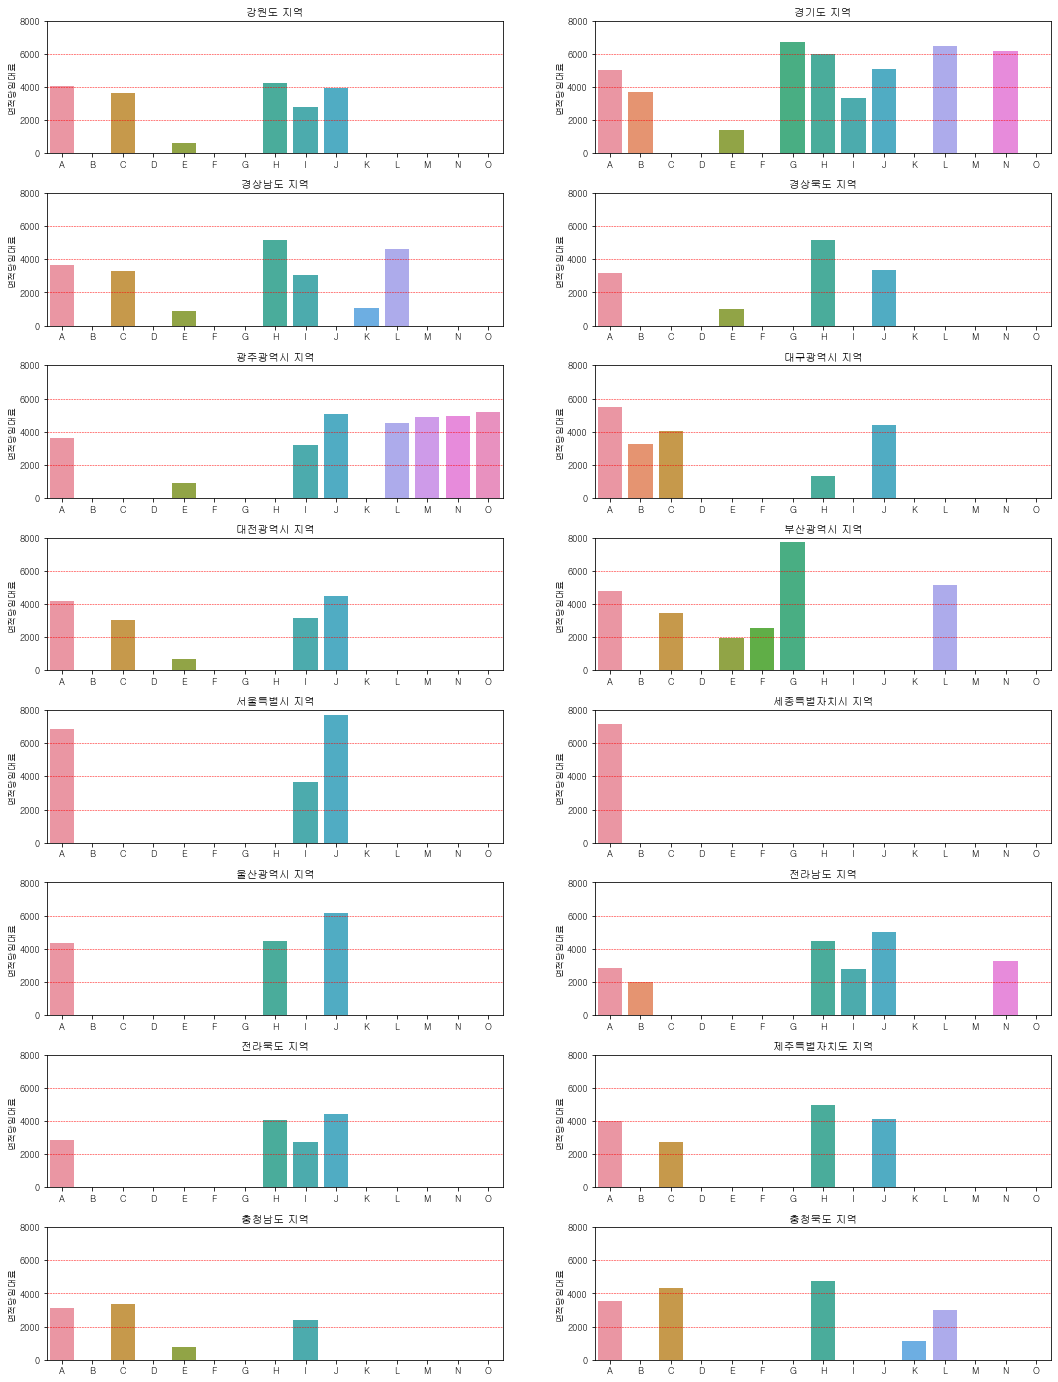

In [931]:
# 지역별로 임대료를 자격유형을 기준, 상대적으로 살펴보기 위함입니다.

fig = plt.figure(figsize=(18, 50))
for i, n in enumerate(list(mean_rent['지역'].unique())):
    plt.subplot(16, 2, i+1)
    plt.subplots_adjust(hspace=0.3)
    plots = sns.barplot(data=mean_rent.loc[mean_rent['지역'] == n].sort_values('자격유형'), x='자격유형', y='면적당임대료')
    plt.ylim(top = 8000)
    plt.axhline(y = 2000, color = 'r', linestyle = '--', linewidth = 0.5)
    plt.axhline(y = 4000, color = 'r', linestyle = '--', linewidth = 0.5)
    plt.axhline(y = 6000, color = 'r', linestyle = '--', linewidth = 0.5)
    plt.xlabel('')
    plt.title('{} 지역'.format(n))

- E, K 는 도대체 무엇이길래 모든 지역에서 낮게 형성되는가?
- I도 상대적으로 낮다. 왜 그럴까?

In [933]:
train.loc[train['자격유형'] == 'E', :'등록차량수']

단지코드  총세대수 임대건물구분     지역  공급유형   전용면적  전용면적별세대수   공가수 자격유형      임대보증금  \
178   C1616  1507    아파트  대전광역시  영구임대  40.32       450   1.0    E   54040000   
823   C2401   213    아파트    강원도  국민임대  46.90       104  21.0    E   55413000   
959   C2097   998    아파트   경상북도  국민임대  46.70       115  29.0    E   76506000   
960   C2097   998    아파트   경상북도  국민임대  46.75       244  29.0    E   76506000   
1053  C2458   853    아파트  광주광역시  국민임대  46.59        61  28.0    E   78080000   
1054  C2458   853    아파트  광주광역시  국민임대  46.90       432  28.0    E   78080000   
1055  C2458   853    아파트  광주광역시  국민임대  46.90         2  28.0    E   78080000   
1056  C2458   853    아파트  광주광역시  국민임대  46.90        56  28.0    E   78080000   
1637  C2394   277    아파트   충청남도  국민임대  46.90        45  20.0    E   65856600   
1638  C2394   277    아파트   충청남도  국민임대  46.90        15  20.0    E   65856600   
1639  C2394   277    아파트   충청남도  국민임대  46.90        42  20.0    E   65856600   
1640  C2394   277    아파트   충청남도  국민임대  51.93        14  20.0    E   81223800   
1641  C2394   277    아파트   충청남도  국민임대  51.93        75  20.0    E   81223800   
1870  C2488  1215    아파트  광주광역시  국민임대  46.54        90  28.0    E   83286000   
1871  C2488  1215    아파트  광주광역시  국민임대  46.85       116  28.0    E   83286000   
1872  C2488  1215    아파트  광주광역시  국민임대  46.90       261  28.0    E   83286000   
1873  C2488  1215    아파트  광주광역시  국민임대  46.90        85  28.0    E   83286000   
1874  C2488  1215    아파트  광주광역시  국민임대  46.98        73  28.0    E   83286000   
1929  C1572   937    아파트   경상남도  국민임대  46.43       234  32.0    E   76089000   
1930  C1572   937    아파트   경상남도  국민임대  51.55       113  32.0    E   93486000   
1986  C1316   107    아파트   충청남도  국민임대  33.76        96   7.0    E   36839600   
2015  C1328   992    아파트    경기도  국민임대  46.49        69  36.0    E  123711000   
2016  C1328   992    아파트    경기도  국민임대  46.49        63  36.0    E  123711000   
2017  C1328   992    아파트    경기도  국민임대  46.61        92  36.0    E  123711000   
2018  C1328   992    아파트    경기도  국민임대  46.61        38  36.0    E  123711000   
2019  C1328   992    아파트    경기도  국민임대  51.75       128  36.0    E  144496000   
2020  C1328   992    아파트    경기도  국민임대  51.75        32  36.0    E  144496000   
2026  C2357   533    아파트  부산광역시  국민임대  51.30       165  25.0    E  194080000   
2053  C2255   560    아파트   충청남도  영구임대  23.93        34   2.0    E   31980200   
2280  C2137   960    아파트   경상북도  국민임대  46.45       420  30.0    E  114953000   
2384  C1136   984    아파트    경기도  국민임대  46.40       228  31.0    E  124970000   
2385  C1136   984    아파트    경기도  국민임대  51.76       164  31.0    E  139418000   
2415  C2539   396    아파트   충청남도  영구임대  26.81        58   8.0    E   45995000   
2561  C2618  1550    아파트    경기도  국민임대  24.97       430  40.0    E   63613000   
2563  C2618  1550    아파트    경기도  국민임대  46.98       368  40.0    E  129988000   
2566  C1451  1618    아파트    경기도  국민임대  26.97       480  38.0    E   72960000   
2568  C1451  1618    아파트    경기도  국민임대  43.90       304  38.0    E  127360000   

         임대료  지하철    버스  단지내주차면수   등록차량수  
178    28140  0.0   2.0    407.0    98.0  
823    28850  0.0   3.0    164.0    19.0  
959    39840  0.0   2.0   1240.0   995.0  
960    39840  0.0   2.0   1240.0   995.0  
1053   40670  0.0   3.0    853.0   910.0  
1054   40670  0.0   3.0    853.0   910.0  
1055   40670  0.0   3.0    853.0   910.0  
1056   40670  0.0   3.0    853.0   910.0  
1637   34290  0.0   2.0    222.0   254.0  
1638   34290  0.0   2.0    222.0   254.0  
1639   34290  0.0   2.0    222.0   254.0  
1640   42300  0.0   2.0    222.0   254.0  
1641   42300  0.0   2.0    222.0   254.0  
1870   43380  0.0   4.0   1105.0  1023.0  
1871   43380  0.0   4.0   1105.0  1023.0  
1872   43380  0.0   4.0   1105.0  1023.0  
1873   43380  0.0   4.0   1105.0  1023.0  
1874   43380  0.0   4.0   1105.0  1023.0  
1929   39620  0.0   3.0    770.0   479.0  
1930   48690  0.0   3.0    770.0   479.0  
1986   19180  0.0   2.0     27.0    22.0  
2015   64430  0.0  1

In [934]:
train.loc[train['자격유형'] == 'K', :'등록차량수']

단지코드  총세대수 임대건물구분    지역  공급유형   전용면적  전용면적별세대수   공가수 자격유형     임대보증금  \
2552  C1685   295    아파트  충청북도  행복주택  26.04        49  28.0    K  40572000   
2553  C1685   295    아파트  충청북도  행복주택  26.04        38  28.0    K  40572000   
2554  C1685   295    아파트  충청북도  행복주택  26.07        98  28.0    K  40572000   
2555  C1685   295    아파트  충청북도  행복주택  26.07        15  28.0    K  40572000   
2556  C1685   295    아파트  충청북도  행복주택  26.24        15  28.0    K  40572000   
2680  C1786   480    아파트   강원도  행복주택  16.91       156  25.0    K         0   
2681  C1786   480    아파트   강원도  행복주택  26.90       136  25.0    K         0   
2682  C1786   480    아파트   강원도  행복주택  26.90        72  25.0    K         0   
2683  C1786   480    아파트   강원도  행복주택  26.90        24  25.0    K         0   
2814  C2245   212    아파트  경상남도  행복주택  16.71        67  22.0    K  34499000   
2815  C2245   212    아파트  경상남도  행복주택  16.71         5  22.0    K  33216000   
2816  C2245   212    아파트  경상남도  행복주택  26.95        41  22.0    K  50657000   
2817  C2245   212    아파트  경상남도  행복주택  26.95        12  22.0    K  50657000   
2818  C2245   212    아파트  경상남도  행복주택  26.95        21  22.0    K  50657000   
2819  C2245   212    아파트  경상남도  행복주택  36.99        60  22.0    K  71616000   
2820  C2245   212    아파트  경상남도  행복주택  36.99         4  22.0    K  71616000   
2840  C2225  1206    아파트  경상남도  행복주택  16.02       120  49.0    K  33888000   
2841  C2225  1206    아파트  경상남도  행복주택  16.27        44  49.0    K  32758000   
2842  C2225  1206    아파트  경상남도  행복주택  16.29       340  49.0    K  33888000   
2843  C2225  1206    아파트  경상남도  행복주택  26.17       110  49.0    K  51961000   
2844  C2225  1206    아파트  경상남도  행복주택  26.17       120  49.0    K  51961000   
2845  C2225  1206    아파트  경상남도  행복주택  26.19        16  49.0    K  51961000   
2846  C2225  1206    아파트  경상남도  행복주택  36.03       290  49.0    K  72294000   
2847  C2225  1206    아파트  경상남도  행복주택  36.03        60  49.0    K  72294000   
2848  C2225  1206    아파트  경상남도  행복주택  36.05       100  49.0    K  72294000   
2890  C1156  1004    아파트  충청북도  행복주택  16.64       182  47.0    K  42913000   
2891  C1156  1004    아파트  충청북도  행복주택  16.64       224  47.0    K  42913000   
2892  C1156  1004    아파트  충청북도  행복주택  26.49        52  47.0    K  67718000   
2893  C1156  1004    아파트  충청북도  행복주택  26.51        58  47.0    K  67718000   
2894  C1156  1004    아파트  충청북도  행복주택  26.51        10  47.0    K  68963000   
2895  C1156  1004    아파트  충청북도  행복주택  26.62        88  47.0    K  67718000   
2896  C1156  1004    아파트  충청북도  행복주택  36.53       256  47.0    K  91414000   
2897  C1156  1004    아파트  충청북도  행복주택  36.53       128  47.0    K  91414000   

        임대료  지하철   버스  단지내주차면수  등록차량수  
2552  21120  0.0  1.0    167.0  164.0  
2553  21120  0.0  1.0    167.0  164.0  
2554  21120  0.0  1.0    167.0  164.0  
2555  21120  0.0  1.0    167.0  164.0  
2556  21120  0.0  1.0    167.0  164.0  
2680      0  0.0  3.0    338.0  345.0  
2681      0  0.0  3.0    338.0  345.0  
2682      0  0.0  3.0    338.0  345.0  
2683      0  0.0  3.0    338.0  345.0  
2814  17960  0.0  1.0    114.0   98.0  
2815  17300  0.0  1.0    114.0   98.0  
2816  26380  0.0  1.0    114.0   98.0  
2817  26380  0.0  1.0    114.0   98.0  
2818  26380  0.0  1.0    114.0   98.0  
2819  37300  0.0  1.0    114.0   98.0  
2820  37300  0.0  1.0    114.0   98.0  
2840  17650  0.0  3.0    842.0  448.0  
2841  17060  0.0  3.0    842.0  448.0  
2842  17650  0.0  3.0    842.0  448.0  
2843  27060  0.0  3.0    842.0  448.0  
2844  27060  0.0  3.0    842.0  448.0  
2845  27060  0.0  3.0    842.0  448.0  
2846  37650  0.0  3.0    842.0  448.0  
2847  37650  0.0  3.0    842.0  448.0  
2848  37650  0.0  3.0    842.0  448.0  
2890  22350  0.0  3.0    700.0  505.0  
2891  22350  0.0  3.0    700.0  505.0  
2892  35270  0.0  3.0    700.0  505.0  
2893  35270  0.0  3.0    700.0  505.0  
2894  35910  0.0  3.0    700.0  505.0  
2895  35270  0.0  3.0    700.0  505.0  
2896  47600  0.0  3.0    700.0  505.0  
2897  47600  0.0  3.0    700.0  50

아니, 임대료가 2~3만원이에요. 진짜 쌉니다.

In [935]:
train.loc[train['자격유형'] == 'I', :'등록차량수']

단지코드  총세대수 임대건물구분     지역  공급유형   전용면적  전용면적별세대수   공가수 자격유형     임대보증금  \
2054  C2255   560    아파트   충청남도  영구임대  26.67        66   2.0    I   5514000   
2084  C2352  1065    아파트  서울특별시  영구임대  21.78        62   7.0    I   9515000   
2085  C2352  1065    아파트  서울특별시  영구임대  29.43        94   7.0    I  12728000   
2086  C2352  1065    아파트  서울특별시  영구임대  29.43        36   7.0    I  12728000   
2109  C1039   790    아파트  서울특별시  영구임대  26.68        70  13.0    I  11490000   
2110  C1039   790    아파트  서울특별시  영구임대  33.11        30  13.0    I  14263000   
2130  C2659   504    아파트    경기도  영구임대  21.63        28   3.0    I   9638000   
2131  C2659   504    아파트    경기도  영구임대  21.63         6   3.0    I   9638000   
2132  C2659   504    아파트    경기도  영구임대  26.66        11   3.0    I  11869000   
2133  C2659   504    아파트    경기도  영구임대  26.66        33   3.0    I  11869000   
2134  C2659   504    아파트    경기도  영구임대  26.66        12   3.0    I  11869000   
2145  C2314   600    아파트  대전광역시  영구임대  21.81        64  13.0    I   7010000   
2146  C2314   600    아파트  대전광역시  영구임대  21.81         8  13.0    I   7010000   
2147  C2314   600    아파트  대전광역시  영구임대  26.44       188  13.0    I   8500000   
2210  C1341   922    아파트  광주광역시  영구임대  23.76       232   7.0    I   7864000   
2211  C1341   922    아파트  광주광역시  영구임대  23.76        18   7.0    I   7864000   
2291  C2583  1106    아파트  대전광역시  영구임대  21.97        60  21.0    I   7175000   
2292  C2583  1106    아파트  대전광역시  영구임대  26.90        60  21.0    I   8707000   
2293  C2583  1106    아파트  대전광역시  영구임대  26.90        36  21.0    I   8707000   
2294  C2583  1106    아파트  대전광역시  영구임대  26.90        72  21.0    I   8707000   
2295  C2583  1106    아파트  대전광역시  영구임대  26.90        12  21.0    I   8707000   
2397  C2393  1546    아파트    경기도  영구임대  26.70        90   1.0    I  10220000   
2398  C2393  1546    아파트    경기도  영구임대  26.70        14   1.0    I  10220000   
2399  C2393  1546    아파트    경기도  영구임대  26.70       144   1.0    I  10220000   
2400  C2393  1546    아파트    경기도  영구임대  33.91         4   1.0    I  12906000   
2401  C2393  1546    아파트    경기도  영구임대  33.91       128   1.0    I  12906000   
2484  C2507  1454    아파트    경기도  영구임대  21.72       238   4.0    I   7794000   
2485  C2507  1454    아파트    경기도  영구임대  26.79        30   4.0    I   9500000   
2486  C2507  1454    아파트    경기도  영구임대  26.81       146   4.0    I   9500000   
2496  C2627   580    아파트   전라남도  영구임대  24.95        96  18.0    I   7172000   
2497  C2627   580    아파트   전라남도  영구임대  24.95        24  18.0    I   7172000   
2522  C1363  2568    아파트    경기도  영구임대  21.95        86  11.0    I  10718000   
2523  C1363  2568    아파트    경기도  영구임대  26.85       300  11.0    I  12881000   
2524  C1363  2568    아파트    경기도  영구임대  26.85       164  11.0    I  12881000   
2564  C2618  1550    아파트    경기도  영구임대  23.86       176  40.0    I   9316000   
2565  C2618  1550    아파트    경기도  영구임대  23.89       168  40.0    I   9328000   
2569  C1451  1618    아파트    경기도  영구임대  24.86       100  38.0    I  10319000   
2570  C1451  1618    아파트    경기도  영구임대  24.96       134  38.0    I  10360000   
2579  C1968   514    아파트    강원도  영구임대  23.48       148   0.0    I   8377000   
2587  C1258   840    아파트   경상남도  영구임대  24.72       122   0.0    I   7973000   
2588  C1258   840    아파트   경상남도  영구임대  24.79        18   0.0    I   7973000   
2593  C2453   659    아파트    경기도  영구임대  24.98        54   7.0    I  12139000   
2594  C2453   659    아파트    경기도  영구임대  24.98        18   7.0    I  12139000   
2595  C2453   659    아파트    경기도  영구임대  24.98        52   7.0    I  12139000   
2610  C1724  1256    아파트   경상남도  영구임대  24.74        80   1.0    I   8112000   
2726  C2359   820    아파트   전라남도  영구임대  24.43        44   9.0    I   7048000   
2727  C2359   820    아파트   전라남도  영구임대  24.71       240   9.0    I   7126000   
2755  C2508   847    아파트   전라북도  영구임대  24.74       266  13.0    I   8184000   
2756  C2508   847    아파트   전라북도  영구임대  24.75        30  13.0    I   8184000   

         임대료  지하철   버스  단지내주차면수   등록차량수  
2054   63280  

In [1003]:
train.loc[train['자격유형'] == 'I', :'등록차량수']['임대료'].mean()

82552.24489795919

- 확실히 보면, 자격유형이 임대료에 상당히 많은 영향을 미치며, 공급유형이 대체로 자격유형과 연관이 있습니다.
- 동일 단지라고 해서 임대료가 비슷하지가 않습니다.
- 차라리 해당 자격유형의 임대료를 평균으로 산정하고, 국민임대일반지수를 곱해주는 것이 더 나을 수도 있을 것 같습니다.

### 대중교통은 차량보유에 영향을 미칠까?

In [961]:
train_danji

단지코드  총세대수       지역   공가수  지하철   버스  단지내주차면수   등록차량수
0    C2483   900     경상북도  38.0  0.0  3.0   1425.0  1015.0
1    C2515   545     경상남도  17.0  0.0  3.0    624.0   205.0
2    C1407  1216    대전광역시  13.0  1.0  1.0   1285.0  1064.0
3    C1945   755      경기도   6.0  1.0  3.0    734.0   730.0
4    C1470   696     전라북도  14.0  0.0  2.0    645.0   553.0
..     ...   ...      ...   ...  ...  ...      ...     ...
418  C2586    90  제주특별자치도   7.0  0.0  3.0     66.0    57.0
419  C2035   492      강원도  24.0  0.0  1.0    521.0   246.0
420  C2020    40    부산광역시   7.0  1.0  2.0     25.0    19.0
421  C2437    90     충청북도  12.0  0.0  1.0     30.0    16.0
422  C2532   239      강원도   7.0  0.0  1.0    166.0   146.0

[423 rows x 8 columns]

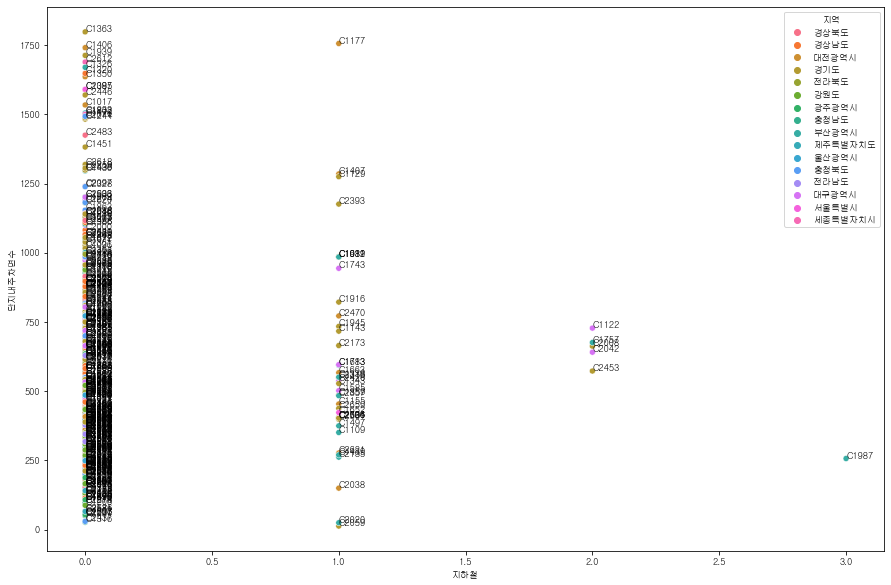

In [963]:
plt.figure(figsize=(15, 10))
plots = sns.scatterplot(data=train_danji, x='지하철', y='단지내주차면수', hue='지역')
for i, code in enumerate(train_danji['단지코드']):
    plots.annotate(code, (train_danji['지하철'][i], train_danji['단지내주차면수'][i]))
plt.show()

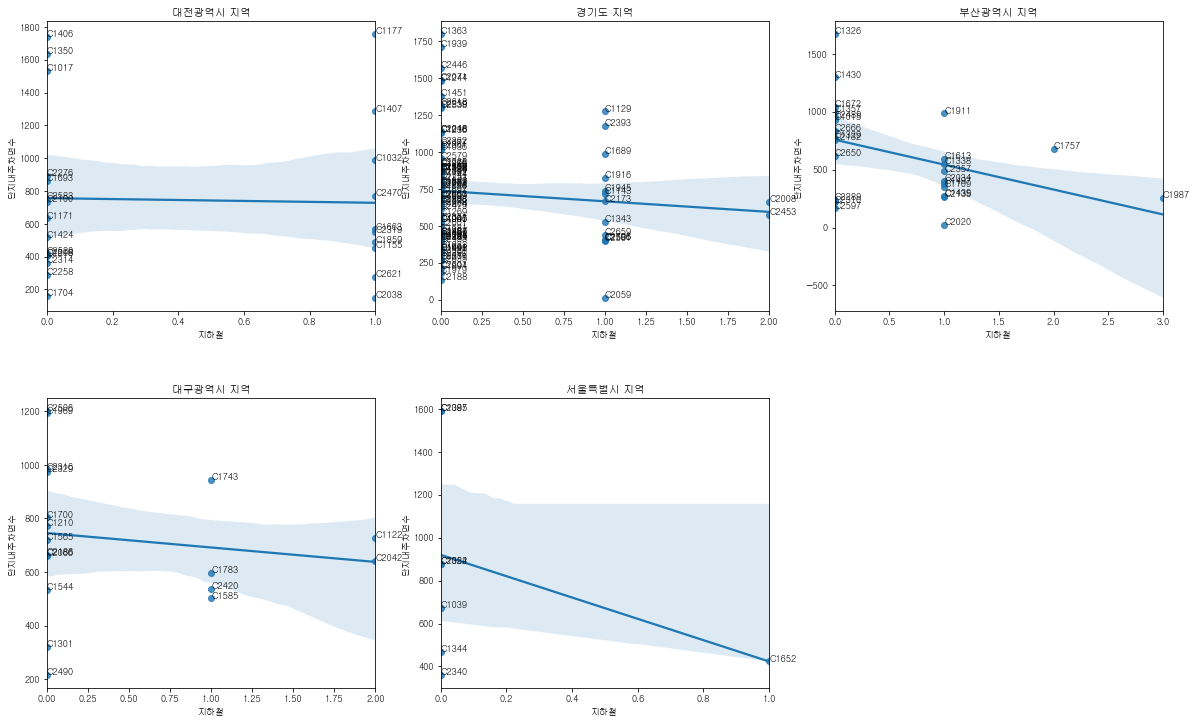

In [967]:
fig = plt.figure(figsize=(20, 40))
for i, n in enumerate(['대전광역시', '경기도', '부산광역시', '대구광역시', '서울특별시']):
    plt.subplot(6, 3, i+1)
    plt.subplots_adjust(hspace=0.3)
    plots = sns.regplot(data=train_danji.loc[train_danji['지역'] == n], x='지하철', y='단지내주차면수')
    for i, code in enumerate(train_danji.loc[train_danji['지역'] == n].reset_index(drop=True)['단지코드']):
        plots.annotate(code, (train_danji.loc[train_danji['지역'] == n].reset_index(drop=True)['지하철'][i],
                              train_danji.loc[train_danji['지역'] == n].reset_index(drop=True)['단지내주차면수'][i]))
    plt.title('{} 지역'.format(n))

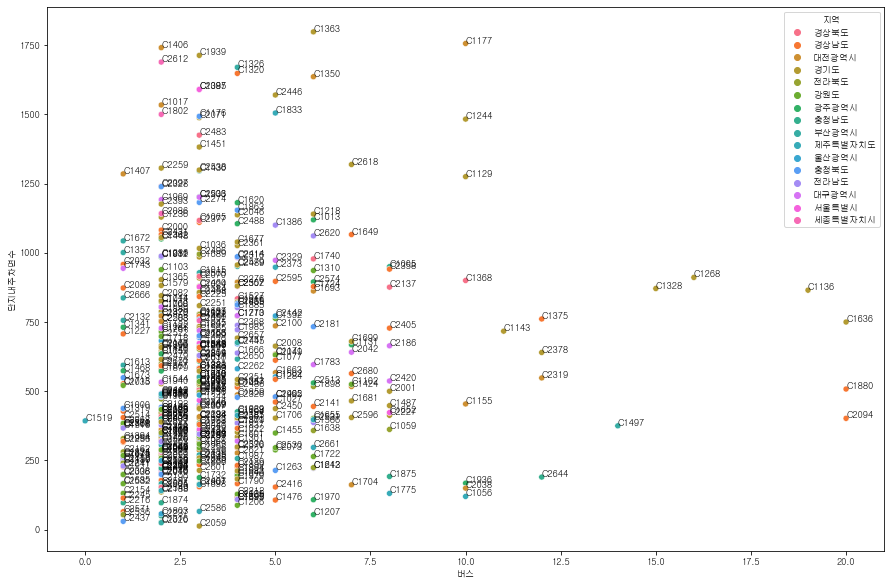

In [964]:
plt.figure(figsize=(15, 10))
plots = sns.scatterplot(data=train_danji, x='버스', y='단지내주차면수', hue='지역')
for i, code in enumerate(train_danji['단지코드']):
    plots.annotate(code, (train_danji['버스'][i], train_danji['단지내주차면수'][i]))
plt.show()

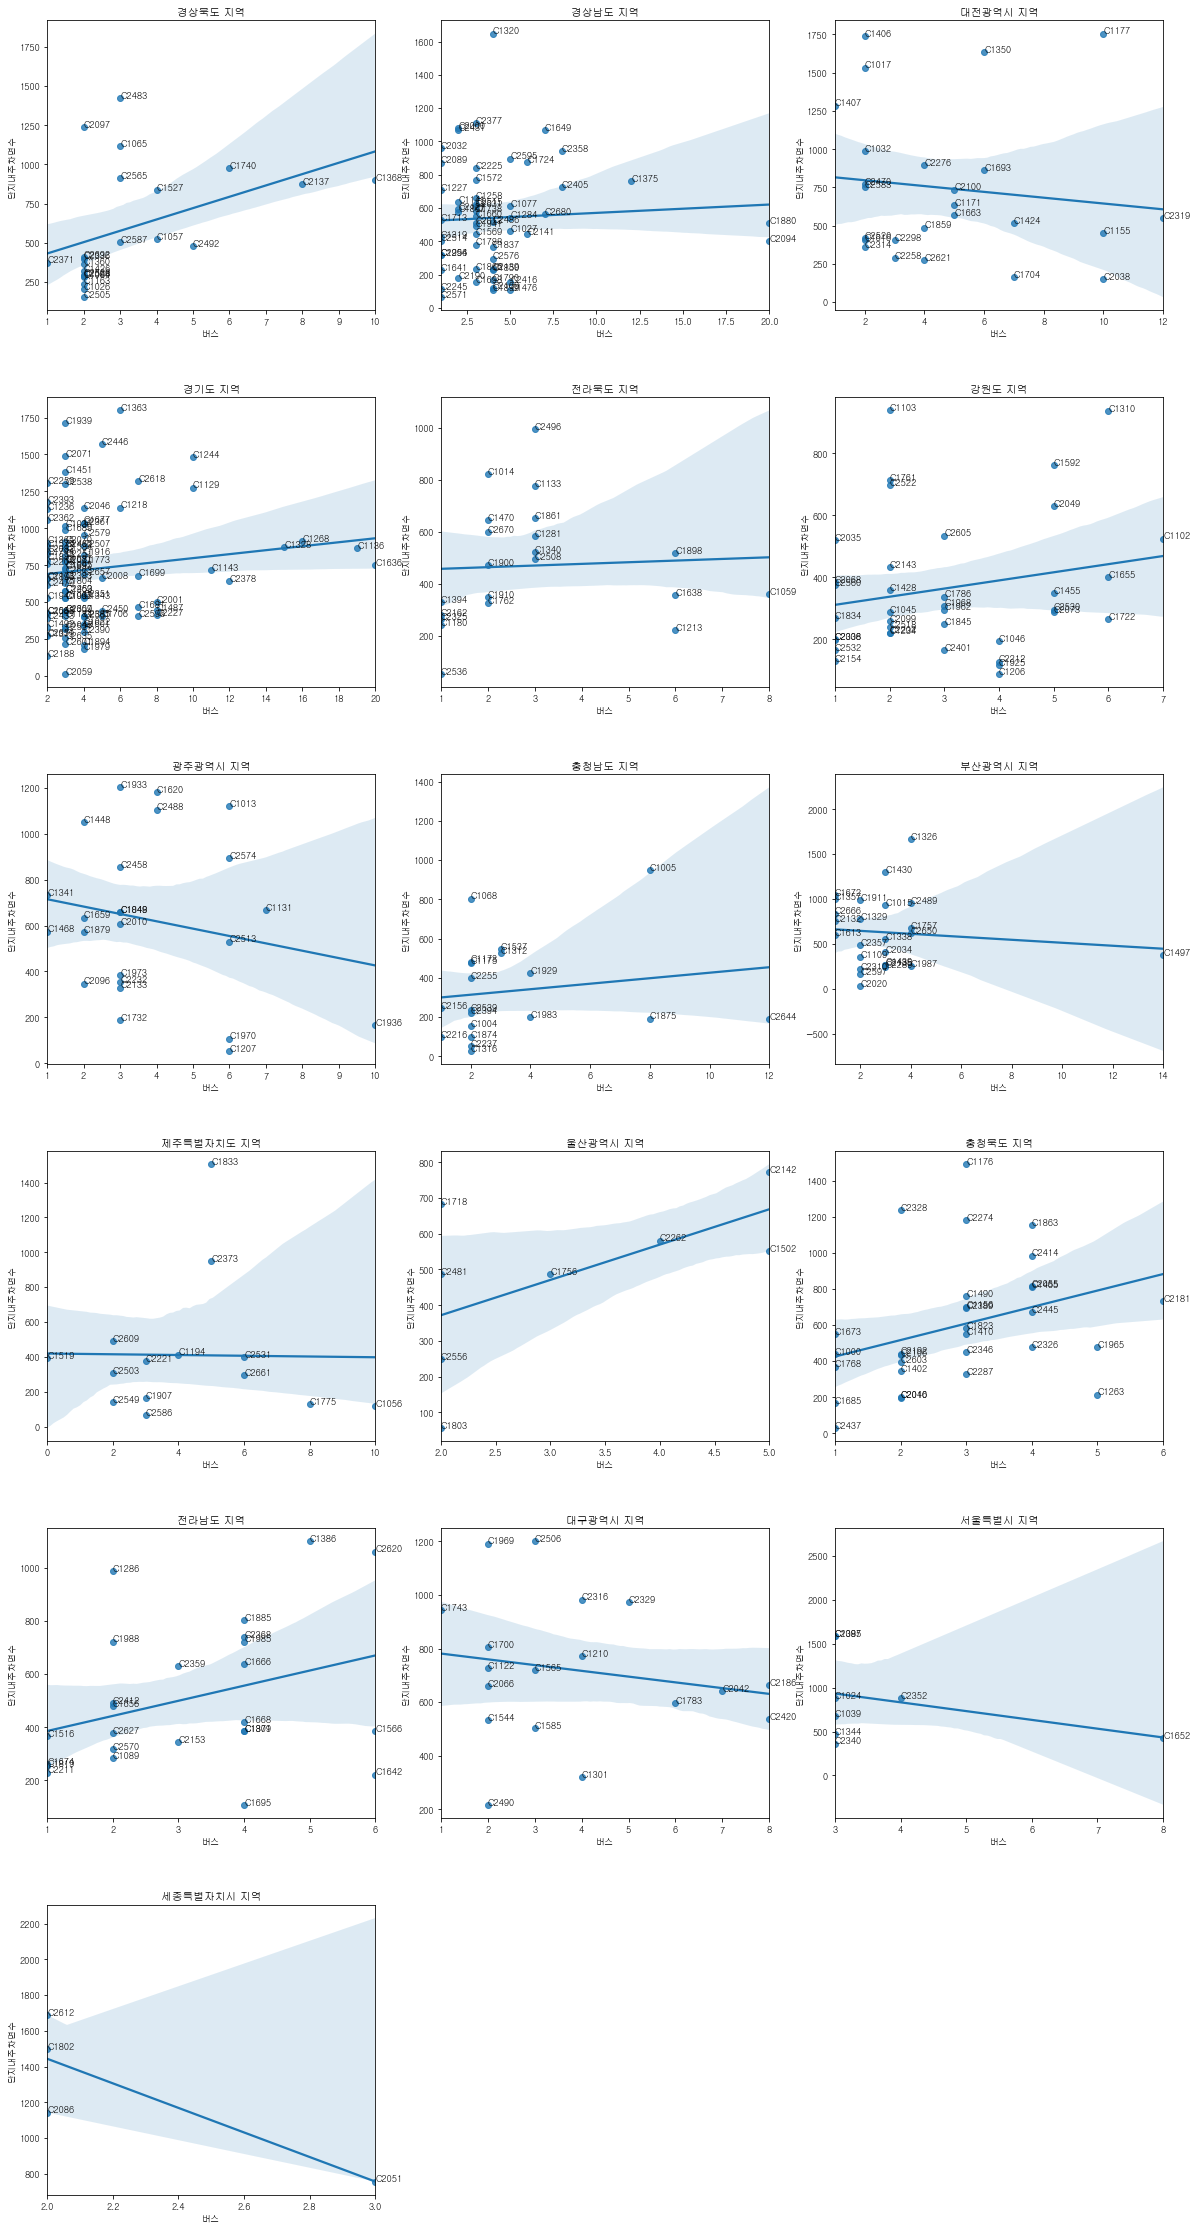

In [966]:
fig = plt.figure(figsize=(20, 40))
for i, n in enumerate(list(train_danji['지역'].unique())):
    plt.subplot(6, 3, i+1)
    plt.subplots_adjust(hspace=0.3)
    plots = sns.regplot(data=train_danji.loc[train_danji['지역'] == n], x='버스', y='단지내주차면수')
    for i, code in enumerate(train_danji.loc[train_danji['지역'] == n].reset_index(drop=True)['단지코드']):
        plots.annotate(code, (train_danji.loc[train_danji['지역'] == n].reset_index(drop=True)['버스'][i],
                              train_danji.loc[train_danji['지역'] == n].reset_index(drop=True)['단지내주차면수'][i]))
    plt.title('{} 지역'.format(n))

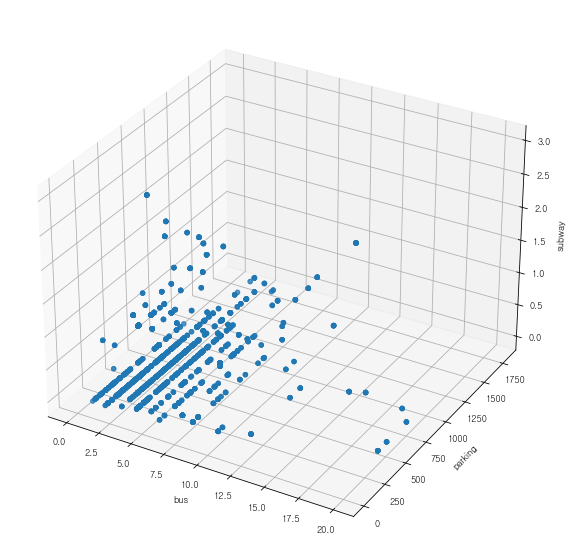

In [971]:
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection = '3d')

x = train['버스']
y = train['단지내주차면수']
z = train['지하철']

ax.set_xlabel("bus")
ax.set_ylabel("parking")
ax.set_zlabel("subway")

ax.scatter(x, y, z)

plt.show()

모르겠다

지하철과 버스를 통합해서 대중교통지수를 만들어보자. 지하철 1개의 영향을 버스 3~5개의 영향과도 맞먹을 것이다.

In [976]:
train_danji['대중교통'] = (train_danji['지하철'] * 3) + train_danji['버스']

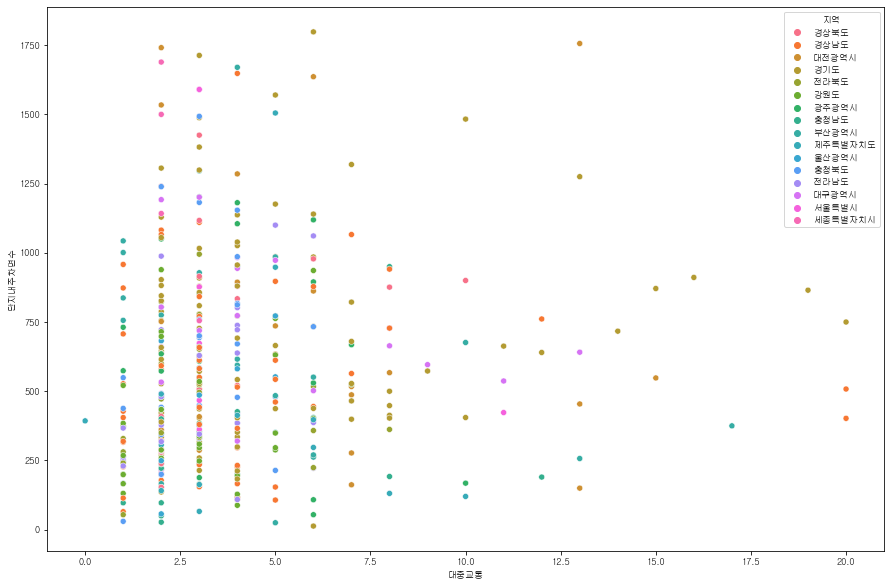

In [979]:
plt.figure(figsize=(15, 10))
plots = sns.scatterplot(data=train_danji, x='대중교통', y='단지내주차면수', hue='지역')
#for i, code in enumerate(train_danji['단지코드']):
#    plots.annotate(code, (train_danji['대중교통'][i], train_danji['단지내주차면수'][i]))
plt.show()

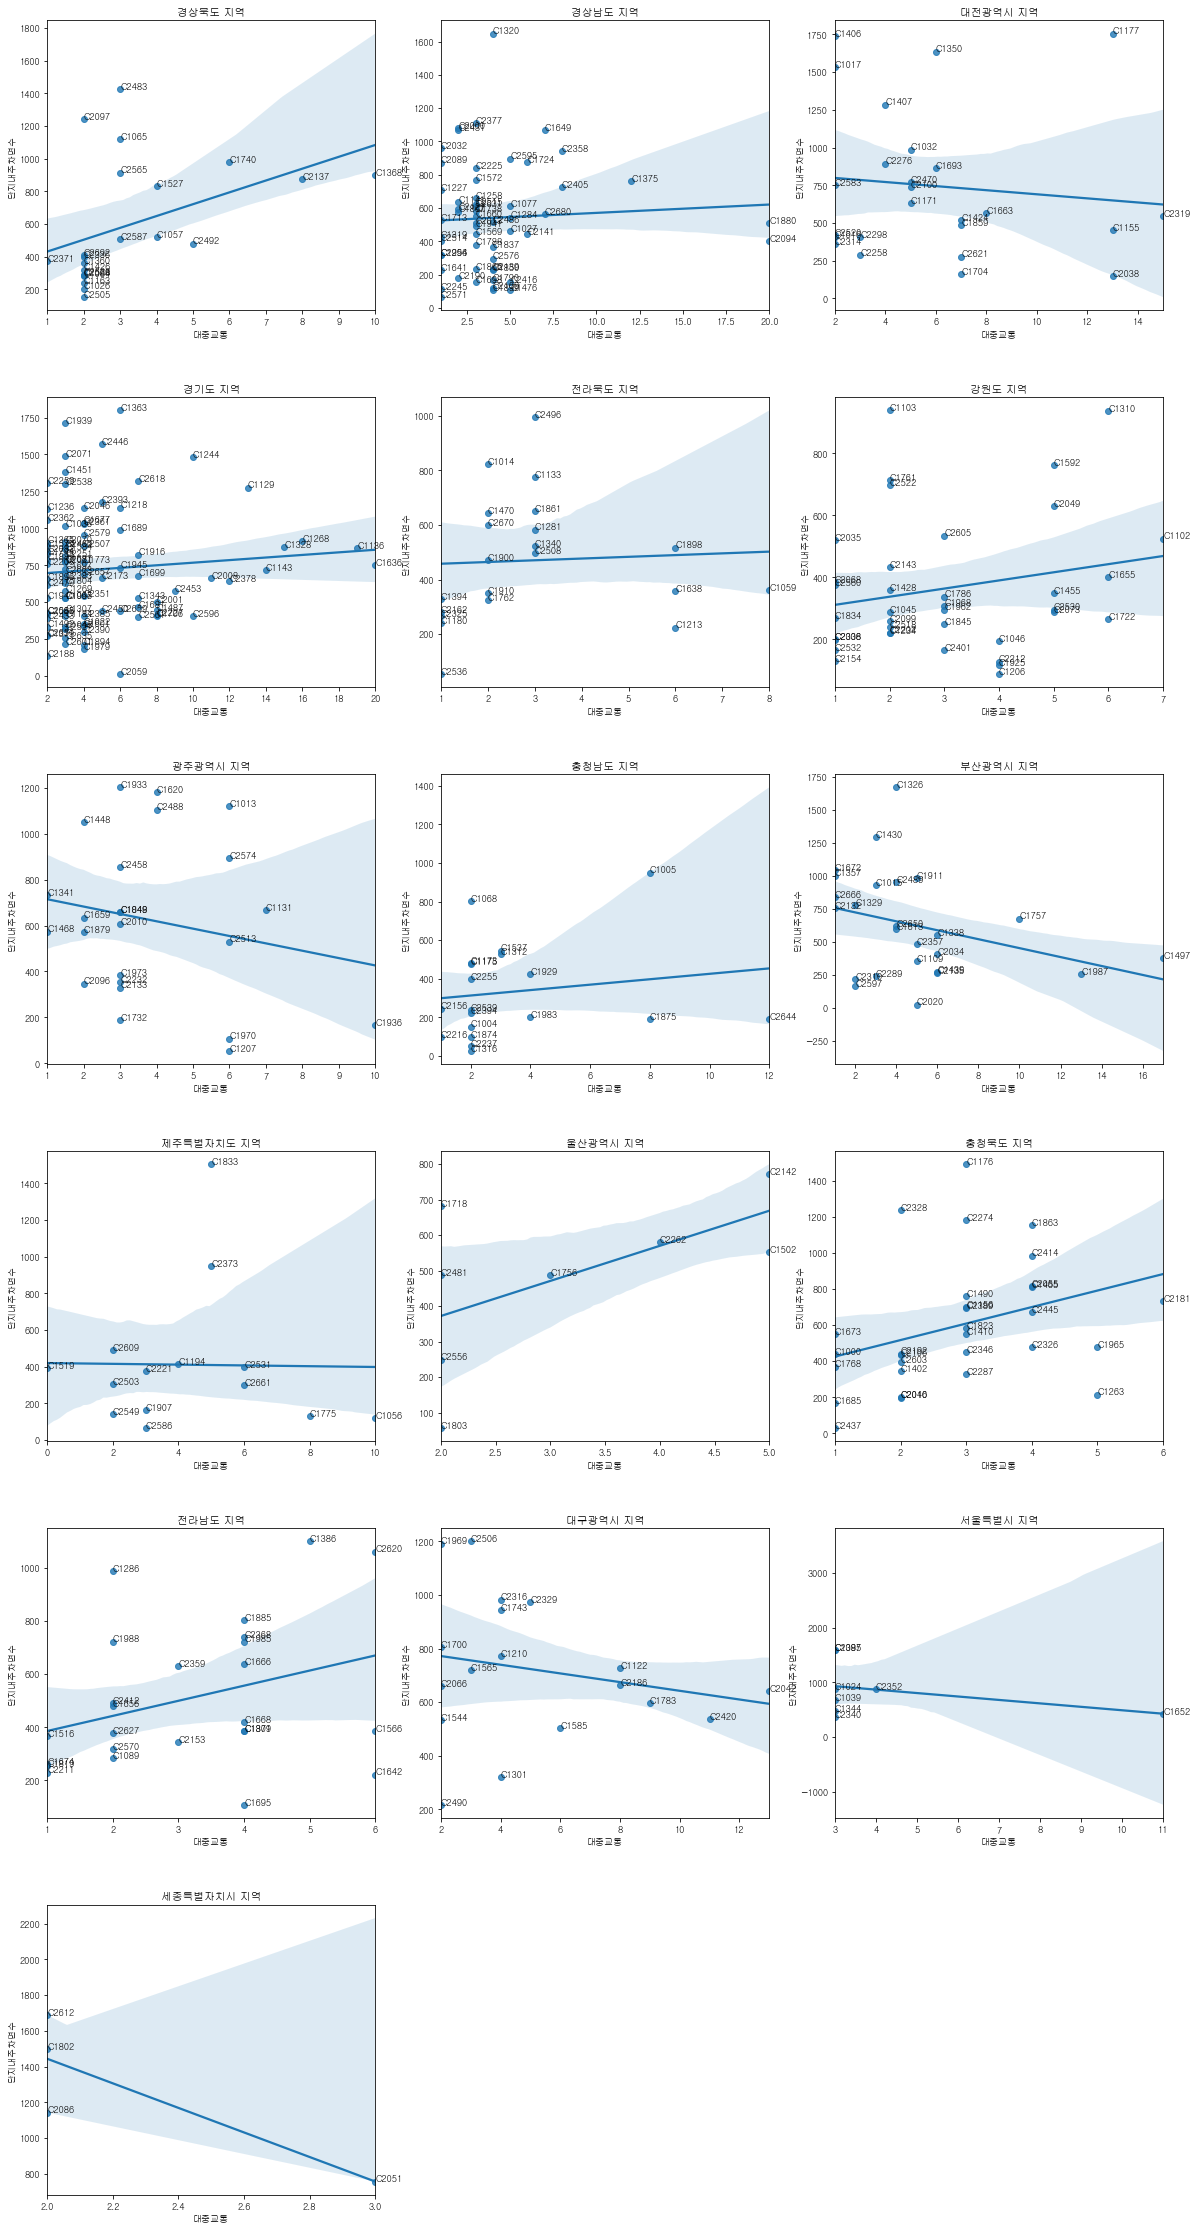

In [980]:
fig = plt.figure(figsize=(20, 40))
for i, n in enumerate(list(train_danji['지역'].unique())):
    plt.subplot(6, 3, i+1)
    plt.subplots_adjust(hspace=0.3)
    plots = sns.regplot(data=train_danji.loc[train_danji['지역'] == n], x='대중교통', y='단지내주차면수')
    for i, code in enumerate(train_danji.loc[train_danji['지역'] == n].reset_index(drop=True)['단지코드']):
        plots.annotate(code, (train_danji.loc[train_danji['지역'] == n].reset_index(drop=True)['대중교통'][i],
                              train_danji.loc[train_danji['지역'] == n].reset_index(drop=True)['단지내주차면수'][i]))
    plt.title('{} 지역'.format(n))

### 대중교통이 하나도 없는 아파트 단지는?

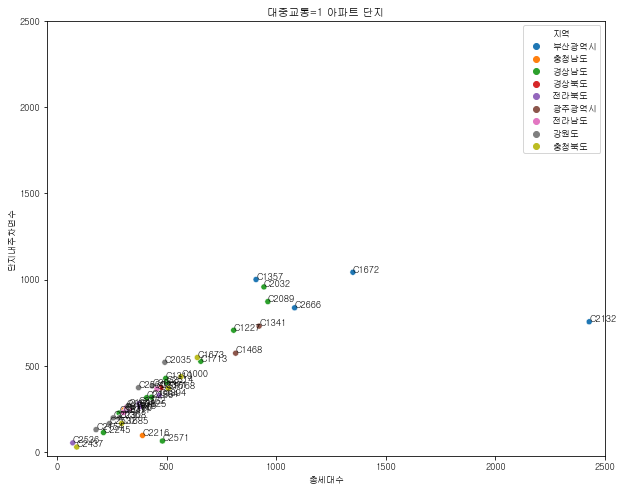

In [996]:
plt.figure(figsize=(10, 8))
plots = sns.scatterplot(data=train_danji.loc[train_danji['대중교통'] == 1], x='총세대수', y='단지내주차면수', hue='지역')
for i, code in enumerate(train_danji.loc[train_danji['대중교통'] == 1].reset_index()['단지코드']):
    plots.annotate(code, (train_danji.loc[train_danji['대중교통'] == 1].reset_index()['총세대수'][i],
                          train_danji.loc[train_danji['대중교통'] == 1].reset_index()['단지내주차면수'][i]))
plt.title('대중교통=1 아파트 단지')
plt.ylim(top = 2500)
plt.xlim(right = 2500)
plt.show()

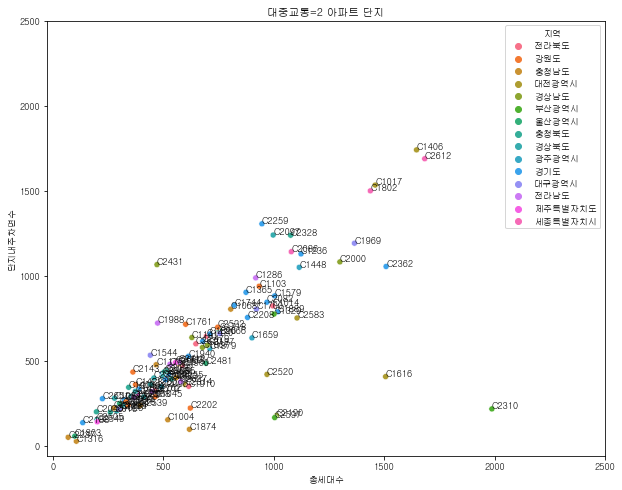

In [997]:
plt.figure(figsize=(10, 8))
plots = sns.scatterplot(data=train_danji.loc[train_danji['대중교통'] == 2], x='총세대수', y='단지내주차면수', hue='지역')
for i, code in enumerate(train_danji.loc[train_danji['대중교통'] == 2].reset_index()['단지코드']):
    plots.annotate(code, (train_danji.loc[train_danji['대중교통'] == 2].reset_index()['총세대수'][i],
                          train_danji.loc[train_danji['대중교통'] == 2].reset_index()['단지내주차면수'][i]))
plt.title('대중교통=2 아파트 단지')
plt.ylim(top = 2500)
plt.xlim(right = 2500)
plt.show()

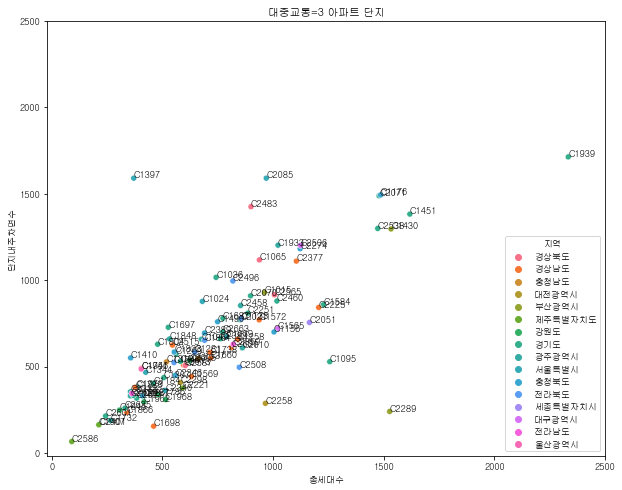

In [998]:
plt.figure(figsize=(10, 8))
plots = sns.scatterplot(data=train_danji.loc[train_danji['대중교통'] == 3], x='총세대수', y='단지내주차면수', hue='지역')
for i, code in enumerate(train_danji.loc[train_danji['대중교통'] == 3].reset_index()['단지코드']):
    plots.annotate(code, (train_danji.loc[train_danji['대중교통'] == 3].reset_index()['총세대수'][i],
                          train_danji.loc[train_danji['대중교통'] == 3].reset_index()['단지내주차면수'][i]))
plt.title('대중교통=3 아파트 단지')
plt.ylim(top = 2500)
plt.xlim(right = 2500)
plt.show()

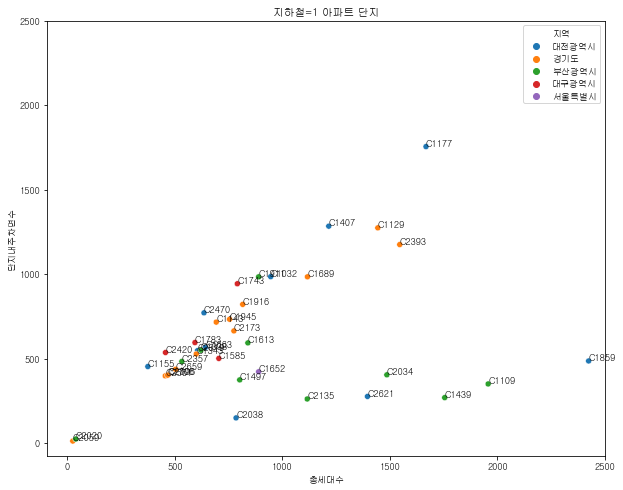

In [999]:
plt.figure(figsize=(10, 8))
plots = sns.scatterplot(data=train_danji.loc[train_danji['지하철'] == 1], x='총세대수', y='단지내주차면수', hue='지역')
for i, code in enumerate(train_danji.loc[train_danji['지하철'] == 1].reset_index()['단지코드']):
    plots.annotate(code, (train_danji.loc[train_danji['지하철'] == 1].reset_index()['총세대수'][i],
                          train_danji.loc[train_danji['지하철'] == 1].reset_index()['단지내주차면수'][i]))
plt.title('지하철=1 아파트 단지')
plt.ylim(top = 2500)
plt.xlim(right = 2500)
plt.show()

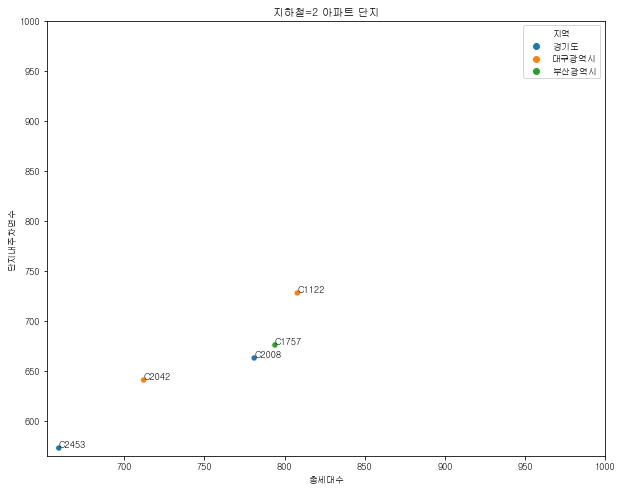

In [1002]:
plt.figure(figsize=(10, 8))
plots = sns.scatterplot(data=train_danji.loc[train_danji['지하철'] == 2], x='총세대수', y='단지내주차면수', hue='지역')
for i, code in enumerate(train_danji.loc[train_danji['지하철'] == 2].reset_index()['단지코드']):
    plots.annotate(code, (train_danji.loc[train_danji['지하철'] == 2].reset_index()['총세대수'][i],
                          train_danji.loc[train_danji['지하철'] == 2].reset_index()['단지내주차면수'][i]))
plt.title('지하철=2 아파트 단지')
plt.ylim(top = 1000)
plt.xlim(right = 1000)
plt.show()

### StdDeposit(환산보증금)

In [790]:
train.loc[train['임대보증금'] == '-', '임대보증금'] = 0
test.loc[test['임대보증금'] == '-', '임대보증금'] = 0

train.loc[train['임대료'] == '-', '임대료'] = 0
test.loc[test['임대료'] == '-', '임대료'] = 0

In [791]:
# nan 값 때문에 object로 되어 있습니다. 일단 0으로 채워 줍니다.
train['임대보증금'] = train['임대보증금'].fillna(0)
test['임대보증금'] = test['임대보증금'].fillna(0)

train['임대료'] = train['임대료'].fillna(0)
test['임대료'] = test['임대료'].fillna(0)

In [792]:
# 계산을 위해서 int로 바꿔줍니다.
train['임대보증금'] = train['임대보증금'].astype(int)
test['임대보증금'] = test['임대보증금'].astype(int)

train['임대료'] = train['임대료'].astype(int)
test['임대료'] = test['임대료'].astype(int)

기존의 환산보증금 공식으로 가면, 전세금과 환산보증금 차이가 너무 심합니다.<br>
전세와 월세가 동시에 있는 단지가 1개 있습니다. 이 단지를 기준으로 환산보증금을 재계산 합니다.

In [793]:
(187694000/51.32) - ((45456000 + (356420 * 354))/46.96)

2542.080887400545

In [794]:
# 환산보증금 컬럼을 만들어줍니다.
train['환산보증금'] = train['임대보증금'] + train['임대료'] * 354
test['환산보증금'] = test['임대보증금'] + test['임대료'] * 354

In [795]:
# 제곱미터당 환산보증금을 만들어줍니다.
train['면적당환산보증금'] = (train['환산보증금'] / train['전용면적']).round()
test['면적당환산보증금'] = (test['환산보증금'] / test['전용면적']).round()

In [1025]:
train.loc[train['임대보증금'] == 0, '임대보증금'] = np.nan
train.loc[train['임대료'] == 0, '임대료'] = np.nan

- 임대료가 없는 아파트를 찾아서 값을 넣어주겠습니다.

In [763]:
# # C1350은 같은 단지에 다른 임대보증금, 임대료가 있습니다.
# train.loc[(train['단지코드'] == 'C1350') & (train['임대보증금'] == 0), '면적당환산보증금'] = train.loc[(train['단지코드'] == 'C1350') & (train['임대보증금'] != 0)]['면적당환산보증금'].mean()

In [1026]:
train.loc[train['단지코드'] == 'C1786']

단지코드  총세대수 임대건물구분   지역  공급유형   전용면적  전용면적별세대수   공가수 자격유형       임대보증금  \
2680  C1786   480    아파트  강원도  행복주택  16.91       156  25.0    K         NaN   
2681  C1786   480    아파트  강원도  행복주택  26.90       136  25.0    K         NaN   
2682  C1786   480    아파트  강원도  행복주택  26.90        72  25.0    K         NaN   
2683  C1786   480    아파트  강원도  행복주택  26.90        24  25.0    K         NaN   
2684  C1786   480    아파트  강원도  행복주택  36.91        92  25.0    J  30560000.0   

           임대료  지하철   버스  단지내주차면수  등록차량수     환산보증금   면적당환산보증금       면적당임대료  
2680       NaN  0.0  3.0    338.0  345.0         0        0.0     0.000000  
2681       NaN  0.0  3.0    338.0  345.0         0        0.0     0.000000  
2682       NaN  0.0  3.0    338.0  345.0         0        0.0     0.000000  
2683       NaN  0.0  3.0    338.0  345.0         0        0.0     0.000000  
2684  145160.0  0.0  3.0    338.0  345.0  81946640  2220174.0  3932.809537

In [1041]:
train.loc[(train['공급유형'] == '행복주택') & (train['자격유형'] == 'J')]['면적당임대료'].mean()

5114.9447333936105

In [1042]:
train.loc[(train['공급유형'] == '행복주택') & (train['자격유형'] == 'K')]['면적당임대료'].mean()

945.8726715751912

- J & 행복주택의 임대료 평균과 K & 행복주택의 임대료 평균은 4배가 넘게 차이가 납니다.
- 따라서 같은 단지에 임대료 정보가 있더라도 J형이 아닌 K형의 평균치를 가져오는 것이 합리적입니다.

In [764]:
# # C1786은 같은 단지에 다른 임대보증금, 임대료가 있습니다.
# train.loc[(train['단지코드'] == 'C1786') & (train['임대보증금'] == 0), '면적당환산보증금'] = train.loc[(train['단지코드'] == 'C1786') & (train['임대보증금'] != 0)]['면적당환산보증금'].mean()

In [1029]:
train.loc[train['단지코드'] == 'C2186']

단지코드  총세대수 임대건물구분     지역  공급유형   전용면적  전용면적별세대수  공가수 자격유형       임대보증금  \
2906  C2186   924    아파트  대구광역시  국민임대  29.17       238  0.0    H         NaN   
2907  C2186   924    아파트  대구광역시  국민임대  29.34        38  0.0    H         NaN   
2908  C2186   924    아파트  대구광역시  국민임대  37.43       220  0.0    H         NaN   
2909  C2186   924    아파트  대구광역시  국민임대  46.51       188  0.0    H  25981000.0   
2910  C2186   924    아파트  대구광역시  영구임대  26.37       219  0.0    C  13126000.0   
2911  C2186   924    아파트  대구광역시  영구임대  26.54        13  0.0    C  13164000.0   

           임대료  지하철   버스  단지내주차면수  등록차량수      환산보증금   면적당환산보증금       면적당임대료  
2906       NaN  0.0  8.0    664.0  744.0          0        0.0     0.000000  
2907       NaN  0.0  8.0    664.0  744.0          0        0.0     0.000000  
2908       NaN  0.0  8.0    664.0  744.0          0        0.0     0.000000  
2909  248630.0  0.0  8.0    664.0  744.0  113996020  2451000.0  5345.732101  
2910  105870.0  0.0  8.0    664.0  744.0   50603980  1918998.0  4014.789534  
2911  106190.0  0.0  8.0    664.0  744.0   50755260  1912406.0  4001.130369

In [1043]:
train.loc[(train['공급유형'] == '국민임대') & (train['자격유형'] == 'H')]['면적당임대료'].mean()

5279.560732967337

In [1044]:
train.loc[(train['공급유형'] == '국민임대') & (train['자격유형'] == 'H') & (train['지역'] == '대구광역시')]['면적당임대료'].mean()

1336.4330251558806

- 같은 단지에 같은 공급유형, 자격유형이 있기에 해당 면적당 임대료와 임대보증금을 넣어주면 되겠습니다.

In [765]:
# # C2186은 같은 단지에 다른 임대보증금, 임대료가 있습니다.
# train.loc[(train['단지코드'] == 'C2186') & (train['임대보증금'] == 0), '면적당환산보증금'] = train.loc[(train['단지코드'] == 'C2186') & (train['임대보증금'] != 0)]['면적당환산보증금'].mean()

In [1034]:
train.loc[train['단지코드'] == 'C1326']

단지코드  총세대수 임대건물구분     지역  공급유형   전용면적  전용면적별세대수   공가수 자격유형  임대보증금  임대료  \
2547  C1326  1934    아파트  부산광역시  국민임대  24.72       472  43.0    H    NaN  NaN   
2548  C1326  1934    아파트  부산광역시  국민임대  24.79       104  43.0    H    NaN  NaN   
2549  C1326  1934    아파트  부산광역시  국민임대  26.83       590  43.0    H    NaN  NaN   
2550  C1326  1934    아파트  부산광역시  국민임대  37.70       464  43.0    H    NaN  NaN   
2551  C1326  1934    아파트  부산광역시  국민임대  46.94       304  43.0    H    NaN  NaN   

      지하철   버스  단지내주차면수   등록차량수  환산보증금  면적당환산보증금  면적당임대료  
2547  0.0  4.0   1670.0  1153.0      0       0.0     0.0  
2548  0.0  4.0   1670.0  1153.0      0       0.0     0.0  
2549  0.0  4.0   1670.0  1153.0      0       0.0     0.0  
2550  0.0  4.0   1670.0  1153.0      0       0.0     0.0  
2551  0.0  4.0   1670.0  1153.0      0       0.0     0.0

In [1040]:
train.loc[(train['공급유형'] == '국민임대') & (train['자격유형'] == 'H')]['면적당임대료'].mean()

5279.560732967337

In [1039]:
kookmin_A

면적당임대료  국민임대일반지수
지역                            
서울특별시    7487.593573  2.870804
세종특별자치시  5321.380731  1.126179
경기도      4858.148493  0.753100
부산광역시    4641.213217  0.578385
대구광역시    4272.213051  0.281199
대전광역시    4084.761630  0.130230
강원도      3940.679162  0.014189
제주특별자치도  3787.516145 -0.109166
울산광역시    3574.029464 -0.281104
경상남도     3354.302561 -0.458068
충청북도     3103.855208 -0.659773
광주광역시    3058.832986 -0.696033
충청남도     3032.201320 -0.717482
경상북도     3028.435011 -0.720515
전라북도     2688.863480 -0.993999
전라남도     2534.966167 -1.117945

In [1037]:
train.loc[(train['공급유형'] == '국민임대') & (train['자격유형'] == 'H')]

단지코드  총세대수 임대건물구분    지역  공급유형   전용면적  전용면적별세대수   공가수 자격유형       임대보증금  \
898   C2538  1473    아파트   경기도  국민임대  51.91        12  13.0    H  45613000.0   
901   C2538  1473    아파트   경기도  국민임대  51.92        72  13.0    H  45613000.0   
1023  C2361  1174    아파트   경기도  국민임대  39.72       172   9.0    H  23720000.0   
1024  C2361  1174    아파트   경기도  국민임대  39.72        76   9.0    H  23720000.0   
1031  C2361  1174    아파트   경기도  국민임대  51.93       124   9.0    H  45193000.0   
...     ...   ...    ...   ...   ...    ...       ...   ...  ...         ...   
2915  C1176  1486    아파트  충청북도  국민임대  37.78        26  55.0    H  18140000.0   
2916  C1176  1486    아파트  충청북도  국민임대  37.78       179  55.0    H  18140000.0   
2917  C1176  1486    아파트  충청북도  국민임대  37.78        20  55.0    H  18140000.0   
2918  C1176  1486    아파트  충청북도  국민임대  46.83       250  55.0    H  29080000.0   
2919  C1176  1486    아파트  충청북도  국민임대  46.97       350  55.0    H  29080000.0   

           임대료  지하철   버스  단지내주차면수   등록차량수      환산보증금   면적당환산보증금       면적당임대료  
898   340790.0  0.0  3.0   1299.0   799.0  166252660  3202710.0  6565.016374  
901   340790.0  0.0  3.0   1299.0   799.0  166252660  3202093.0  6563.751926  
1023  197230.0  0.0  4.0   1026.0  1117.0   93539420  2354970.0  4965.508560  
1024  197230.0  0.0  4.0   1026.0  1117.0   93539420  2354970.0  4965.508560  
1031  308350.0  0.0  4.0   1026.0  1117.0  154348900  2972249.0  5937.800886  
...        ...  ...  ...      ...     ...        ...        ...          ...  
2915  179270.0  0.0  3.0   1493.0   619.0   81601580  2159915.0  4745.103229  
2916  179270.0  0.0  3.0   1493.0   619.0   81601580  2159915.0  4745.103229  
2917  179270.0  0.0  3.0   1493.0   619.0   81601580  2159915.0  4745.103229  
2918  239910.0  0.0  3.0   1493.0   619.0  114008140  2434511.0  5122.998078  
2919  239910.0  0.0  3.0   1493.0   619.0  114008140  2427254.0  5107.728337  

[155 rows x 18 columns]

In [766]:
# C1326은 비슷한 유형의 단지를 찾아 평균값으로 넣겠습니다.
train.loc[train['단지코드'] == 'C1326', '면적당환산보증금'] = train.loc[(train['지역'] == '부산광역시')
                                                                  & (train['지하철'] == 0)
                                                                  & (train['임대건물구분'] != '상가')
                                                                  & (train['공급유형'] == '국민임대')
                                                                  & (train['단지코드'] != 'C1326')]['면적당환산보증금'].mean()

In [1045]:
test.loc[test['단지코드'] == 'C1267']

단지코드  총세대수 임대건물구분    지역  공급유형   전용면적  전용면적별세대수   공가수 자격유형     임대보증금  \
1007  C1267   675    아파트  경상남도  국민임대  24.87        28  38.0    H   6882000   
1008  C1267   675    아파트  경상남도  국민임대  24.99        90  38.0    H   6882000   
1009  C1267   675    아파트  경상남도  국민임대  24.99        12  38.0    H   6882000   
1010  C1267   675    아파트  경상남도  국민임대  46.72        68  38.0    H  24420000   
1011  C1267   675    아파트  경상남도  국민임대  46.72       112  38.0    H  24420000   
1012  C1267   675    아파트  경상남도  영구임대  22.86        96  38.0    C  10876000   
1013  C1267   675    아파트  경상남도  영구임대  22.86        14  38.0    C  10876000   
1014  C1267   675    아파트  경상남도  행복주택  16.94        50  38.0    L         0   
1015  C1267   675    아파트  경상남도  행복주택  26.85        66  38.0    L         0   
1016  C1267   675    아파트  경상남도  행복주택  26.85         8  38.0    L         0   
1017  C1267   675    아파트  경상남도  행복주택  36.77       126  38.0    L         0   

         임대료  지하철   버스  단지내주차면수      환산보증금   면적당환산보증금  
1007  104370  0.0  1.0    467.0   43828980  1762323.0  
1008  104370  0.0  1.0    467.0   43828980  1753861.0  
1009  104370  0.0  1.0    467.0   43828980  1753861.0  
1010  219230  0.0  1.0    467.0  102027420  2183806.0  
1011  219230  0.0  1.0    467.0  102027420  2183806.0  
1012   89230  0.0  1.0    467.0   42463420  1857542.0  
1013   89230  0.0  1.0    467.0   42463420  1857542.0  
1014       0  0.0  1.0    467.0          0        0.0  
1015       0  0.0  1.0    467.0          0        0.0  
1016       0  0.0  1.0    467.0          0        0.0  
1017       0  0.0  1.0    467.0          0        0.0

In [1046]:
train.loc[(train['공급유형'] == '행복주택') & (train['자격유형'] == 'L')]

단지코드  총세대수 임대건물구분     지역  공급유형   전용면적  전용면적별세대수   공가수 자격유형       임대보증금  \
2557  C1685   295    아파트   충청북도  행복주택  33.55        72  28.0    L  18284000.0   
2558  C1685   295    아파트   충청북도  행복주택  42.57         2  28.0    L  23352000.0   
2559  C1685   295    아파트   충청북도  행복주택  42.65         2  28.0    L  23352000.0   
2560  C1685   295    아파트   충청북도  행복주택  43.07         4  28.0    L  23908000.0   
2611  C1724  1256    아파트   경상남도  행복주택  21.54        22   1.0    L  20460000.0   
2612  C1724  1256    아파트   경상남도  행복주택  21.54        97   1.0    L  20460000.0   
2613  C1724  1256    아파트   경상남도  행복주택  21.54        33   1.0    L  20460000.0   
2614  C1724  1256    아파트   경상남도  행복주택  21.90       234   1.0    L  21220000.0   
2615  C1724  1256    아파트   경상남도  행복주택  26.27       344   1.0    L  24660000.0   
2616  C1724  1256    아파트   경상남도  행복주택  26.37        40   1.0    L  24660000.0   
2617  C1724  1256    아파트   경상남도  행복주택  36.78       172   1.0    L  34140000.0   
2618  C1724  1256    아파트   경상남도  행복주택  36.89        24   1.0    L  34140000.0   
2731  C1979   270    아파트    경기도  행복주택  16.75        96  17.0    L  23438000.0   
2732  C1979   270    아파트    경기도  행복주택  26.24        10  17.0    L  37008000.0   
2733  C1979   270    아파트    경기도  행복주택  26.24         4  17.0    L  37419000.0   
2734  C1979   270    아파트    경기도  행복주택  26.40         3  17.0    L  37419000.0   
2735  C1979   270    아파트    경기도  행복주택  26.49        22  17.0    L  37419000.0   
2736  C1979   270    아파트    경기도  행복주택  36.14        99  17.0    L  51811000.0   
2737  C1979   270    아파트    경기도  행복주택  36.14        17  17.0    L  51811000.0   
2738  C1979   270    아파트    경기도  행복주택  36.30        16  17.0    L  51811000.0   
2739  C1979   270    아파트    경기도  행복주택  36.30         3  17.0    L  51811000.0   
2821  C2059    26    아파트    경기도  행복주택  16.34         9   1.0    L  27961000.0   
2822  C2059    26    아파트    경기도  행복주택  16.34         3   1.0    L  27961000.0   
2823  C2059    26    아파트    경기도  행복주택  36.79        14   1.0    L  64147000.0   
2871  C1732   266    아파트  광주광역시  행복주택  16.76        90  17.0    L  14920000.0   
2872  C1732   266    아파트  광주광역시  행복주택  21.84        14  17.0    L  19260000.0   
2873  C1732   266    아파트  광주광역시  행복주택  21.84        14  17.0    L  18792000.0   
2874  C1732   266    아파트  광주광역시  행복주택  21.84         6  17.0    L  18792000.0   
2875  C1732   266    아파트  광주광역시  행복주택  26.70        34  17.0    L  22870000.0   
2876  C1732   266    아파트  광주광역시  행복주택  44.97       106  17.0    L  38330000.0   
2942  C2020    40    아파트  부산광역시  행복주택  16.80        20   7.0    L  18000000.0   
2943  C2020    40    아파트  부산광역시  행복주택  26.42         5   7.0    L  28000000.0   
2944  C2020    40    아파트  부산광역시  행복주택  36.63        15   7.0    L  38400000.0   

           임대료  지하철   버스  단지내주차면수  등록차량수      환산보증금   면적당환산보증금       면적당임대료  
2557   99000.0  0.0  1.0    167.0  164.0   53330000  1589568.0  2950.819672  
2558  128000.0  0.0  1.0    167.0  164.0   68664000  1612967.0  3006.812309  
2559  128000.0  0.0  1.0    167.0  164.0   68664000  1609941.0  3001.172333  
2560  131000.0  0.0  1.0    167.0  164.0   70282000  1631809.0  3041.560251  
2611  100000.0  0.0  6.0    878.0  701.0   55860000  2593315.0  4642.525534  
2612  100000.0  0.0  6.0    878.0  701.0   55860000  2593315.0  4642.525534  
2613  100000.0  0.0  6.0    878.0  701.0   55860000  2593315.0  4642.525534  
2614  104000.0  0.0  6.0    878.0  701.0   58036000  2650046.0  4748.858447  
2615  121000.0  0.0  6.0    878.0  701.0   67494000  2569242.0  4606.014465  
2616  121000.0  0.0  6.0    878.0  701.0   67494000  2559499.0  4588.547592  
2617  167000.0  0.0  6.0    878.0  701.0   93258000  2535563.0  4540.511147  
2618  167000.0  0.0  6.0    878.0  701.0   93258000  2528002.0  4526.972079  
2731  102800.0  0.0  4.0    183.0  133.0   59829200  3571893.0  6137.313433  
2732  163450.0  0.0  4.0    183.0  133.0   94869300  3615446.0  6229.039634  
2733  164480.0  0.0  4.0    183.0  133.0   95644920  3645005.0  6268.292683  
2734

In [767]:
# C1267은 같은 단지에 다른 임대보증금, 임대료가 있습니다.
test.loc[(test['단지코드'] == 'C1267') & (test['임대보증금'] == 0), '면적당환산보증금'] = test.loc[(test['단지코드'] == 'C1267') & (test['임대보증금'] != 0)]['면적당환산보증금'].mean()

In [1049]:
test.loc[test['단지코드'] == 'C2152']

단지코드  총세대수 임대건물구분   지역  공급유형   전용면적  전용면적별세대수  공가수 자격유형  임대보증금  임대료  \
1005  C2152   120    아파트  강원도  영구임대  24.83        66  9.0    C      0    0   
1006  C2152   120    아파트  강원도  영구임대  33.84        54  9.0    C      0    0   

      지하철   버스  단지내주차면수  환산보증금  면적당환산보증금  
1005  0.0  1.0     40.0      0       0.0  
1006  0.0  1.0     40.0      0       0.0

In [1051]:
train.loc[(train['공급유형'] == '영구임대') & (train['자격유형'] == 'C') & (train['지역'] == '강원도')]

단지코드  총세대수 임대건물구분   지역  공급유형   전용면적  전용면적별세대수  공가수 자격유형      임대보증금  \
86   C1925   601    아파트  강원도  영구임대  26.37       298  9.0    C  8052000.0   
87   C1925   601    아파트  강원도  영구임대  31.32       298  9.0    C  9174000.0   
304  C1722   809    아파트  강원도  영구임대  26.37       149  1.0    C  7744000.0   
305  C1722   809    아파트  강원도  영구임대  31.32       149  1.0    C  8813000.0   
647  C1206   755    아파트  강원도  영구임대  26.37       239  1.0    C  3141000.0   
648  C1206   755    아파트  강원도  영구임대  31.32       239  1.0    C  3731000.0   
808  C2212   697    아파트  강원도  영구임대  26.37       298  0.0    C  4032000.0   
809  C2212   697    아파트  강원도  영구임대  31.32       239  0.0    C  4789000.0   
810  C2212   697    아파트  강원도  영구임대  31.32       149  0.0    C  4789000.0   

          임대료  지하철   버스  단지내주차면수  등록차량수     환산보증금   면적당환산보증금       면적당임대료  
86   130850.0  0.0  4.0    117.0   75.0  54372900  2061923.0  4962.078119  
87   144460.0  0.0  4.0    117.0   75.0  60312840  1925697.0  4612.388250  
304  125000.0  0.0  6.0    264.0  649.0  51994000  1971710.0  4740.235116  
305  138130.0  0.0  6.0    264.0  649.0  57711020  1842625.0  4410.280971  
647   69900.0  0.0  4.0     88.0   90.0  27885600  1057474.0  2650.739477  
648   83020.0  0.0  4.0     88.0   90.0  33120080  1057474.0  2650.702427  
808   74860.0  0.0  4.0    128.0   86.0  30532440  1157848.0  2838.832006  
809   88910.0  0.0  4.0    128.0   86.0  36263140  1157827.0  2838.761175  
810   88910.0  0.0  4.0    128.0   86.0  36263140  1157827.0  2838.761175

In [768]:
# C2152은 비슷한 유형의 단지를 찾아 평균값으로 넣겠습니다.
test.loc[test['단지코드'] == 'C2152', '면적당환산보증금'] = test.loc[(test['지역'] == '강원도')
                                                              & (test['임대건물구분'] != '상가')
                                                              & (test['공급유형'] == '영구임대')
                                                              & (test['단지코드'] != 'C2152')]['면적당환산보증금'].mean()

In [769]:
train['세대수X환산보증금'] = train['전용면적별세대수'] * train['환산보증금']
test['세대수X환산보증금'] = test['전용면적별세대수'] * test['환산보증금']

In [770]:
temp = train.groupby(['단지코드'])['세대수X환산보증금'].sum().reset_index()

In [771]:
train_deposit = pd.merge(train_danji, temp, how='inner', on='단지코드')

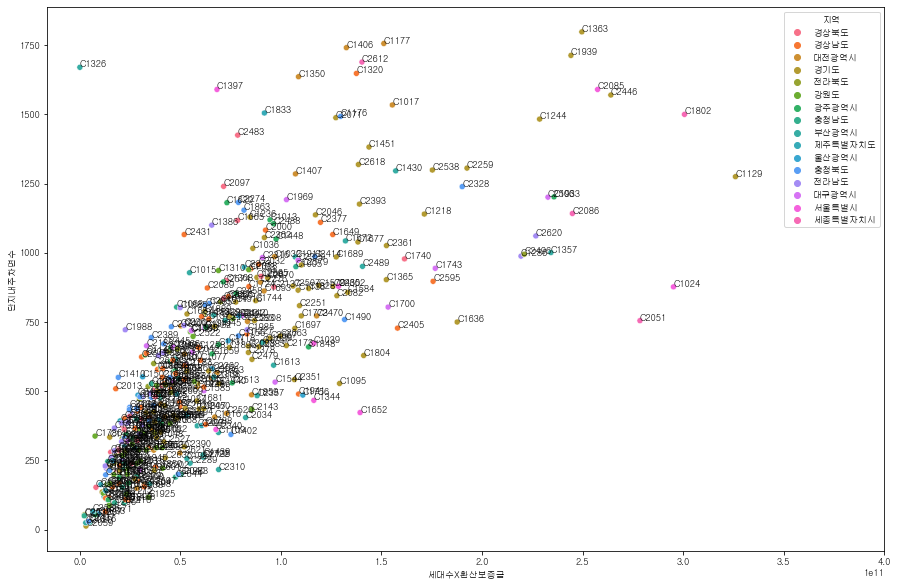

In [772]:
plt.figure(figsize=(15, 10))
plots = sns.scatterplot(data=train_deposit, x='세대수X환산보증금', y='단지내주차면수', hue='지역')
for i, code in enumerate(train_deposit['단지코드']):
    plots.annotate(code, (train_deposit['세대수X환산보증금'][i], train_deposit['단지내주차면수'][i]))
plt.xlim(right=400000000000)
plt.show()

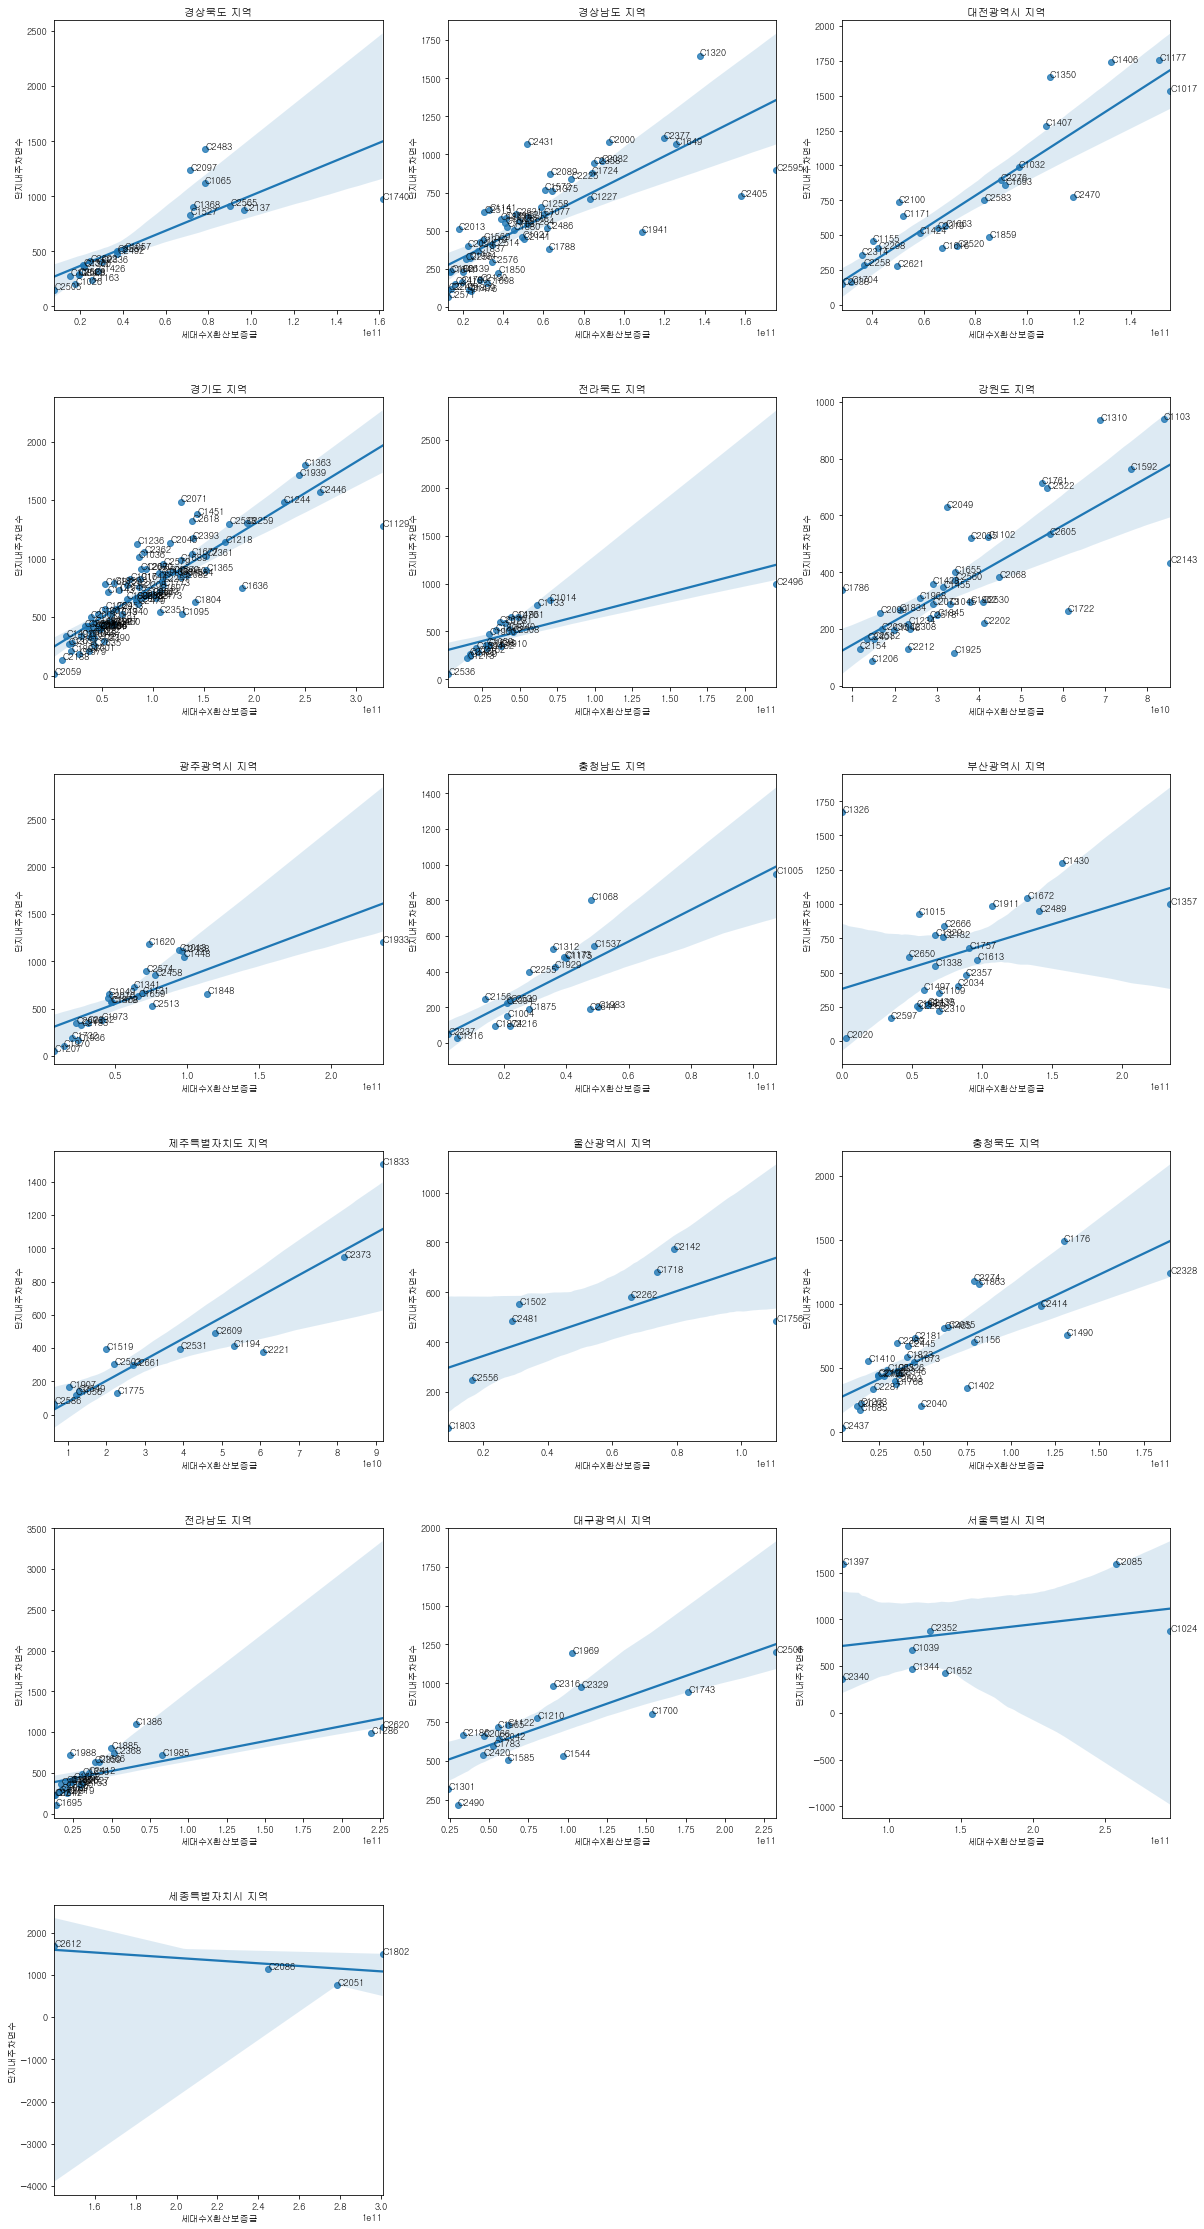

In [717]:
fig = plt.figure(figsize=(20, 40))
for i, n in enumerate(list(train_deposit['지역'].unique())):
    plt.subplot(6, 3, i+1)
    plt.subplots_adjust(hspace=0.3)
    plots = sns.regplot(data=train_deposit.loc[train_deposit['지역'] == n], x='세대수X환산보증금', y='단지내주차면수')
    for i, code in enumerate(train_deposit.loc[train_deposit['지역'] == n].reset_index(drop=True)['단지코드']):
        plots.annotate(code, (train_deposit.loc[train_deposit['지역'] == n].reset_index(drop=True)['세대수X환산보증금'][i],
                              train_deposit.loc[train_deposit['지역'] == n].reset_index(drop=True)['단지내주차면수'][i]))
    plt.title('{} 지역'.format(n))

In [488]:
train

단지코드  총세대수 임대건물구분     지역       공급유형   전용면적  전용면적별세대수   공가수 자격유형  \
0     C2483   900    아파트   경상북도       국민임대  39.72       134  38.0    A   
1     C2483   900    아파트   경상북도       국민임대  39.72        15  38.0    A   
2     C2483   900    아파트   경상북도       국민임대  51.93       385  38.0    A   
3     C2483   900    아파트   경상북도       국민임대  51.93        15  38.0    A   
4     C2483   900    아파트   경상북도       국민임대  51.93        41  38.0    A   
...     ...   ...    ...    ...        ...    ...       ...   ...  ...   
2951  C2532   239    아파트    강원도       국민임대  54.95        19   7.0    A   
2952  C1804   478    아파트    경기도  공공임대(10년)  75.78        13   3.0    A   
2953  C2470   636    아파트  대전광역시       공공분양  74.99        72   1.0    A   
2954  C2470   636    아파트  대전광역시       공공분양  74.95        66   1.0    A   
2955  C2470   636    아파트  대전광역시       공공분양  74.99        92   1.0    A   

          임대보증금     임대료  지하철   버스  단지내주차면수   등록차량수     건축연면적      환산보증금  \
0      15667000  103680  0.0  3.0   1425.0  1015.0   5322.48   52369720   
1      15667000  103680  0.0  3.0   1425.0  1015.0    595.80   52369720   
2      27304000  184330  0.0  3.0   1425.0  1015.0  19993.05   92556820   
3      27304000  184330  0.0  3.0   1425.0  1015.0    778.95   92556820   
4      27304000  184330  0.0  3.0   1425.0  1015.0   2129.13   92556820   
...         ...     ...  ...  ...      ...     ...       ...        ...   
2951   14830000  151030  0.0  1.0    166.0   146.0   1044.05   68294620   
2952   78957000  530130  0.0  3.0    629.0   951.0    985.14  266623020   
2953  225013300       0  1.0  2.0    772.0   887.0   5399.28  225013300   
2954  226278000       0  1.0  2.0    772.0   887.0   4946.70  226278000   
2955  230417000       0  1.0  2.0    772.0   887.0   6899.08  230417000   

       면적당환산보증금    세대수X환산보증금  
0     1318472.0   7017542480  
1     1318472.0    785545800  
2     1782338.0  35634375700  
3     1782338.0   1388352300  
4     1782338.0   3794829620  
...         ...          ...  
2951  1242850.0   1297597780  
2952  3518382.0   3466099260  
2953  3000577.0  16200957600  
2954  3019053.0  14934348000  
2955  3072636.0  21198364000  

[2956 rows x 19 columns]

In [489]:
train_danji['총세대수/단지내주차면수'] = train_danji['총세대수'] / train_danji['단지내주차면수']

In [490]:
drop_list = train_danji.loc[(train_danji['총세대수/단지내주차면수'] < 0.3) | (train_danji['총세대수/단지내주차면수'] > 5)]['단지코드']

In [745]:
drop_list.values

array(['C1925', 'C1874', 'C2621', 'C2038', 'C2190', 'C1109', 'C2289',
       'C2597', 'C2310', 'C1439', 'C1206', 'C1775', 'C1875', 'C2212',
       'C2571', 'C1397'], dtype=object)

## VALUE PREPROCCESSING

In [491]:
train.loc[train['단지코드'] == 'C1206']

단지코드  총세대수 임대건물구분   지역  공급유형    전용면적  전용면적별세대수  공가수 자격유형    임대보증금  \
647  C1206   755    아파트  강원도  영구임대   26.37       239  1.0    C  3141000   
648  C1206   755    아파트  강원도  영구임대   31.32       239  1.0    C  3731000   
649  C1206   755     상가  강원도  임대상가   31.84         1  1.0    D        0   
650  C1206   755     상가  강원도  임대상가   31.84         1  1.0    D        0   
651  C1206   755     상가  강원도  임대상가   31.84         1  1.0    D        0   
652  C1206   755     상가  강원도  임대상가   31.84         1  1.0    D        0   
653  C1206   755     상가  강원도  임대상가   31.84         1  1.0    D        0   
654  C1206   755     상가  강원도  임대상가   31.84         1  1.0    D        0   
655  C1206   755     상가  강원도  임대상가   31.84         1  1.0    D        0   
656  C1206   755     상가  강원도  임대상가   31.84         1  1.0    D        0   
657  C1206   755     상가  강원도  임대상가   63.68         1  1.0    D        0   
658  C1206   755     상가  강원도  임대상가  137.49         1  1.0    D        0   

       임대료  지하철   버스  단지내주차면수  등록차량수    건축연면적     환산보증금   면적당환산보증금   세대수X환산보증금  
647  69900  0.0  4.0     88.0   90.0  6302.43  27885600  1057474.0  6664658400  
648  83020  0.0  4.0     88.0   90.0  7485.48  33120080  1057474.0  7915699120  
649      0  0.0  4.0     88.0   90.0    31.84         0        0.0           0  
650      0  0.0  4.0     88.0   90.0    31.84         0        0.0           0  
651      0  0.0  4.0     88.0   90.0    31.84         0        0.0           0  
652      0  0.0  4.0     88.0   90.0    31.84         0        0.0           0  
653      0  0.0  4.0     88.0   90.0    31.84         0        0.0           0  
654      0  0.0  4.0     88.0   90.0    31.84         0        0.0           0  
655      0  0.0  4.0     88.0   90.0    31.84         0        0.0           0  
656      0  0.0  4.0     88.0   90.0    31.84         0        0.0           0  
657      0  0.0  4.0     88.0   90.0    63.68         0        0.0           0  
658      0  0.0  4.0     88.0   90.0   137.49         0        0.0           0

- 속초 청초 아파트, 무려 1993년에 지어진 아파트입니다. 30년이 더 되었습니다.
- 속초 청초 아파트 데이터는 조금 특이합니다. 영구임대는 478세대가 있습니다.
- 그러나 분양 세대까지 합쳐서 755 세대입니다. 여기서는 또 총 세대수를 755로 해놨습니다.
- 네이버 부동산 정보에 의하면 주차는 약 400개 입니다.
- 근데 여기는 또 주차면수가 88개라고 합니다.
- 지도를 살펴봐도 400개는 안되어보입니다. 그렇다고 88개는 또 말이 안됩니다.
- 근데 등록차량수는 또 90대 입니다.
- 알았습니다. 해당 단지는 분양세대와 임대세대까지 755호의 단지는 맞지만, 임대세대는 478세대, 그리고 임대단지 앞에 있는 주차면수는 88개가 맞습니다.
- 분양단지까지 했을 때, 주차면수는 늘어나지만, 그걸 원하는 것은 아닙니다.
- 즉, 해당 단지는 세대수를 478로 줄이는 게 맞습니다.

In [381]:
train.loc[train['공급유형'] == '공공분양']

단지코드  총세대수 임대건물구분     지역  공급유형   전용면적  전용면적별세대수  공가수 자격유형      임대보증금  \
2331  C1350  1401    아파트  대전광역시  공공분양  74.94       317  2.0    D          0   
2332  C1350  1401    아파트  대전광역시  공공분양  74.94       137  2.0    D          0   
2333  C1350  1401    아파트  대전광역시  공공분양  74.94        22  2.0    D          0   
2334  C1350  1401    아파트  대전광역시  공공분양  84.94       164  2.0    D          0   
2335  C1350  1401    아파트  대전광역시  공공분양  84.94        19  2.0    D          0   
2336  C1350  1401    아파트  대전광역시  공공분양  84.96        26  2.0    D          0   
2337  C1350  1401    아파트  대전광역시  공공분양  84.97        26  2.0    D          0   
2953  C2470   636    아파트  대전광역시  공공분양  74.99        72  1.0    A  225013300   
2954  C2470   636    아파트  대전광역시  공공분양  74.95        66  1.0    A  226278000   
2955  C2470   636    아파트  대전광역시  공공분양  74.99        92  1.0    A  230417000   

      임대료  지하철   버스  단지내주차면수   등록차량수     건축연면적      환산보증금   면적당환산보증금  \
2331    0  0.0  6.0   1636.0  2315.0  23755.98          0  2759299.0   
2332    0  0.0  6.0   1636.0  2315.0  10266.78          0  2759299.0   
2333    0  0.0  6.0   1636.0  2315.0   1648.68          0  2759299.0   
2334    0  0.0  6.0   1636.0  2315.0  13930.16          0  2759299.0   
2335    0  0.0  6.0   1636.0  2315.0   1613.86          0  2759299.0   
2336    0  0.0  6.0   1636.0  2315.0   2208.96          0  2759299.0   
2337    0  0.0  6.0   1636.0  2315.0   2209.22          0  2759299.0   
2953    0  1.0  2.0    772.0   887.0   5399.28  225013300  3000577.0   
2954    0  1.0  2.0    772.0   887.0   4946.70  226278000  3019053.0   
2955    0  1.0  2.0    772.0   887.0   6899.08  230417000  3072636.0   

        세대수X환산보증금  
2331            0  
2332            0  
2333            0  
2334            0  
2335            0  
2336            0  
2337            0  
2953  16200957600  
2954  14934348000  
2955  21198364000

In [382]:
test.loc[test['공급유형'] == '공공분양']

Empty DataFrame
Columns: [단지코드, 총세대수, 임대건물구분, 지역, 공급유형, 전용면적, 전용면적별세대수, 공가수, 자격유형, 임대보증금, 임대료, 지하철, 버스, 단지내주차면수, 건축연면적, 환산보증금, 면적당환산보증금, 세대수X환산보증금]
Index: []

In [383]:
train.loc[train['단지코드'] == 'C1350']

단지코드  총세대수 임대건물구분     지역       공급유형   전용면적  전용면적별세대수  공가수 자격유형  \
2331  C1350  1401    아파트  대전광역시       공공분양  74.94       317  2.0    D   
2332  C1350  1401    아파트  대전광역시       공공분양  74.94       137  2.0    D   
2333  C1350  1401    아파트  대전광역시       공공분양  74.94        22  2.0    D   
2334  C1350  1401    아파트  대전광역시       공공분양  84.94       164  2.0    D   
2335  C1350  1401    아파트  대전광역시       공공분양  84.94        19  2.0    D   
2336  C1350  1401    아파트  대전광역시       공공분양  84.96        26  2.0    D   
2337  C1350  1401    아파트  대전광역시       공공분양  84.97        26  2.0    D   
2338  C1350  1401    아파트  대전광역시  공공임대(10년)  51.99       106  2.0    A   
2339  C1350  1401    아파트  대전광역시  공공임대(10년)  59.91        13  2.0    A   
2340  C1350  1401    아파트  대전광역시  공공임대(10년)  59.92       223  2.0    A   
2341  C1350  1401    아파트  대전광역시   공공임대(분납)  51.99       146  2.0    A   
2342  C1350  1401    아파트  대전광역시   공공임대(분납)  59.91        32  2.0    A   
2343  C1350  1401    아파트  대전광역시   공공임대(분납)  59.92       170  2.0    A   

         임대보증금     임대료  지하철   버스  단지내주차면수   등록차량수     건축연면적      환산보증금  \
2331         0       0  0.0  6.0   1636.0  2315.0  23755.98          0   
2332         0       0  0.0  6.0   1636.0  2315.0  10266.78          0   
2333         0       0  0.0  6.0   1636.0  2315.0   1648.68          0   
2334         0       0  0.0  6.0   1636.0  2315.0  13930.16          0   
2335         0       0  0.0  6.0   1636.0  2315.0   1613.86          0   
2336         0       0  0.0  6.0   1636.0  2315.0   2208.96          0   
2337         0       0  0.0  6.0   1636.0  2315.0   2209.22          0   
2338  28013000  408600  0.0  6.0   1636.0  2315.0   5510.94  172657400   
2339  37474000  519350  0.0  6.0   1636.0  2315.0    778.83  221323900   
2340  37385000  516130  0.0  6.0   1636.0  2315.0  13362.16  220095020   
2341  54612000  131130  0.0  6.0   1636.0  2315.0   7590.54  101032020   
2342  63585000  152680  0.0  6.0   1636.0  2315.0   1917.12  117633720   
2343  63501000  152480  0.0  6.0   1636.0  2315.0  10186.40  117478920   

       면적당환산보증금    세대수X환산보증금  
2331  2759299.0            0  
2332  2759299.0            0  
2333  2759299.0            0  
2334  2759299.0            0  
2335  2759299.0            0  
2336  2759299.0            0  
2337  2759299.0            0  
2338  3320973.0  18301684400  
2339  3694273.0   2877210700  
2340  3673148.0  49081189460  
2341  1943297.0  14750674920  
2342  1963507.0   3764279040  
2343  1960596.0  19971416400

In [384]:
train.loc[train['단지코드'] == 'C2470']

단지코드  총세대수 임대건물구분     지역      공급유형   전용면적  전용면적별세대수  공가수 자격유형  \
2580  C2470   636    아파트  대전광역시  공공임대(5년)  39.90        96  1.0    A   
2581  C2470   636    아파트  대전광역시  공공임대(5년)  46.81       264  1.0    A   
2582  C2470   636    아파트  대전광역시  공공임대(5년)  59.95        46  1.0    A   
2953  C2470   636    아파트  대전광역시      공공분양  74.99        72  1.0    A   
2954  C2470   636    아파트  대전광역시      공공분양  74.95        66  1.0    A   
2955  C2470   636    아파트  대전광역시      공공분양  74.99        92  1.0    A   

          임대보증금     임대료  지하철   버스  단지내주차면수  등록차량수     건축연면적      환산보증금  \
2580   23000000  340000  1.0  2.0    772.0  887.0   3830.40  143360000   
2581   26000000  380000  1.0  2.0    772.0  887.0  12357.84  160520000   
2582   32000000  480000  1.0  2.0    772.0  887.0   2757.70  201920000   
2953  225013300       0  1.0  2.0    772.0  887.0   5399.28  225013300   
2954  226278000       0  1.0  2.0    772.0  887.0   4946.70  226278000   
2955  230417000       0  1.0  2.0    772.0  887.0   6899.08  230417000   

       면적당환산보증금    세대수X환산보증금  
2580  3592982.0  13762560000  
2581  3429182.0  42377280000  
2582  3368140.0   9288320000  
2953  3000577.0  16200957600  
2954  3019053.0  14934348000  
2955  3072636.0  21198364000

In [385]:
train.loc[train['단지코드'] == 'C1350']['전용면적별세대수'].sum()

1401

# TESTING

### 1. 방의 개수가 차량 보유에 영향을 미치는가?

In [773]:
train.loc[train['전용면적'] < 35, '방개수'] = '1룸'
train.loc[train['전용면적'] >= 35, '방개수'] = '2룸'
train.loc[train['전용면적'] >= 45, '방개수'] = '3룸'
train.loc[train['전용면적'] >= 56, '방개수'] = '4룸'
train.loc[train['전용면적'] >= 77, '방개수'] = '5룸'

In [774]:
test.loc[test['전용면적'] < 35, '방개수'] = '1룸'
test.loc[test['전용면적'] >= 35, '방개수'] = '2룸'
test.loc[test['전용면적'] >= 45, '방개수'] = '3룸'
test.loc[test['전용면적'] >= 56, '방개수'] = '4룸'
test.loc[test['전용면적'] >= 77, '방개수'] = '5룸'

In [690]:
rooms = pd.pivot_table(train.loc[train['임대건물구분'] != '상가'],
                       index='단지코드', columns='방개수', values='전용면적별세대수',
                       aggfunc='sum')

In [691]:
temp = train.groupby(['단지코드'])[['총세대수', '지역', '단지내주차면수', '등록차량수']].max()

In [692]:
rooms_danji = pd.concat([rooms, temp], axis=1)

In [712]:
rooms_danji['1룸비율'] = rooms_danji['1룸'] / rooms_danji['총세대수']
rooms_danji['2룸비율'] = rooms_danji['2룸'] / rooms_danji['총세대수']
rooms_danji['3룸비율'] = rooms_danji['3룸'] / rooms_danji['총세대수']
rooms_danji['4룸비율'] = rooms_danji['4룸'] / rooms_danji['총세대수']
rooms_danji['5룸비율'] = rooms_danji['5룸'] / rooms_danji['총세대수']

rooms_danji['단지내주차면수/총세대수'] = rooms_danji['단지내주차면수'] / rooms_danji['총세대수']
rooms_danji['등록차량수/총세대수'] = rooms_danji['등록차량수'] / rooms_danji['총세대수']
rooms_danji['등록차량수/단지내주차면수'] = rooms_danji['등록차량수'] / rooms_danji['단지내주차면수']

In [713]:
rooms_cols = ['1룸비율', '2룸비율', '3룸비율', '4룸비율', '5룸비율']

In [714]:
rooms_danji

1룸     2룸      3룸     4룸  5룸  총세대수     지역  단지내주차면수   등록차량수  \
단지코드                                                                   
C1000    NaN  419.0   147.0    NaN NaN   566   충청북도    438.0   481.0   
C1004    NaN  504.0     NaN    NaN NaN   521   충청남도    153.0    93.0   
C1005    NaN    NaN   904.0  240.0 NaN  1144   충청남도    950.0   376.0   
C1013    NaN  291.0  1017.0    NaN NaN  1308  광주광역시   1119.0  1665.0   
C1014  516.0    NaN   396.0   84.0 NaN   996   전라북도    823.0   708.0   
...      ...    ...     ...    ...  ..   ...    ...      ...     ...   
C2663  112.0  220.0   440.0    NaN NaN   772    경기도    700.0   652.0   
C2666    NaN  458.0   626.0    NaN NaN  1084  부산광역시    837.0   701.0   
C2670  192.0  312.0   144.0    NaN NaN   648   전라북도    600.0   435.0   
C2680    NaN  486.0   272.0    NaN NaN   758   경상남도    564.0   590.0   
C2692    NaN  334.0   165.0    NaN NaN   499   경상북도    409.0   437.0   

           1룸비율      2룸비율      3룸비율      4룸비율  5룸비율  단지내주차면수/총세대수  등록차량수/총세대수  \
단지코드                                                                            
C1000       NaN  0.740283  0.259717       NaN   NaN      0.773852    0.849823   
C1004       NaN  0.967370       NaN       NaN   NaN      0.293666    0.178503   
C1005       NaN       NaN  0.790210  0.209790   NaN      0.830420    0.328671   
C1013       NaN  0.222477  0.777523       NaN   NaN      0.855505    1.272936   
C1014  0.518072       NaN  0.397590  0.084337   NaN      0.826305    0.710843   
...         ...       ...       ...       ...   ...           ...         ...   
C2663  0.145078  0.284974  0.569948       NaN   NaN      0.906736    0.844560   
C2666       NaN  0.422509  0.577491       NaN   NaN      0.772140    0.646679   
C2670  0.296296  0.481481  0.222222       NaN   NaN      0.925926    0.671296   
C2680       NaN  0.641161  0.358839       NaN   NaN      0.744063    0.778364   
C2692       NaN  0.669339  0.330661       NaN   NaN      0.819639    0.875752   

       등록차량수/단지내주차면수  
단지코드                  
C1000       1.098174  
C1004       0.607843  
C1005       0.395789  
C1013       1.487936  
C1014       0.860267  
...              ...  
C2663       0.931429  
C2666       0.837515  
C2670       0.725000  
C2680       1.046099  
C2692       1.068460  

[423 rows x 17 columns]

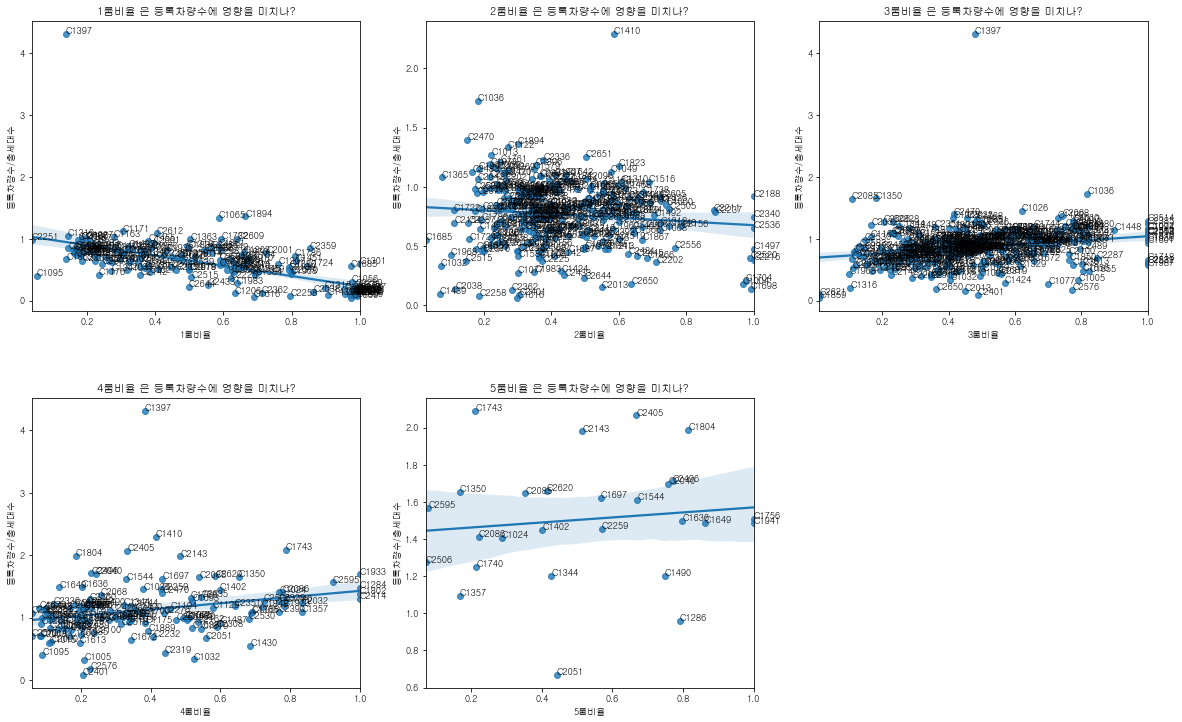

In [725]:
fig = plt.figure(figsize=(20, 40))
for i, n in enumerate(rooms_cols):
    plt.subplot(6, 3, i+1)
    plt.subplots_adjust(hspace=0.3)
    plots = sns.regplot(data=rooms_danji, x=n, y='등록차량수/총세대수')
    for i, code in enumerate(rooms_danji.reset_index(drop=False)['단지코드']):
        plots.annotate(code, (rooms_danji.reset_index(drop=False)[n][i],
                              rooms_danji.reset_index(drop=False)['등록차량수/총세대수'][i]))
    plt.title('{} 은 등록차량수에 영향을 미치나?'.format(n))

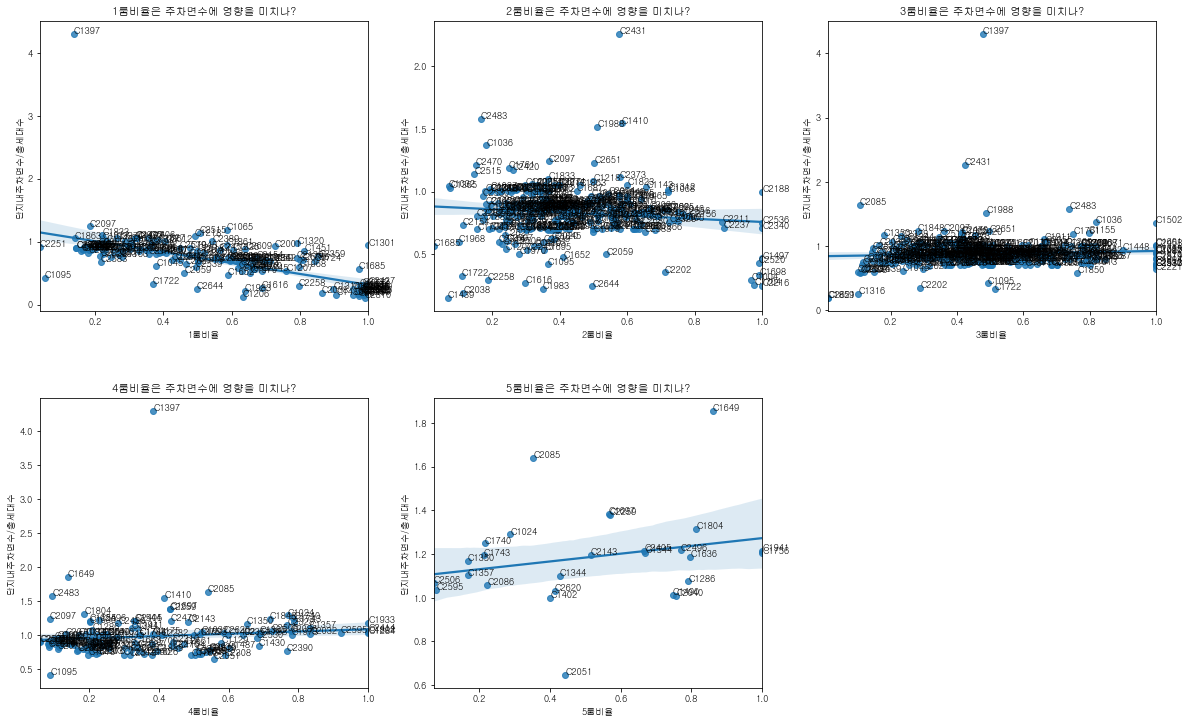

In [726]:
fig = plt.figure(figsize=(20, 40))
for i, n in enumerate(rooms_cols):
    plt.subplot(6, 3, i+1)
    plt.subplots_adjust(hspace=0.3)
    plots = sns.regplot(data=rooms_danji, x=n, y='단지내주차면수/총세대수')
    for i, code in enumerate(rooms_danji.reset_index(drop=False)['단지코드']):
        plots.annotate(code, (rooms_danji.reset_index(drop=False)[n][i],
                              rooms_danji.reset_index(drop=False)['단지내주차면수/총세대수'][i]))
    plt.title('{}은 주차면수에 영향을 미치나?'.format(n))

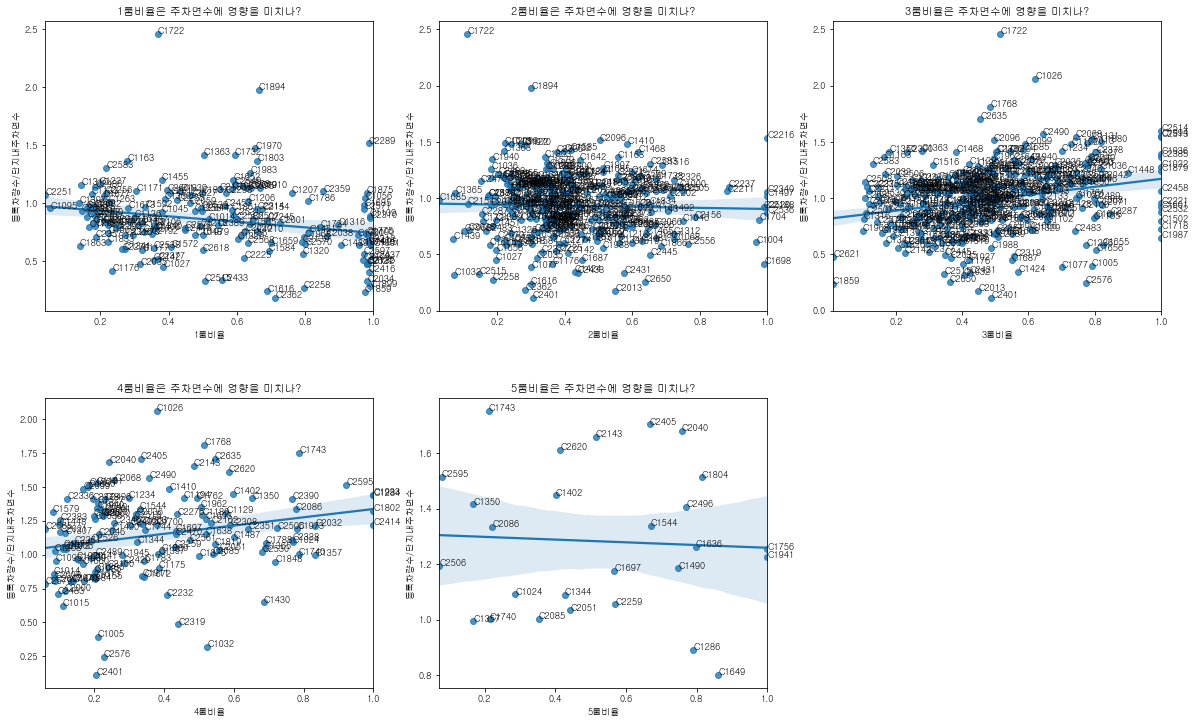

In [739]:
fig = plt.figure(figsize=(20, 40))
for i, n in enumerate(rooms_cols):
    plt.subplot(6, 3, i+1)
    plt.subplots_adjust(hspace=0.3)
    plots = sns.regplot(data=rooms_danji, x=n, y='등록차량수/단지내주차면수')
    for i, code in enumerate(rooms_danji.reset_index(drop=False)['단지코드']):
        plots.annotate(code, (rooms_danji.reset_index(drop=False)[n][i],
                              rooms_danji.reset_index(drop=False)['등록차량수/단지내주차면수'][i]))
    plt.title('{}은 주차면수에 영향을 미치나?'.format(n))

### 2. 크기 분류가 차량 보유에 영향을 미치는가?

In [775]:
# 80 ~ 은 대형
# 40 ~ 80 은 중형
# ~ 40 은 소형

train.loc[train['전용면적'] < 40, '전용면적구분'] = '소형'
train.loc[train['전용면적'] >= 40, '전용면적구분'] = '중형'
train.loc[train['전용면적'] >= 80, '전용면적구분'] = '대형'

test.loc[test['전용면적'] < 40, '전용면적구분'] = '소형'
test.loc[test['전용면적'] >= 40, '전용면적구분'] = '중형'
test.loc[test['전용면적'] >= 80, '전용면적구분'] = '대형'

In [729]:
size = pd.pivot_table(train.loc[train['임대건물구분'] != '상가'],
                       index='단지코드', columns='전용면적구분', values='전용면적별세대수',
                       aggfunc='sum')

In [730]:
temp = train.groupby(['단지코드'])[['총세대수', '지역', '단지내주차면수', '등록차량수']].max()

In [731]:
size_danji = pd.concat([size, temp], axis=1)

In [733]:
size_danji['소형비율'] = size_danji['소형'] / size_danji['총세대수']
size_danji['중형비율'] = size_danji['중형'] / size_danji['총세대수']
size_danji['대형비율'] = size_danji['대형'] / size_danji['총세대수']

size_danji['단지내주차면수/총세대수'] = size_danji['단지내주차면수'] / size_danji['총세대수']
size_danji['등록차량수/총세대수'] = size_danji['등록차량수'] / size_danji['총세대수']
size_danji['등록차량수/단지내주차면수'] = size_danji['등록차량수'] / size_danji['단지내주차면수']

In [734]:
size_cols = ['소형비율', '중형비율', '대형비율']

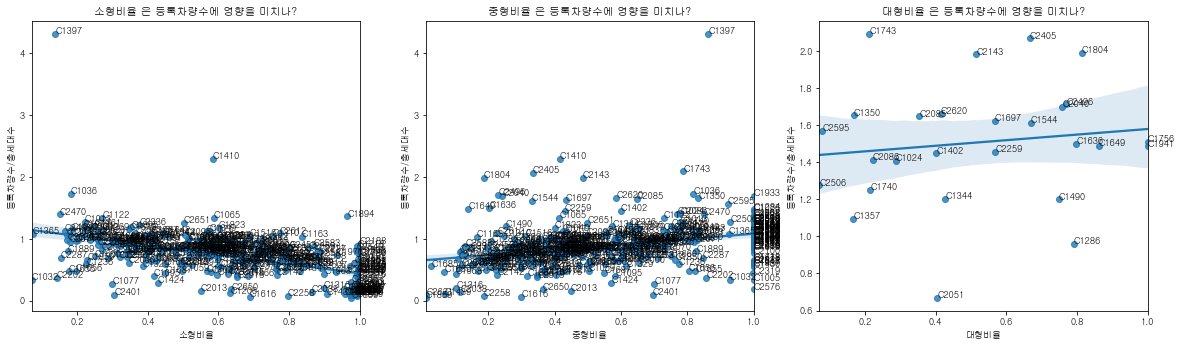

In [736]:
fig = plt.figure(figsize=(20, 40))
for i, n in enumerate(size_cols):
    plt.subplot(6, 3, i+1)
    plt.subplots_adjust(hspace=0.3)
    plots = sns.regplot(data=size_danji, x=n, y='등록차량수/총세대수')
    for i, code in enumerate(size_danji.reset_index(drop=False)['단지코드']):
        plots.annotate(code, (size_danji.reset_index(drop=False)[n][i],
                              size_danji.reset_index(drop=False)['등록차량수/총세대수'][i]))
    plt.title('{} 은 등록차량수에 영향을 미치나?'.format(n))

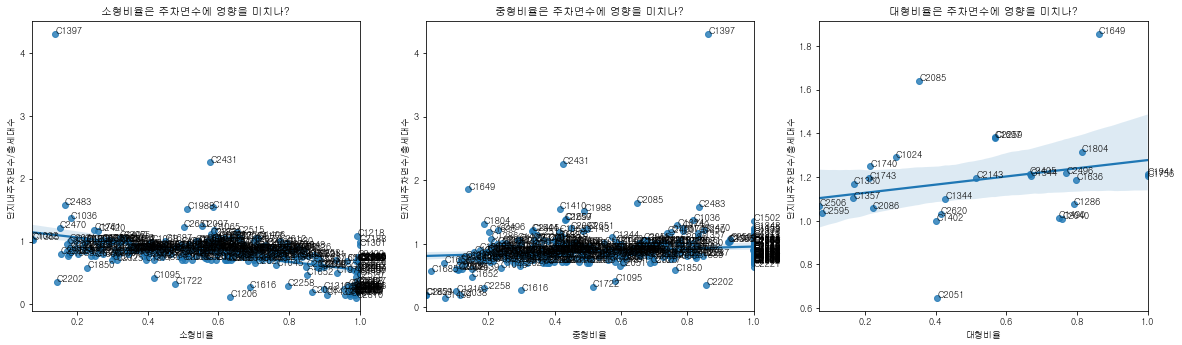

In [737]:
fig = plt.figure(figsize=(20, 40))
for i, n in enumerate(size_cols):
    plt.subplot(6, 3, i+1)
    plt.subplots_adjust(hspace=0.3)
    plots = sns.regplot(data=size_danji, x=n, y='단지내주차면수/총세대수')
    for i, code in enumerate(size_danji.reset_index(drop=False)['단지코드']):
        plots.annotate(code, (size_danji.reset_index(drop=False)[n][i],
                              size_danji.reset_index(drop=False)['단지내주차면수/총세대수'][i]))
    plt.title('{}은 주차면수에 영향을 미치나?'.format(n))

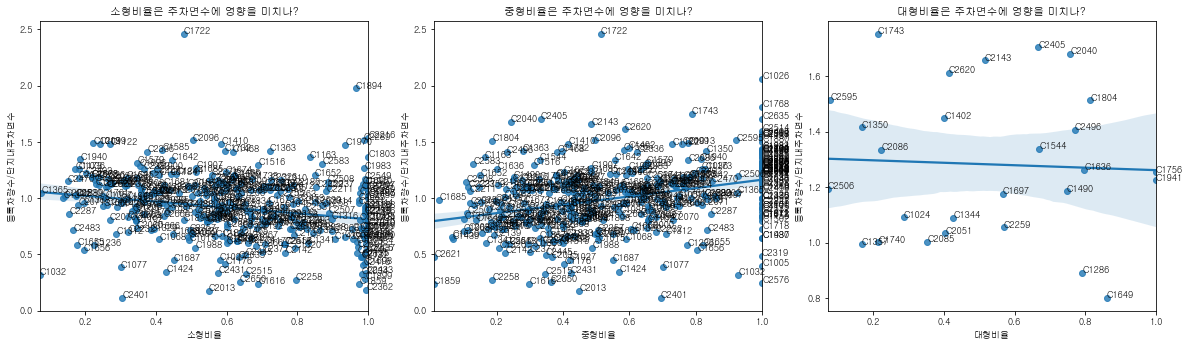

In [738]:
fig = plt.figure(figsize=(20, 40))
for i, n in enumerate(size_cols):
    plt.subplot(6, 3, i+1)
    plt.subplots_adjust(hspace=0.3)
    plots = sns.regplot(data=size_danji, x=n, y='등록차량수/단지내주차면수')
    for i, code in enumerate(size_danji.reset_index(drop=False)['단지코드']):
        plots.annotate(code, (size_danji.reset_index(drop=False)[n][i],
                              size_danji.reset_index(drop=False)['등록차량수/단지내주차면수'][i]))
    plt.title('{}은 주차면수에 영향을 미치나?'.format(n))

### 3. 땅값이 중요할까?

어떻게 하면 더 정확한 지가를 구할 수 있을까?

In [777]:
no_deposit = ['C1350', 'C1786', 'C2186', 'C1326']

In [797]:
train.loc[train['단지코드'].isin(no_deposit)]

단지코드  총세대수 임대건물구분     지역       공급유형   전용면적  전용면적별세대수   공가수 자격유형  \
2331  C1350  1401    아파트  대전광역시       공공분양  74.94       317   2.0    D   
2332  C1350  1401    아파트  대전광역시       공공분양  74.94       137   2.0    D   
2333  C1350  1401    아파트  대전광역시       공공분양  74.94        22   2.0    D   
2334  C1350  1401    아파트  대전광역시       공공분양  84.94       164   2.0    D   
2335  C1350  1401    아파트  대전광역시       공공분양  84.94        19   2.0    D   
2336  C1350  1401    아파트  대전광역시       공공분양  84.96        26   2.0    D   
2337  C1350  1401    아파트  대전광역시       공공분양  84.97        26   2.0    D   
2338  C1350  1401    아파트  대전광역시  공공임대(10년)  51.99       106   2.0    A   
2339  C1350  1401    아파트  대전광역시  공공임대(10년)  59.91        13   2.0    A   
2340  C1350  1401    아파트  대전광역시  공공임대(10년)  59.92       223   2.0    A   
2341  C1350  1401    아파트  대전광역시   공공임대(분납)  51.99       146   2.0    A   
2342  C1350  1401    아파트  대전광역시   공공임대(분납)  59.91        32   2.0    A   
2343  C1350  1401    아파트  대전광역시   공공임대(분납)  59.92       170   2.0    A   
2547  C1326  1934    아파트  부산광역시       국민임대  24.72       472  43.0    H   
2548  C1326  1934    아파트  부산광역시       국민임대  24.79       104  43.0    H   
2549  C1326  1934    아파트  부산광역시       국민임대  26.83       590  43.0    H   
2550  C1326  1934    아파트  부산광역시       국민임대  37.70       464  43.0    H   
2551  C1326  1934    아파트  부산광역시       국민임대  46.94       304  43.0    H   
2680  C1786   480    아파트    강원도       행복주택  16.91       156  25.0    K   
2681  C1786   480    아파트    강원도       행복주택  26.90       136  25.0    K   
2682  C1786   480    아파트    강원도       행복주택  26.90        72  25.0    K   
2683  C1786   480    아파트    강원도       행복주택  26.90        24  25.0    K   
2684  C1786   480    아파트    강원도       행복주택  36.91        92  25.0    J   
2906  C2186   924    아파트  대구광역시       국민임대  29.17       238   0.0    H   
2907  C2186   924    아파트  대구광역시       국민임대  29.34        38   0.0    H   
2908  C2186   924    아파트  대구광역시       국민임대  37.43       220   0.0    H   
2909  C2186   924    아파트  대구광역시       국민임대  46.51       188   0.0    H   
2910  C2186   924    아파트  대구광역시       영구임대  26.37       219   0.0    C   
2911  C2186   924    아파트  대구광역시       영구임대  26.54        13   0.0    C   

         임대보증금     임대료  지하철   버스  단지내주차면수   등록차량수      환산보증금   면적당환산보증금  
2331         0       0  0.0  6.0   1636.0  2315.0          0        0.0  
2332         0       0  0.0  6.0   1636.0  2315.0          0        0.0  
2333         0       0  0.0  6.0   1636.0  2315.0          0        0.0  
2334         0       0  0.0  6.0   1636.0  2315.0          0        0.0  
2335         0       0  0.0  6.0   1636.0  2315.0          0        0.0  
2336         0       0  0.0  6.0   1636.0  2315.0          0        0.0  
2337         0       0  0.0  6.0   1636.0  2315.0          0        0.0  
2338  28013000  408600  0.0  6.0   1636.0  2315.0  172657400  3320973.0  
2339  37474000  519350  0.0  6.0   1636.0  2315.0  221323900  3694273.0  
2340  37385000  516130  0.0  6.0   1636.0  2315.0  220095020  3673148.0  
2341  54612000  131130  0.0  6.0   1636.0  2315.0  101032020  1943297.0  
2342  63585000  152680  0.0  6.0   1636.0  2315.0  117633720  1963507.0  
2343  63501000  152480  0.0  6.0   1636.0  2315.0  117478920  1960596.0  
2547         0       0  0.0  4.0   1670.0  1153.0          0        0.0  
2548         0       0  0.0  4.0   1670.0  1153.0          0        0.0  
2549         0       0  0.0  4.0   1670.0  1153.0          0        0.0  
2550         0       0  0.0  4.0   1670.0  1153.0          0        0.0  
2551         0       0  0.0  4.0   1670.0  1153.0          0        0.0  
2680         0       0  0.0  3.0    338.0   345.0          0        0.0  
2681         0       0  0.0  3.0    338.0   345.0          0        0.0  
2682         0       0  0.0  3.0    338.0   345.0          0        0.0  
2683         0       0  0.0  3.0    338.0   345.0          0        0.0  
2684  30560000  145160  0.0  3.0    338.0   345.0   81946640  2220174.0  
2906      

In [799]:
test.loc[test['단지코드'].isin(['C1267', 'C2152'])]

단지코드  총세대수 임대건물구분    지역  공급유형   전용면적  전용면적별세대수   공가수 자격유형     임대보증금  \
1005  C2152   120    아파트   강원도  영구임대  24.83        66   9.0    C         0   
1006  C2152   120    아파트   강원도  영구임대  33.84        54   9.0    C         0   
1007  C1267   675    아파트  경상남도  국민임대  24.87        28  38.0    H   6882000   
1008  C1267   675    아파트  경상남도  국민임대  24.99        90  38.0    H   6882000   
1009  C1267   675    아파트  경상남도  국민임대  24.99        12  38.0    H   6882000   
1010  C1267   675    아파트  경상남도  국민임대  46.72        68  38.0    H  24420000   
1011  C1267   675    아파트  경상남도  국민임대  46.72       112  38.0    H  24420000   
1012  C1267   675    아파트  경상남도  영구임대  22.86        96  38.0    C  10876000   
1013  C1267   675    아파트  경상남도  영구임대  22.86        14  38.0    C  10876000   
1014  C1267   675    아파트  경상남도  행복주택  16.94        50  38.0    L         0   
1015  C1267   675    아파트  경상남도  행복주택  26.85        66  38.0    L         0   
1016  C1267   675    아파트  경상남도  행복주택  26.85         8  38.0    L         0   
1017  C1267   675    아파트  경상남도  행복주택  36.77       126  38.0    L         0   

         임대료  지하철   버스  단지내주차면수      환산보증금   면적당환산보증금  
1005       0  0.0  1.0     40.0          0        0.0  
1006       0  0.0  1.0     40.0          0        0.0  
1007  104370  0.0  1.0    467.0   43828980  1762323.0  
1008  104370  0.0  1.0    467.0   43828980  1753861.0  
1009  104370  0.0  1.0    467.0   43828980  1753861.0  
1010  219230  0.0  1.0    467.0  102027420  2183806.0  
1011  219230  0.0  1.0    467.0  102027420  2183806.0  
1012   89230  0.0  1.0    467.0   42463420  1857542.0  
1013   89230  0.0  1.0    467.0   42463420  1857542.0  
1014       0  0.0  1.0    467.0          0        0.0  
1015       0  0.0  1.0    467.0          0        0.0  
1016       0  0.0  1.0    467.0          0        0.0  
1017       0  0.0  1.0    467.0          0        0.0

자격유형에 따라 임대료와 보증금이 차이가 난다. 따라서 자격유형이 같지 않다면 명확한 환산보증금을 얻을 수 없다.

In [776]:
train.loc[train['임대료'] == '-']

Empty DataFrame
Columns: [단지코드, 총세대수, 임대건물구분, 지역, 공급유형, 전용면적, 전용면적별세대수, 공가수, 자격유형, 임대보증금, 임대료, 지하철, 버스, 단지내주차면수, 등록차량수, 환산보증금, 면적당환산보증금, 세대수X환산보증금, 방개수, 전용면적구분]
Index: []

## Modeling

In [583]:
train['건축연면적'] = train['전용면적'] * train['전용면적별세대수']
test['건축연면적'] = test['전용면적'] * test['전용면적별세대수']

In [584]:
temp = train.groupby(['단지코드']).sum().reset_index()
train_size = pd.merge(train_danji, temp[['단지코드', '건축연면적']], how='inner', on='단지코드')

In [585]:
temp = test.groupby(['단지코드']).sum().reset_index()
test_size = pd.merge(test_danji, temp[['단지코드', '건축연면적']], how='inner', on='단지코드')

In [586]:
train.loc[train['임대보증금'] == '-', '임대보증금'] = 0
test.loc[test['임대보증금'] == '-', '임대보증금'] = 0

train.loc[train['임대료'] == '-', '임대료'] = 0
test.loc[test['임대료'] == '-', '임대료'] = 0

In [587]:
# nan 값 때문에 object로 되어 있습니다. 일단 0으로 채워 줍니다.
train['임대보증금'] = train['임대보증금'].fillna(0)
test['임대보증금'] = test['임대보증금'].fillna(0)

train['임대료'] = train['임대료'].fillna(0)
test['임대료'] = test['임대료'].fillna(0)

In [588]:
# 계산을 위해서 int로 바꿔줍니다.
train['임대보증금'] = train['임대보증금'].astype(int)
test['임대보증금'] = test['임대보증금'].astype(int)

train['임대료'] = train['임대료'].astype(int)
test['임대료'] = test['임대료'].astype(int)

기존의 환산보증금 공식으로 가면, 전세금과 환산보증금 차이가 너무 심합니다.<br>
전세와 월세가 동시에 있는 단지가 1개 있습니다. 이 단지를 기준으로 환산보증금을 재계산 합니다.

In [589]:
(187694000/51.32) - ((45456000 + (356420 * 354))/46.96)

2542.080887400545

In [590]:
# 환산보증금 컬럼을 만들어줍니다.
train['환산보증금'] = train['임대보증금'] + train['임대료'] * 354
test['환산보증금'] = test['임대보증금'] + test['임대료'] * 354

In [591]:
# 제곱미터당 환산보증금을 만들어줍니다.
train['면적당환산보증금'] = (train['환산보증금'] / train['전용면적']).round()
test['면적당환산보증금'] = (test['환산보증금'] / test['전용면적']).round()

- 임대료가 없는 아파트를 찾아서 값을 넣어주겠습니다.

In [592]:
# C1350은 같은 단지에 다른 임대보증금, 임대료가 있습니다.
train.loc[(train['단지코드'] == 'C1350') & (train['임대보증금'] == 0), '면적당환산보증금'] = train.loc[(train['단지코드'] == 'C1350') & (train['임대보증금'] != 0)]['면적당환산보증금'].mean()

In [593]:
# C1786은 같은 단지에 다른 임대보증금, 임대료가 있습니다.
train.loc[(train['단지코드'] == 'C1786') & (train['임대보증금'] == 0), '면적당환산보증금'] = train.loc[(train['단지코드'] == 'C1786') & (train['임대보증금'] != 0)]['면적당환산보증금'].mean()

In [594]:
# C2186은 같은 단지에 다른 임대보증금, 임대료가 있습니다.
train.loc[(train['단지코드'] == 'C2186') & (train['임대보증금'] == 0), '면적당환산보증금'] = train.loc[(train['단지코드'] == 'C2186') & (train['임대보증금'] != 0)]['면적당환산보증금'].mean()

In [595]:
# C1326은 비슷한 유형의 단지를 찾아 평균값으로 넣겠습니다.
train.loc[train['단지코드'] == 'C1326', '면적당환산보증금'] = train.loc[(train['지역'] == '부산광역시')
                                                                  & (train['지하철'] == 0)
                                                                  & (train['임대건물구분'] != '상가')
                                                                  & (train['공급유형'] == '국민임대')
                                                                  & (train['단지코드'] != 'C1326')]['면적당환산보증금'].mean()

In [596]:
# C1267은 같은 단지에 다른 임대보증금, 임대료가 있습니다.
test.loc[(test['단지코드'] == 'C1267') & (test['임대보증금'] == 0), '면적당환산보증금'] = test.loc[(test['단지코드'] == 'C1267') & (test['임대보증금'] != 0)]['면적당환산보증금'].mean()

In [597]:
# C2152은 비슷한 유형의 단지를 찾아 평균값으로 넣겠습니다.
test.loc[test['단지코드'] == 'C2152', '면적당환산보증금'] = test.loc[(test['지역'] == '강원도')
                                                              & (test['임대건물구분'] != '상가')
                                                              & (test['공급유형'] == '영구임대')
                                                              & (test['단지코드'] != 'C2152')]['면적당환산보증금'].mean()

In [598]:
train['세대수X환산보증금'] = train['전용면적별세대수'] * train['환산보증금']
test['세대수X환산보증금'] = test['전용면적별세대수'] * test['환산보증금']

In [599]:
# 공급유형 unstack
temp = train.groupby(['단지코드', '공급유형'])['전용면적별세대수'].sum().unstack().fillna(0)
train = pd.merge(train.loc[:, ~train.columns.isin(['공급유형'])], temp, on='단지코드')
temp = test.groupby(['단지코드', '공급유형'])['전용면적별세대수'].sum().unstack().fillna(0)
test = pd.merge(test.loc[:, ~test.columns.isin(['공급유형'])], temp, on='단지코드')

In [600]:
# 자격유형 unstack
temp = train.groupby(['단지코드', '자격유형'])['전용면적별세대수'].sum().unstack().fillna(0)
train = pd.merge(train.loc[:, ~train.columns.isin(['자격유형'])], temp, on='단지코드')
temp = test.groupby(['단지코드', '자격유형'])['전용면적별세대수'].sum().unstack().fillna(0)
test = pd.merge(test.loc[:, ~test.columns.isin(['자격유형'])], temp, on='단지코드')

In [601]:
# 면적당환산보증금세대수 합계로 산출
temp = train.groupby(['단지코드'])['세대수X환산보증금'].sum().reset_index()
train = pd.merge(train.loc[:, ~train.columns.isin(['세대수X환산보증금'])], temp, on='단지코드')
temp = test.groupby(['단지코드'])['세대수X환산보증금'].sum().reset_index()
test = pd.merge(test.loc[:, ~test.columns.isin(['세대수X환산보증금'])], temp, on='단지코드')

In [602]:
# 건축연면적 합계로 산출
temp = train.groupby(['단지코드'])['건축연면적'].sum().reset_index()
train = pd.merge(train.loc[:, ~train.columns.isin(['건축연면적'])], temp, on='단지코드')
temp = test.groupby(['단지코드'])['건축연면적'].sum().reset_index()
test = pd.merge(test.loc[:, ~test.columns.isin(['건축연면적'])], temp, on='단지코드')

In [603]:
# 실거주세대 대비 차량수의 지역 평균으로 오름차순 정렬
# Order를 주었습니다.
region_dict = {'서울특별시': 0,
               '경기도':1,
               '세종특별자치시':2,
               '경상북도':3,
               '대구광역시':4,
               '광주광역시':5,
               '충청북도':6,
               '전라남도':7,
               '전라북도':8,
               '강원도':9,
               '경상남도':10,
               '울산광역시':11,
               '제주특별자치도':12,
               '대전광역시':13,
               '충청남도':14,
               '부산광역시':15}

train['지역'] = train['지역'].map(region_dict)
test['지역'] = test['지역'].map(region_dict)

In [498]:
from sklearn.preprocessing import OneHotEncoder
ohe = OneHotEncoder()

In [499]:
onehot_X = train['지역'].to_frame()

In [500]:
ohe.fit(onehot_X)

OneHotEncoder()

In [501]:
onehot_encoded = ohe.transform(onehot_X)

In [502]:
onehot_df = pd.DataFrame(onehot_encoded.toarray(),
                         columns = ohe.get_feature_names(['지역']))
train = pd.concat([train, onehot_df], axis=1)
train.drop(['지역'], axis=1, inplace=True)

In [503]:
onehot_df = pd.DataFrame(ohe.transform(test['지역'].to_frame()).toarray(),
                         columns = ohe.get_feature_names(['지역']))
test = pd.concat([test.reset_index(drop=True), onehot_df], axis=1)
test.drop(['지역'], axis=1, inplace=True)

In [604]:
# 전처리가 끝나서 필요없는 변수 삭제
train.drop(['임대건물구분', '전용면적', '전용면적별세대수', '임대보증금', '임대료', '환산보증금', '면적당환산보증금'], axis=1, inplace=True)
test.drop(['임대건물구분', '전용면적', '전용면적별세대수', '임대보증금', '임대료', '환산보증금', '면적당환산보증금'], axis=1, inplace=True)

# # 다중공선성을 띄고 있는 변수 삭제
# train.drop(['전용면적별세대수합'], axis=1, inplace=True)
# test.drop(['전용면적별세대수합'], axis=1, inplace=True)

In [605]:
# 단지고유의 레코드만 남겨줍니다.
train = train.drop_duplicates().reset_index(drop=True)
test = test.drop_duplicates().reset_index(drop=True)

In [606]:
train.shape, test.shape

((423, 35), (150, 28))

In [607]:
set(train.columns).difference(test.columns)

{'B', 'F', 'O', '공공분양', '공공임대(5년)', '등록차량수', '장기전세'}

In [608]:
#train.drop(['B', 'F', 'O', '공공분양','공공임대(5년)', '장기전세'], axis=1, inplace=True)

In [609]:
test['B'] = 0
test['F'] = 0
test['O'] = 0
test['공공분양'] = 0
test['공공임대(5년)'] = 0
test['장기전세'] = 0

In [610]:
train.shape, test.shape

((423, 35), (150, 34))

In [611]:
train

단지코드  총세대수  지역   공가수  지하철   버스  단지내주차면수   등록차량수  공공분양  공공임대(10년)  \
0    C2483   900   3  38.0  0.0  3.0   1425.0  1015.0   0.0        0.0   
1    C2515   545  10  17.0  0.0  3.0    624.0   205.0   0.0        0.0   
2    C1407  1216  13  13.0  1.0  1.0   1285.0  1064.0   0.0        0.0   
3    C1945   755   1   6.0  1.0  3.0    734.0   730.0   0.0        0.0   
4    C1470   696   8  14.0  0.0  2.0    645.0   553.0   0.0        0.0   
..     ...   ...  ..   ...  ...  ...      ...     ...   ...        ...   
418  C2586    90  12   7.0  0.0  3.0     66.0    57.0   0.0        0.0   
419  C2035   492   9  24.0  0.0  1.0    521.0   246.0   0.0        0.0   
420  C2020    40  15   7.0  1.0  2.0     25.0    19.0   0.0        0.0   
421  C2437    90   6  12.0  0.0  1.0     30.0    16.0   0.0        0.0   
422  C2532   239   9   7.0  0.0  1.0    166.0   146.0   0.0        0.0   

     공공임대(50년)  공공임대(5년)  공공임대(분납)    국민임대  영구임대  임대상가  장기전세  행복주택       A  \
0          0.0       0.0       0.0   900.0   0.0   0.0   0.0   0.0   900.0   
1          0.0       0.0       0.0   545.0   0.0   0.0   0.0   0.0   545.0   
2          0.0       0.0       0.0  1216.0   0.0   0.0   0.0   0.0  1216.0   
3          0.0       0.0       0.0   755.0   0.0   0.0   0.0   0.0     0.0   
4          0.0       0.0       0.0   696.0   0.0   0.0   0.0   0.0   696.0   
..         ...       ...       ...     ...   ...   ...   ...   ...     ...   
418        0.0       0.0       0.0     0.0   0.0   0.0   0.0  90.0     0.0   
419        0.0       0.0       0.0   492.0   0.0   0.0   0.0   0.0   492.0   
420        0.0       0.0       0.0     0.0   0.0   0.0   0.0  40.0     0.0   
421        0.0       0.0       0.0     0.0  90.0   0.0   0.0   0.0     0.0   
422        0.0       0.0       0.0   239.0   0.0   0.0   0.0   0.0   239.0   

         B     C    D    E    F    G    H    I     J    K     L    M    N  \
0      0.0   0.0  0.0  0.0  0.0  0.0  0.0  0.0   0.0  0.0   0.0  0.0  0.0   
1      0.0   0.0  0.0  0.0  0.0  0.0  0.0  0.0   0.0  0.0   0.0  0.0  0.0   
2      0.0   0.0  0.0  0.0  0.0  0.0  0.0  0.0   0.0  0.0   0.0  0.0  0.0   
3    755.0   0.0  0.0  0.0  0.0  0.0  0.0  0.0   0.0  0.0   0.0  0.0  0.0   
4      0.0   0.0  0.0  0.0  0.0  0.0  0.0  0.0   0.0  0.0   0.0  0.0  0.0   
..     ...   ...  ...  ...  ...  ...  ...  ...   ...  ...   ...  ...  ...   
418    0.0   0.0  0.0  0.0  0.0  0.0  0.0  0.0  90.0  0.0   0.0  0.0  0.0   
419    0.0   0.0  0.0  0.0  0.0  0.0  0.0  0.0   0.0  0.0   0.0  0.0  0.0   
420    0.0   0.0  0.0  0.0  0.0  0.0  0.0  0.0   0.0  0.0  40.0  0.0  0.0   
421    0.0  90.0  0.0  0.0  0.0  0.0  0.0  0.0   0.0  0.0   0.0  0.0  0.0   
422    0.0   0.0  0.0  0.0  0.0  0.0  0.0  0.0   0.0  0.0   0.0  0.0  0.0   

       O     세대수X환산보증금     건축연면적  
0    0.0   78487311460  45605.89  
1    0.0   30691475160  21941.82  
2    0.0  107233925200  49159.08  
3    0.0   67039301420  37962.15  
4    0.0   44406897640  31250.88  
..   ...           ...       ...  
418  0.0    6485653200   2638.32  
419  0.0   38100528000  18873.12  
420  0.0    2917030100   1017.55  
421  0.0    4357045800   2234.70  
422  0.0   15008047140  12283.42  

[423 rows x 35 columns]

In [621]:
x_train = train.loc[:, ~train.columns.isin(['단지코드', '등록차량수'])]
y_train = train['등록차량수']
x_test = test.loc[:, ~test.columns.isin(['단지코드'])]

In [622]:
x_train.shape, y_train.shape, x_test.shape

((423, 33), (423,), (150, 33))

In [623]:
rf = RandomForestRegressor(random_state=42, oob_score=True, criterion='mse', n_estimators=200)
rf.fit(x_train, y_train)
pred = rf.predict(x_test)

In [624]:
rf.oob_score_

0.7580236146827963

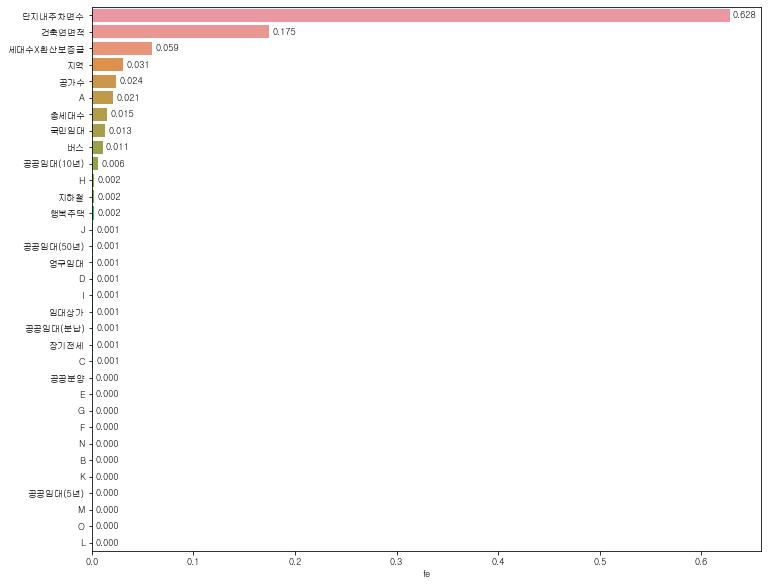

In [625]:
warnings.simplefilter(action='ignore', category=FutureWarning)
plt.rcParams["font.size"] = "9"

fe_avg = pd.DataFrame(rf.feature_importances_,
                      index=x_train.columns, columns=['fe']).sort_values(by=['fe'], ascending=False)

plt.figure(figsize=(12, 10))
plots = sns.barplot(fe_avg.fe, y=fe_avg.index)

# Annotate every single Bar with its value, based on it's width           
for bar in plots.patches:
    width = bar.get_width()
    plt.text(0.015+ bar.get_width(),
             bar.get_y() + 0.5 * bar.get_height(),
             '{:.3f}'.format(width),
             ha='center', va='center')

plt.show()

In [626]:
sub.num = pred

In [627]:
sub

code      num
0    C1072  517.040
1    C1128  804.475
2    C1456  369.070
3    C1840  435.280
4    C1332  718.180
..     ...      ...
145  C2456  229.975
146  C1266  433.265
147  C2152   30.330
148  C1267  303.400
149  C2189  287.905

[150 rows x 2 columns]

In [628]:
sub.to_csv('submission/parking_210628_resetTest3.csv', index=False)